In [1]:
### 常规分析包
import os
import time
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm, pearsonr, spearmanr
from scipy.spatial import distance
### 绘图包
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # 输出PDF文字可编辑
### 其他
import cloudpickle as pickle
import warnings
warnings.filterwarnings("ignore") # 报错提示
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr

In [2]:
sns.color_palette(["#4a4a4a", "#00798c", "#d1495b", '#edae49', '#66a182', '#ffe2b3', '#ccffe4'])

[(0.2901960784313726, 0.2901960784313726, 0.2901960784313726),
 (0.0, 0.4745098039215686, 0.5490196078431373),
 (0.8196078431372549, 0.28627450980392155, 0.3568627450980392),
 (0.9294117647058824, 0.6823529411764706, 0.28627450980392155),
 (0.4, 0.6313725490196078, 0.5098039215686274),
 (1.0, 0.8862745098039215, 0.7019607843137254),
 (0.8, 1.0, 0.8941176470588236)]

In [3]:
def get_matched_pair_set(pairs):
    pair_set = []
    for i in pairs.index:
        for j in pairs.loc[i, :]:
            pair_set.append([i, j])
    pair_set = pd.DataFrame(pair_set, columns=['Case', 'Control'])
    pair_set = pair_set.dropna(how='any')
    return pair_set

def load_resdata(project, path='../Temp/'):
    ### matched result
    matched = pd.read_csv(path+project+'/PSM_Matched.tsv', index_col=0, sep='\t')
    taxa_diff = pd.read_csv(path+project+'/Microbiome_difference.csv', index_col=0).fillna(0)
    path_diff = pd.read_csv(path+project+'/Pathway_difference.csv', index_col=0).fillna(0)
    pairs = pd.read_csv(path+project+'/PSM_Matched_Pairs.tsv', index_col=0, sep='\t')
    pair_set = get_matched_pair_set(pairs)
    ### Raw data
    metadata = pd.read_csv(path+project+'/Metadata.csv', index_col=0)
    microbiome = pd.read_csv(path+project+'/Microbiome.csv', index_col=0)
    pathway = pd.read_csv(path+project+'/Pathway.csv', index_col=0)
    return metadata, matched, taxa_diff, path_diff, pair_set, microbiome, pathway

path = '../Temp/'
projects = [i for i in os.listdir(path) if '.csv' not in i and '.ipynb_checkpoints' not in i and '.DS_Store' not in i and '.RData'not in i and '.Rhistory'not in i]
len(projects), projects[:5]

(88, ['08', '09', '100', '101', '11'])

In [4]:
projects_message=pd.read_csv('../Label/fenzu.csv',index_col=0).T
projects_message=projects_message.to_dict('list')
projects_message

{'01': ['AsnicarF_2017', 'milk', 'control', nan],
 '02': ['AsnicarF_2017', 'stool', 'control', nan],
 '03': ['AsnicarF_2021', 'stool', 'control', nan],
 '04': ['BackhedF_2015', 'stool', 'control', nan],
 '05': ['Bengtsson-PalmeJ_2015', 'stool', 'control', nan],
 '06': ['BritoIL_2016', 'oralcavity', 'control', nan],
 '07': ['BritoIL_2016', 'stool', 'control', nan],
 '08': ['BrooksB_2017', 'stool', 'control', 'premature_born'],
 '09': ['Castro-NallarE_2015', 'oralcavity', 'control', 'schizofrenia'],
 '10': ['ChengpingW_2017', 'stool', 'AS', nan],
 '11': ['ChngKR_2016', 'skin', 'control', 'AD'],
 '12': ['ChuDM_2017', 'oralcavity', 'control', nan],
 '13': ['ChuDM_2017', 'stool', 'control', nan],
 '14': ['CosteaPI_2017', 'stool', 'control', nan],
 '15': ['DavidLA_2015', 'stool', 'control', 'acute_diarrhoea'],
 '16': ['DeFilippisF_2019', 'stool', 'control', nan],
 '17': ['DhakanDB_2019', 'stool', 'control', nan],
 '18_1': ['FengQ_2015', 'stool', 'control', 'adenoma'],
 '18_2': ['FengQ_2015',

In [ ]:
############

In [82]:
diffs = {}
for project in projects:
    name, tissue, trial0, trial1 = projects_message[project]
    if trial0 != 'control':
        continue
    metadata, matched, taxa_diff, path_diff, pairs, microbiome, pathway = load_resdata(project)
    all_species = set(path_diff.index)
    diff_unmatced = set(path_diff.loc[(path_diff["cohen's d(raw)"]>=0.2)&(path_diff["p-value(raw)"]<=0.05), :].index)
    diff_matced = set(path_diff.loc[(path_diff["cohen's d(PSM)"]>=0.2)&(path_diff["p-value(raw)"]<=0.05), :].index)
    diffs[project] = [all_species, diff_unmatced, diff_matced]

In [83]:
def tanimoto(set1, set2):
    t = len(set(set1)&set(set2))/float(len(set(set1)|set(set2))) if len(set(set1)|set(set2))!=0 else 0.0
    return t

import random
def permutation_test(allset, set1, set2, t0, time=999):
    ts = [t0]
    for r in range(time):
        rset1 = random.sample(allset, len(set1))
        rset2 = random.sample(allset, len(set1))
        ts.append(tanimoto(rset1, rset2))
    ts = np.array(ts)
    return (ts>=t0).mean()

selected_projects = list(diffs.keys())
results = []
for i in range(len(selected_projects)-1):
    for j in range(i+1, len(selected_projects)):
        p1 = selected_projects[i]
        p2 = selected_projects[j]
        p1_species, p1_unmatched, p1_matched = diffs[p1]
        p2_species, p2_unmatched, p2_matched = diffs[p2]
        species = set(p1_species)&set(p2_species)
        p1_unmatched = set(species)&set(p1_unmatched)
        p2_unmatched = set(species)&set(p2_unmatched)
        t_unmatched = tanimoto(p1_unmatched, p2_unmatched)
        p_unmatched = permutation_test(species, p1_unmatched, p2_unmatched, t_unmatched, time=999)
        p1_matched = set(species)&set(p1_matched)
        p2_matched = set(species)&set(p2_matched)
        t_matched = tanimoto(p1_matched, p2_matched)
        p_matched = permutation_test(species, p1_matched, p2_matched, t_matched, time=999)
        results.append([p1, p2, len(species), len(p1_unmatched), len(p2_unmatched), len(set(p1_unmatched)|set(p2_unmatched)), 
                        len(set(p2_unmatched)&set(p2_unmatched)), t_unmatched, p_unmatched, 
                        len(p1_matched), len(p2_matched), len(set(p1_matched)|set(p2_matched)), 
                        len(set(p2_matched)&set(p2_matched)), t_matched, p_matched])
        p1, p2, p_unmatched, p_matched
results = pd.DataFrame(results, columns=['project1', 'project2', 'overlap_species', 'unmatched_diff1', 'unmatched_diff2', 
                                         'unmatched_union', 'unmatched_intersection', 'unmatched_score', 'unmatched_pvalue', 
                                         'matched_diff1', 'matched_diff2', 'matched_union', 'matched_intersection', 
                                         'matched_score', 'matched_pvalue'])

('08', '09', 1.0, 1.0)

('08', '100', 1.0, 1.0)

('08', '101', 1.0, 1.0)

('08', '11', 0.001, 1.0)

('08', '15', 0.996, 1.0)

('08', '18_1', 1.0, 1.0)

('08', '18_2', 0.007, 1.0)

('08', '24_1', 0.008, 1.0)

('08', '24_3', 0.001, 0.995)

('08', '26', 0.003, 0.331)

('08', '27', 0.088, 0.107)

('08', '28_1', 1.0, 1.0)

('08', '28_2', 1.0, 1.0)

('08', '30', 1.0, 1.0)

('08', '36', 0.001, 0.604)

('08', '37_1', 1.0, 1.0)

('08', '37_3', 1.0, 1.0)

('08', '38', 0.05, 0.616)

('08', '39', 0.004, 0.283)

('08', '40_1', 1.0, 1.0)

('08', '40_3', 1.0, 1.0)

('08', '43', 0.002, 0.001)

('08', '44', 1.0, 1.0)

('08', '48_1', 1.0, 1.0)

('08', '48_5', 1.0, 1.0)

('08', '48_6', 1.0, 1.0)

('08', '49_1', 1.0, 1.0)

('08', '49_3', 1.0, 1.0)

('08', '50_1', 1.0, 1.0)

('08', '50_3', 1.0, 1.0)

('08', '54_1', 1.0, 1.0)

('08', '54_2', 1.0, 1.0)

('08', '58', 1.0, 1.0)

('08', '59', 0.001, 1.0)

('08', '68', 0.089, 1.0)

('08', '69', 0.001, 1.0)

('08', '71', 1.0, 1.0)

('08', '72', 1.0, 1.0)

('08', '73', 0.975, 1.0)

('08', '74', 0.988, 1.0)

('08', '78', 0.001, 1.0)

('08', '81_1', 1.0, 1.0)

('08', '81_2', 0.993, 1.0)

('08', '82', 1.0, 1.0)

('08', '83', 1.0, 1.0)

('08', '84_1', 1.0, 1.0)

('08', '84_10', 1.0, 1.0)

('08', '84_11', 1.0, 1.0)

('08', '84_14', 1.0, 1.0)

('08', '84_15', 1.0, 1.0)

('08', '84_17', 1.0, 1.0)

('08', '84_2', 1.0, 1.0)

('08', '84_4', 1.0, 1.0)

('08', '84_5', 1.0, 1.0)

('08', '84_7', 0.001, 1.0)

('08', '84_8', 1.0, 1.0)

('08', '84_9', 1.0, 1.0)

('08', '86', 1.0, 1.0)

('08', '87', 1.0, 1.0)

('08', '91', 1.0, 1.0)

('08', '92_1', 1.0, 1.0)

('08', '92_2', 1.0, 1.0)

('08', '93_1', 1.0, 1.0)

('08', '93_2', 1.0, 1.0)

('08', '93_3', 1.0, 1.0)

('08', '96', 1.0, 1.0)

('08', '97', 1.0, 1.0)

('08', '99_1', 1.0, 1.0)

('08', '99_2', 0.985, 1.0)

('09', '100', 1.0, 1.0)

('09', '101', 0.929, 0.991)

('09', '11', 0.004, 0.596)

('09', '15', 0.001, 0.001)

('09', '18_1', 1.0, 1.0)

('09', '18_2', 0.032, 0.903)

('09', '24_1', 0.137, 0.92)

('09', '24_3', 0.002, 0.044)

('09', '26', 0.005, 0.196)

('09', '27', 0.004, 0.221)

('09', '28_1', 1.0, 1.0)

('09', '28_2', 1.0, 1.0)

('09', '30', 1.0, 1.0)

('09', '36', 0.601, 0.034)

('09', '37_1', 0.993, 0.951)

('09', '37_3', 0.877, 0.945)

('09', '38', 0.199, 0.624)

('09', '39', 0.001, 0.457)

('09', '40_1', 0.789, 1.0)

('09', '40_3', 0.999, 1.0)

('09', '43', 0.001, 0.001)

('09', '44', 0.532, 0.62)

('09', '48_1', 1.0, 1.0)

('09', '48_5', 0.778, 0.739)

('09', '48_6', 1.0, 1.0)

('09', '49_1', 1.0, 0.999)

('09', '49_3', 1.0, 1.0)

('09', '50_1', 1.0, 1.0)

('09', '50_3', 1.0, 1.0)

('09', '54_1', 0.002, 0.682)

('09', '54_2', 1.0, 1.0)

('09', '58', 0.924, 0.994)

('09', '59', 0.001, 0.179)

('09', '68', 0.943, 1.0)

('09', '69', 0.001, 0.395)

('09', '71', 0.721, 0.643)

('09', '72', 1.0, 1.0)

('09', '73', 0.849, 0.987)

('09', '74', 0.982, 1.0)

('09', '78', 0.169, 0.919)

('09', '81_1', 1.0, 1.0)

('09', '81_2', 0.001, 0.004)

('09', '82', 0.814, 0.308)

('09', '83', 1.0, 1.0)

('09', '84_1', 1.0, 1.0)

('09', '84_10', 0.987, 0.961)

('09', '84_11', 0.999, 1.0)

('09', '84_14', 0.019, 0.017)

('09', '84_15', 1.0, 1.0)

('09', '84_17', 1.0, 0.992)

('09', '84_2', 1.0, 1.0)

('09', '84_4', 1.0, 1.0)

('09', '84_5', 1.0, 1.0)

('09', '84_7', 0.197, 0.997)

('09', '84_8', 0.936, 0.998)

('09', '84_9', 1.0, 1.0)

('09', '86', 0.147, 0.785)

('09', '87', 0.771, 0.961)

('09', '91', 1.0, 1.0)

('09', '92_1', 1.0, 1.0)

('09', '92_2', 0.991, 1.0)

('09', '93_1', 1.0, 1.0)

('09', '93_2', 0.046, 1.0)

('09', '93_3', 1.0, 1.0)

('09', '96', 1.0, 1.0)

('09', '97', 1.0, 1.0)

('09', '99_1', 1.0, 1.0)

('09', '99_2', 0.004, 0.357)

('100', '101', 0.613, 0.098)

('100', '11', 0.161, 0.223)

('100', '15', 0.47, 0.589)

('100', '18_1', 0.801, 0.887)

('100', '18_2', 0.006, 0.019)

('100', '24_1', 0.015, 0.059)

('100', '24_3', 0.103, 0.588)

('100', '26', 0.209, 0.225)

('100', '27', 0.003, 0.002)

('100', '28_1', 0.9, 0.39)

('100', '28_2', 0.962, 0.862)

('100', '30', 0.632, 0.237)

('100', '36', 0.024, 0.156)

('100', '37_1', 0.661, 0.266)

('100', '37_3', 0.128, 0.134)

('100', '38', 0.007, 0.034)

('100', '39', 0.268, 0.142)

('100', '40_1', 0.941, 0.778)

('100', '40_3', 0.517, 0.057)

('100', '43', 0.08, 0.077)

('100', '44', 0.999, 0.98)

('100', '48_1', 0.007, 0.004)

('100', '48_5', 0.469, 0.531)

('100', '48_6', 0.986, 1.0)

('100', '49_1', 0.47, 0.907)

('100', '49_3', 0.147, 0.074)

('100', '50_1', 0.935, 0.741)

('100', '50_3', 1.0, 1.0)

('100', '54_1', 0.81, 0.903)

('100', '54_2', 0.8, 0.881)

('100', '58', 0.608, 0.106)

('100', '59', 0.005, 0.012)

('100', '68', 0.005, 0.001)

('100', '69', 0.04, 0.022)

('100', '71', 0.03, 0.063)

('100', '72', 1.0, 1.0)

('100', '73', 0.014, 0.022)

('100', '74', 0.414, 0.466)

('100', '78', 0.062, 0.592)

('100', '81_1', 1.0, 1.0)

('100', '81_2', 0.974, 1.0)

('100', '82', 0.512, 0.892)

('100', '83', 0.273, 0.123)

('100', '84_1', 0.571, 0.115)

('100', '84_10', 0.965, 0.858)

('100', '84_11', 0.018, 0.097)

('100', '84_14', 0.11, 0.664)

('100', '84_15', 1.0, 1.0)

('100', '84_17', 0.961, 0.969)

('100', '84_2', 0.25, 0.252)

('100', '84_4', 0.382, 0.678)

('100', '84_5', 1.0, 1.0)

('100', '84_7', 0.019, 0.228)

('100', '84_8', 0.972, 0.876)

('100', '84_9', 0.046, 0.02)

('100', '86', 0.629, 0.719)

('100', '87', 0.818, 0.283)

('100', '91', 0.087, 0.163)

('100', '92_1', 0.151, 0.296)

('100', '92_2', 0.27, 0.126)

('100', '93_1', 0.632, 0.059)

('100', '93_2', 0.983, 1.0)

('100', '93_3', 0.447, 0.021)

('100', '96', 0.009, 0.425)

('100', '97', 0.775, 0.451)

('100', '99_1', 0.188, 0.03)

('100', '99_2', 0.03, 0.001)

('101', '11', 0.001, 0.369)

('101', '15', 0.001, 0.001)

('101', '18_1', 0.997, 1.0)

('101', '18_2', 0.002, 0.026)

('101', '24_1', 0.757, 0.424)

('101', '24_3', 0.438, 0.918)

('101', '26', 0.002, 0.107)

('101', '27', 0.102, 0.011)

('101', '28_1', 0.029, 1.0)

('101', '28_2', 1.0, 0.8)

('101', '30', 1.0, 0.793)

('101', '36', 0.001, 0.042)

('101', '37_1', 0.199, 0.042)

('101', '37_3', 0.456, 0.136)

('101', '38', 0.065, 0.117)

('101', '39', 0.025, 0.264)

('101', '40_1', 0.86, 0.253)

('101', '40_3', 0.18, 0.499)

('101', '43', 0.02, 0.078)

('101', '44', 0.167, 0.764)

('101', '48_1', 0.263, 0.139)

('101', '48_5', 0.158, 0.041)

('101', '48_6', 0.388, 0.046)

('101', '49_1', 0.695, 0.215)

('101', '49_3', 0.99, 0.92)

('101', '50_1', 0.001, 0.533)

('101', '50_3', 0.95, 0.753)

('101', '54_1', 0.166, 0.266)

('101', '54_2', 1.0, 1.0)

('101', '58', 0.001, 0.001)

('101', '59', 0.003, 0.053)

('101', '68', 0.001, 0.111)

('101', '69', 0.043, 0.249)

('101', '71', 0.006, 0.137)

('101', '72', 0.999, 1.0)

('101', '73', 0.196, 0.499)

('101', '74', 0.001, 0.775)

('101', '78', 0.001, 0.113)

('101', '81_1', 0.998, 1.0)

('101', '81_2', 0.014, 0.688)

('101', '82', 0.878, 0.487)

('101', '83', 0.249, 0.002)

('101', '84_1', 0.413, 0.015)

('101', '84_10', 0.94, 0.271)

('101', '84_11', 0.998, 1.0)

('101', '84_14', 0.445, 0.952)

('101', '84_15', 0.98, 0.775)

('101', '84_17', 1.0, 0.939)

('101', '84_2', 1.0, 1.0)

('101', '84_4', 0.973, 0.541)

('101', '84_5', 1.0, 1.0)

('101', '84_7', 0.003, 0.77)

('101', '84_8', 0.309, 0.285)

('101', '84_9', 0.43, 0.015)

('101', '86', 0.07, 0.05)

('101', '87', 0.411, 0.24)

('101', '91', 0.134, 0.092)

('101', '92_1', 0.001, 0.095)

('101', '92_2', 0.004, 0.265)

('101', '93_1', 0.001, 0.092)

('101', '93_2', 0.971, 0.718)

('101', '93_3', 0.972, 0.099)

('101', '96', 0.43, 0.472)

('101', '97', 0.85, 0.254)

('101', '99_1', 0.009, 0.709)

('101', '99_2', 0.013, 0.005)

('11', '15', 1.0, 0.965)

('11', '18_1', 1.0, 1.0)

('11', '18_2', 0.967, 0.991)

('11', '24_1', 0.442, 0.174)

('11', '24_3', 0.001, 0.001)

('11', '26', 0.042, 0.001)

('11', '27', 1.0, 0.092)

('11', '28_1', 1.0, 1.0)

('11', '28_2', 1.0, 1.0)

('11', '30', 1.0, 1.0)

('11', '36', 1.0, 0.617)

('11', '37_1', 1.0, 0.913)

('11', '37_3', 1.0, 0.338)

('11', '38', 1.0, 0.099)

('11', '39', 0.016, 0.321)

('11', '40_1', 1.0, 0.978)

('11', '40_3', 1.0, 1.0)

('11', '43', 0.006, 0.015)

('11', '44', 1.0, 0.987)

('11', '48_1', 1.0, 0.992)

('11', '48_5', 1.0, 0.949)

('11', '48_6', 1.0, 0.99)

('11', '49_1', 1.0, 1.0)

('11', '49_3', 1.0, 1.0)

('11', '50_1', 1.0, 0.907)

('11', '50_3', 1.0, 0.874)

('11', '54_1', 1.0, 0.969)

('11', '54_2', 1.0, 1.0)

('11', '58', 1.0, 1.0)

('11', '59', 0.001, 0.141)

('11', '68', 1.0, 0.986)

('11', '69', 0.001, 0.056)

('11', '71', 1.0, 0.832)

('11', '72', 1.0, 1.0)

('11', '73', 1.0, 0.99)

('11', '74', 1.0, 1.0)

('11', '78', 0.034, 0.99)

('11', '81_1', 1.0, 1.0)

('11', '81_2', 1.0, 0.267)

('11', '82', 1.0, 0.963)

('11', '83', 1.0, 1.0)

('11', '84_1', 1.0, 1.0)

('11', '84_10', 1.0, 0.972)

('11', '84_11', 1.0, 0.998)

('11', '84_14', 1.0, 1.0)

('11', '84_15', 1.0, 1.0)

('11', '84_17', 1.0, 1.0)

('11', '84_2', 1.0, 1.0)

('11', '84_4', 1.0, 1.0)

('11', '84_5', 1.0, 1.0)

('11', '84_7', 0.991, 1.0)

('11', '84_8', 1.0, 1.0)

('11', '84_9', 1.0, 1.0)

('11', '86', 1.0, 0.054)

('11', '87', 1.0, 1.0)

('11', '91', 1.0, 0.989)

('11', '92_1', 1.0, 1.0)

('11', '92_2', 1.0, 1.0)

('11', '93_1', 1.0, 1.0)

('11', '93_2', 1.0, 0.958)

('11', '93_3', 1.0, 1.0)

('11', '96', 1.0, 1.0)

('11', '97', 1.0, 1.0)

('11', '99_1', 1.0, 1.0)

('11', '99_2', 1.0, 0.865)

('15', '18_1', 1.0, 1.0)

('15', '18_2', 0.005, 1.0)

('15', '24_1', 0.786, 0.852)

('15', '24_3', 0.116, 0.209)

('15', '26', 0.001, 0.004)

('15', '27', 0.061, 0.941)

('15', '28_1', 1.0, 1.0)

('15', '28_2', 1.0, 1.0)

('15', '30', 1.0, 1.0)

('15', '36', 0.001, 0.001)

('15', '37_1', 0.815, 0.932)

('15', '37_3', 0.994, 0.976)

('15', '38', 0.206, 0.171)

('15', '39', 0.001, 0.178)

('15', '40_1', 0.978, 1.0)

('15', '40_3', 1.0, 1.0)

('15', '43', 0.001, 0.001)

('15', '44', 0.527, 0.756)

('15', '48_1', 1.0, 1.0)

('15', '48_5', 0.828, 0.898)

('15', '48_6', 1.0, 1.0)

('15', '49_1', 1.0, 1.0)

('15', '49_3', 1.0, 1.0)

('15', '50_1', 0.746, 0.532)

('15', '50_3', 1.0, 1.0)

('15', '54_1', 0.009, 0.746)

('15', '54_2', 1.0, 1.0)

('15', '58', 0.001, 0.891)

('15', '59', 0.001, 0.141)

('15', '68', 0.001, 1.0)

('15', '69', 0.001, 0.809)

('15', '71', 0.821, 1.0)

('15', '72', 1.0, 1.0)

('15', '73', 0.776, 1.0)

('15', '74', 0.781, 0.998)

('15', '78', 0.001, 0.996)

('15', '81_1', 1.0, 1.0)

('15', '81_2', 0.001, 0.096)

('15', '82', 0.887, 0.975)

('15', '83', 1.0, 1.0)

('15', '84_1', 1.0, 1.0)

('15', '84_10', 1.0, 1.0)

('15', '84_11', 0.996, 1.0)

('15', '84_14', 0.98, 0.972)

('15', '84_15', 1.0, 1.0)

('15', '84_17', 1.0, 1.0)

('15', '84_2', 1.0, 1.0)

('15', '84_4', 1.0, 1.0)

('15', '84_5', 1.0, 1.0)

('15', '84_7', 0.003, 1.0)

('15', '84_8', 0.998, 1.0)

('15', '84_9', 1.0, 1.0)

('15', '86', 0.116, 0.879)

('15', '87', 0.991, 1.0)

('15', '91', 1.0, 1.0)

('15', '92_1', 0.439, 1.0)

('15', '92_2', 1.0, 1.0)

('15', '93_1', 0.103, 1.0)

('15', '93_2', 0.801, 1.0)

('15', '93_3', 1.0, 1.0)

('15', '96', 0.999, 0.998)

('15', '97', 1.0, 1.0)

('15', '99_1', 0.543, 1.0)

('15', '99_2', 0.015, 0.506)

('18_1', '18_2', 0.077, 0.031)

('18_1', '24_1', 0.071, 1.0)

('18_1', '24_3', 1.0, 1.0)

('18_1', '26', 0.054, 0.026)

('18_1', '27', 0.071, 0.038)

('18_1', '28_1', 1.0, 1.0)

('18_1', '28_2', 1.0, 1.0)

('18_1', '30', 1.0, 1.0)

('18_1', '36', 0.1, 1.0)

('18_1', '37_1', 0.069, 0.035)

('18_1', '37_3', 0.088, 0.037)

('18_1', '38', 0.09, 0.044)

('18_1', '39', 0.06, 0.038)

('18_1', '40_1', 1.0, 1.0)

('18_1', '40_3', 1.0, 1.0)

('18_1', '43', 0.089, 0.042)

('18_1', '44', 1.0, 1.0)

('18_1', '48_1', 0.079, 0.03)

('18_1', '48_5', 0.084, 0.025)

('18_1', '48_6', 0.074, 0.033)

('18_1', '49_1', 1.0, 1.0)

('18_1', '49_3', 1.0, 0.038)

('18_1', '50_1', 0.063, 1.0)

('18_1', '50_3', 0.082, 1.0)

('18_1', '54_1', 0.07, 0.033)

('18_1', '54_2', 1.0, 1.0)

('18_1', '58', 0.083, 1.0)

('18_1', '59', 0.069, 0.036)

('18_1', '68', 0.077, 0.038)

('18_1', '69', 0.068, 0.031)

('18_1', '71', 0.089, 0.034)

('18_1', '72', 1.0, 1.0)

('18_1', '73', 1.0, 1.0)

('18_1', '74', 1.0, 1.0)

('18_1', '78', 0.03, 0.025)

('18_1', '81_1', 0.08, 1.0)

('18_1', '81_2', 1.0, 1.0)

('18_1', '82', 0.085, 0.033)

('18_1', '83', 1.0, 1.0)

('18_1', '84_1', 1.0, 1.0)

('18_1', '84_10', 1.0, 1.0)

('18_1', '84_11', 0.076, 0.038)

('18_1', '84_14', 1.0, 1.0)

('18_1', '84_15', 1.0, 1.0)

('18_1', '84_17', 0.083, 0.024)

('18_1', '84_2', 1.0, 1.0)

('18_1', '84_4', 1.0, 1.0)

('18_1', '84_5', 1.0, 1.0)

('18_1', '84_7', 0.078, 1.0)

('18_1', '84_8', 1.0, 1.0)

('18_1', '84_9', 1.0, 1.0)

('18_1', '86', 1.0, 1.0)

('18_1', '87', 1.0, 1.0)

('18_1', '91', 0.09, 0.03)

('18_1', '92_1', 1.0, 1.0)

('18_1', '92_2', 1.0, 1.0)

('18_1', '93_1', 0.06, 0.036)

('18_1', '93_2', 0.075, 1.0)

('18_1', '93_3', 1.0, 1.0)

('18_1', '96', 0.079, 1.0)

('18_1', '97', 1.0, 1.0)

('18_1', '99_1', 0.067, 0.039)

('18_1', '99_2', 0.067, 1.0)

('18_2', '24_1', 0.001, 0.305)

('18_2', '24_3', 0.016, 0.29)

('18_2', '26', 0.001, 0.044)

('18_2', '27', 0.113, 0.019)

('18_2', '28_1', 1.0, 0.905)

('18_2', '28_2', 1.0, 1.0)

('18_2', '30', 1.0, 0.888)

('18_2', '36', 0.075, 0.31)

('18_2', '37_1', 1.0, 0.11)

('18_2', '37_3', 1.0, 0.006)

('18_2', '38', 0.037, 0.046)

('18_2', '39', 0.002, 0.007)

('18_2', '40_1', 0.931, 0.465)

('18_2', '40_3', 1.0, 0.164)

('18_2', '43', 0.001, 0.025)

('18_2', '44', 1.0, 0.991)

('18_2', '48_1', 1.0, 0.649)

('18_2', '48_5', 1.0, 0.077)

('18_2', '48_6', 1.0, 0.427)

('18_2', '49_1', 1.0, 0.99)

('18_2', '49_3', 1.0, 0.968)

('18_2', '50_1', 1.0, 0.666)

('18_2', '50_3', 1.0, 0.975)

('18_2', '54_1', 1.0, 0.659)

('18_2', '54_2', 1.0, 1.0)

('18_2', '58', 1.0, 0.165)

('18_2', '59', 0.001, 0.497)

('18_2', '68', 0.455, 0.089)

('18_2', '69', 0.001, 0.033)

('18_2', '71', 1.0, 0.502)

('18_2', '72', 1.0, 0.994)

('18_2', '73', 1.0, 0.815)

('18_2', '74', 0.485, 0.105)

('18_2', '78', 0.001, 0.732)

('18_2', '81_1', 1.0, 1.0)

('18_2', '81_2', 0.921, 0.993)

('18_2', '82', 1.0, 0.467)

('18_2', '83', 1.0, 0.659)

('18_2', '84_1', 1.0, 0.891)

('18_2', '84_10', 1.0, 0.793)

('18_2', '84_11', 1.0, 0.617)

('18_2', '84_14', 1.0, 0.994)

('18_2', '84_15', 1.0, 1.0)

('18_2', '84_17', 1.0, 0.91)

('18_2', '84_2', 1.0, 0.988)

('18_2', '84_4', 1.0, 0.889)

('18_2', '84_5', 1.0, 1.0)

('18_2', '84_7', 0.001, 0.267)

('18_2', '84_8', 1.0, 0.288)

('18_2', '84_9', 1.0, 0.809)

('18_2', '86', 0.845, 0.073)

('18_2', '87', 1.0, 0.924)

('18_2', '91', 1.0, 0.002)

('18_2', '92_1', 1.0, 0.427)

('18_2', '92_2', 1.0, 0.969)

('18_2', '93_1', 1.0, 0.792)

('18_2', '93_2', 1.0, 0.971)

('18_2', '93_3', 1.0, 0.445)

('18_2', '96', 1.0, 0.384)

('18_2', '97', 1.0, 0.59)

('18_2', '99_1', 1.0, 0.068)

('18_2', '99_2', 0.001, 0.001)

('24_1', '24_3', 0.001, 0.001)

('24_1', '26', 0.101, 0.263)

('24_1', '27', 0.06, 0.106)

('24_1', '28_1', 1.0, 1.0)

('24_1', '28_2', 1.0, 1.0)

('24_1', '30', 1.0, 1.0)

('24_1', '36', 0.972, 0.001)

('24_1', '37_1', 1.0, 0.309)

('24_1', '37_3', 1.0, 0.685)

('24_1', '38', 0.19, 0.035)

('24_1', '39', 0.002, 0.49)

('24_1', '40_1', 1.0, 0.933)

('24_1', '40_3', 1.0, 0.999)

('24_1', '43', 0.048, 0.018)

('24_1', '44', 1.0, 0.998)

('24_1', '48_1', 1.0, 0.995)

('24_1', '48_5', 1.0, 0.957)

('24_1', '48_6', 1.0, 0.999)

('24_1', '49_1', 1.0, 1.0)

('24_1', '49_3', 1.0, 1.0)

('24_1', '50_1', 1.0, 0.987)

('24_1', '50_3', 1.0, 0.998)

('24_1', '54_1', 1.0, 0.117)

('24_1', '54_2', 1.0, 1.0)

('24_1', '58', 1.0, 1.0)

('24_1', '59', 0.001, 0.11)

('24_1', '68', 0.951, 0.981)

('24_1', '69', 0.001, 0.001)

('24_1', '71', 1.0, 0.963)

('24_1', '72', 1.0, 1.0)

('24_1', '73', 1.0, 0.858)

('24_1', '74', 1.0, 0.99)

('24_1', '78', 0.002, 0.999)

('24_1', '81_1', 1.0, 1.0)

('24_1', '81_2', 0.854, 0.487)

('24_1', '82', 1.0, 0.969)

('24_1', '83', 1.0, 1.0)

('24_1', '84_1', 1.0, 1.0)

('24_1', '84_10', 1.0, 0.946)

('24_1', '84_11', 1.0, 0.278)

('24_1', '84_14', 1.0, 0.995)

('24_1', '84_15', 1.0, 1.0)

('24_1', '84_17', 1.0, 0.982)

('24_1', '84_2', 1.0, 0.998)

('24_1', '84_4', 1.0, 1.0)

('24_1', '84_5', 1.0, 1.0)

('24_1', '84_7', 0.762, 0.913)

('24_1', '84_8', 1.0, 1.0)

('24_1', '84_9', 1.0, 1.0)

('24_1', '86', 1.0, 0.789)

('24_1', '87', 1.0, 1.0)

('24_1', '91', 1.0, 0.996)

('24_1', '92_1', 1.0, 1.0)

('24_1', '92_2', 1.0, 1.0)

('24_1', '93_1', 1.0, 1.0)

('24_1', '93_2', 1.0, 1.0)

('24_1', '93_3', 1.0, 0.691)

('24_1', '96', 1.0, 0.977)

('24_1', '97', 1.0, 0.996)

('24_1', '99_1', 1.0, 0.988)

('24_1', '99_2', 0.841, 0.677)

('24_3', '26', 0.553, 0.056)

('24_3', '27', 0.961, 0.062)

('24_3', '28_1', 1.0, 1.0)

('24_3', '28_2', 1.0, 1.0)

('24_3', '30', 1.0, 1.0)

('24_3', '36', 1.0, 0.022)

('24_3', '37_1', 1.0, 1.0)

('24_3', '37_3', 1.0, 1.0)

('24_3', '38', 0.929, 0.013)

('24_3', '39', 0.001, 0.492)

('24_3', '40_1', 1.0, 1.0)

('24_3', '40_3', 1.0, 1.0)

('24_3', '43', 0.471, 0.002)

('24_3', '44', 1.0, 0.975)

('24_3', '48_1', 1.0, 1.0)

('24_3', '48_5', 1.0, 0.784)

('24_3', '48_6', 1.0, 1.0)

('24_3', '49_1', 1.0, 1.0)

('24_3', '49_3', 1.0, 1.0)

('24_3', '50_1', 1.0, 0.997)

('24_3', '50_3', 1.0, 1.0)

('24_3', '54_1', 1.0, 1.0)

('24_3', '54_2', 1.0, 1.0)

('24_3', '58', 1.0, 1.0)

('24_3', '59', 0.001, 0.393)

('24_3', '68', 1.0, 1.0)

('24_3', '69', 0.001, 0.107)

('24_3', '71', 1.0, 1.0)

('24_3', '72', 1.0, 1.0)

('24_3', '73', 1.0, 1.0)

('24_3', '74', 1.0, 0.969)

('24_3', '78', 0.111, 1.0)

('24_3', '81_1', 1.0, 1.0)

('24_3', '81_2', 1.0, 0.974)

('24_3', '82', 1.0, 1.0)

('24_3', '83', 1.0, 1.0)

('24_3', '84_1', 1.0, 1.0)

('24_3', '84_10', 1.0, 1.0)

('24_3', '84_11', 1.0, 0.992)

('24_3', '84_14', 1.0, 1.0)

('24_3', '84_15', 1.0, 1.0)

('24_3', '84_17', 1.0, 1.0)

('24_3', '84_2', 1.0, 1.0)

('24_3', '84_4', 1.0, 1.0)

('24_3', '84_5', 1.0, 1.0)

('24_3', '84_7', 1.0, 1.0)

('24_3', '84_8', 1.0, 1.0)

('24_3', '84_9', 1.0, 1.0)

('24_3', '86', 1.0, 0.846)

('24_3', '87', 1.0, 1.0)

('24_3', '91', 1.0, 1.0)

('24_3', '92_1', 1.0, 1.0)

('24_3', '92_2', 1.0, 1.0)

('24_3', '93_1', 1.0, 1.0)

('24_3', '93_2', 1.0, 1.0)

('24_3', '93_3', 1.0, 1.0)

('24_3', '96', 1.0, 1.0)

('24_3', '97', 1.0, 1.0)

('24_3', '99_1', 1.0, 1.0)

('24_3', '99_2', 1.0, 0.993)

('26', '27', 1.0, 0.827)

('26', '28_1', 1.0, 1.0)

('26', '28_2', 1.0, 1.0)

('26', '30', 1.0, 1.0)

('26', '36', 1.0, 0.067)

('26', '37_1', 1.0, 1.0)

('26', '37_3', 1.0, 1.0)

('26', '38', 1.0, 0.933)

('26', '39', 0.001, 1.0)

('26', '40_1', 1.0, 1.0)

('26', '40_3', 1.0, 1.0)

('26', '43', 0.001, 0.001)

('26', '44', 1.0, 1.0)

('26', '48_1', 1.0, 1.0)

('26', '48_5', 1.0, 1.0)

('26', '48_6', 1.0, 1.0)

('26', '49_1', 1.0, 1.0)

('26', '49_3', 1.0, 1.0)

('26', '50_1', 1.0, 1.0)

('26', '50_3', 1.0, 1.0)

('26', '54_1', 1.0, 1.0)

('26', '54_2', 1.0, 1.0)

('26', '58', 1.0, 1.0)

('26', '59', 0.011, 0.108)

('26', '68', 1.0, 1.0)

('26', '69', 0.001, 0.506)

('26', '71', 1.0, 1.0)

('26', '72', 1.0, 1.0)

('26', '73', 1.0, 1.0)

('26', '74', 1.0, 1.0)

('26', '78', 0.999, 1.0)

('26', '81_1', 1.0, 1.0)

('26', '81_2', 0.031, 1.0)

('26', '82', 1.0, 1.0)

('26', '83', 1.0, 1.0)

('26', '84_1', 1.0, 1.0)

('26', '84_10', 1.0, 1.0)

('26', '84_11', 1.0, 1.0)

('26', '84_14', 1.0, 1.0)

('26', '84_15', 1.0, 1.0)

('26', '84_17', 1.0, 1.0)

('26', '84_2', 1.0, 1.0)

('26', '84_4', 1.0, 1.0)

('26', '84_5', 1.0, 1.0)

('26', '84_7', 1.0, 1.0)

('26', '84_8', 1.0, 1.0)

('26', '84_9', 1.0, 1.0)

('26', '86', 1.0, 1.0)

('26', '87', 1.0, 1.0)

('26', '91', 1.0, 1.0)

('26', '92_1', 1.0, 1.0)

('26', '92_2', 1.0, 1.0)

('26', '93_1', 1.0, 1.0)

('26', '93_2', 1.0, 1.0)

('26', '93_3', 1.0, 1.0)

('26', '96', 1.0, 1.0)

('26', '97', 1.0, 1.0)

('26', '99_1', 1.0, 1.0)

('26', '99_2', 1.0, 1.0)

('27', '28_1', 1.0, 1.0)

('27', '28_2', 1.0, 1.0)

('27', '30', 1.0, 1.0)

('27', '36', 0.999, 0.579)

('27', '37_1', 1.0, 1.0)

('27', '37_3', 1.0, 1.0)

('27', '38', 0.899, 0.254)

('27', '39', 0.001, 0.033)

('27', '40_1', 1.0, 1.0)

('27', '40_3', 1.0, 1.0)

('27', '43', 0.005, 0.009)

('27', '44', 1.0, 1.0)

('27', '48_1', 1.0, 1.0)

('27', '48_5', 1.0, 0.999)

('27', '48_6', 1.0, 1.0)

('27', '49_1', 1.0, 1.0)

('27', '49_3', 1.0, 1.0)

('27', '50_1', 1.0, 1.0)

('27', '50_3', 1.0, 1.0)

('27', '54_1', 1.0, 1.0)

('27', '54_2', 1.0, 1.0)

('27', '58', 1.0, 1.0)

('27', '59', 0.001, 0.252)

('27', '68', 0.733, 1.0)

('27', '69', 0.001, 0.003)

('27', '71', 0.998, 0.873)

('27', '72', 1.0, 1.0)

('27', '73', 0.999, 1.0)

('27', '74', 1.0, 1.0)

('27', '78', 0.688, 1.0)

('27', '81_1', 1.0, 1.0)

('27', '81_2', 1.0, 1.0)

('27', '82', 1.0, 1.0)

('27', '83', 1.0, 1.0)

('27', '84_1', 1.0, 1.0)

('27', '84_10', 1.0, 1.0)

('27', '84_11', 1.0, 1.0)

('27', '84_14', 1.0, 1.0)

('27', '84_15', 1.0, 1.0)

('27', '84_17', 1.0, 1.0)

('27', '84_2', 1.0, 1.0)

('27', '84_4', 1.0, 1.0)

('27', '84_5', 1.0, 1.0)

('27', '84_7', 0.478, 1.0)

('27', '84_8', 1.0, 1.0)

('27', '84_9', 1.0, 1.0)

('27', '86', 0.967, 0.995)

('27', '87', 1.0, 1.0)

('27', '91', 1.0, 1.0)

('27', '92_1', 1.0, 1.0)

('27', '92_2', 1.0, 1.0)

('27', '93_1', 1.0, 1.0)

('27', '93_2', 1.0, 1.0)

('27', '93_3', 1.0, 1.0)

('27', '96', 1.0, 1.0)

('27', '97', 1.0, 1.0)

('27', '99_1', 1.0, 1.0)

('27', '99_2', 0.069, 0.923)

('28_1', '28_2', 1.0, 1.0)

('28_1', '30', 1.0, 1.0)

('28_1', '36', 0.003, 0.27)

('28_1', '37_1', 0.283, 0.27)

('28_1', '37_3', 0.29, 0.269)

('28_1', '38', 0.267, 0.251)

('28_1', '39', 0.286, 0.259)

('28_1', '40_1', 1.0, 1.0)

('28_1', '40_3', 0.284, 0.267)

('28_1', '43', 0.089, 0.27)

('28_1', '44', 0.668, 0.281)

('28_1', '48_1', 0.018, 0.04)

('28_1', '48_5', 0.283, 1.0)

('28_1', '48_6', 0.683, 0.24)

('28_1', '49_1', 0.096, 0.255)

('28_1', '49_3', 0.3, 0.246)

('28_1', '50_1', 0.004, 0.269)

('28_1', '50_3', 0.306, 0.257)

('28_1', '54_1', 1.0, 1.0)

('28_1', '54_2', 1.0, 1.0)

('28_1', '58', 0.005, 1.0)

('28_1', '59', 0.282, 0.226)

('28_1', '68', 0.003, 0.246)

('28_1', '69', 0.078, 0.258)

('28_1', '71', 0.013, 0.274)

('28_1', '72', 0.085, 0.031)

('28_1', '73', 0.084, 0.247)

('28_1', '74', 0.017, 0.271)

('28_1', '78', 0.005, 0.21)

('28_1', '81_1', 1.0, 1.0)

('28_1', '81_2', 0.08, 1.0)

('28_1', '82', 0.291, 0.255)

('28_1', '83', 0.017, 0.006)

('28_1', '84_1', 1.0, 1.0)

('28_1', '84_10', 0.286, 0.28)

('28_1', '84_11', 0.689, 0.265)

('28_1', '84_14', 0.637, 1.0)

('28_1', '84_15', 1.0, 1.0)

('28_1', '84_17', 1.0, 1.0)

('28_1', '84_2', 1.0, 1.0)

('28_1', '84_4', 1.0, 1.0)

('28_1', '84_5', 0.018, 0.002)

('28_1', '84_7', 0.003, 0.272)

('28_1', '84_8', 1.0, 1.0)

('28_1', '84_9', 0.28, 0.017)

('28_1', '86', 0.299, 0.241)

('28_1', '87', 0.083, 1.0)

('28_1', '91', 0.648, 1.0)

('28_1', '92_1', 0.002, 1.0)

('28_1', '92_2', 0.658, 0.254)

('28_1', '93_1', 0.001, 0.295)

('28_1', '93_2', 1.0, 1.0)

('28_1', '93_3', 1.0, 1.0)

('28_1', '96', 0.094, 0.247)

('28_1', '97', 1.0, 0.243)

('28_1', '99_1', 0.001, 0.029)

('28_1', '99_2', 0.081, 0.278)

('28_2', '30', 1.0, 1.0)

('28_2', '36', 0.052, 0.039)

('28_2', '37_1', 0.055, 1.0)

('28_2', '37_3', 0.067, 1.0)

('28_2', '38', 0.064, 0.045)

('28_2', '39', 0.066, 1.0)

('28_2', '40_1', 0.071, 1.0)

('28_2', '40_3', 1.0, 1.0)

('28_2', '43', 0.067, 0.048)

('28_2', '44', 0.075, 1.0)

('28_2', '48_1', 1.0, 1.0)

('28_2', '48_5', 0.06, 0.033)

('28_2', '48_6', 1.0, 1.0)

('28_2', '49_1', 1.0, 1.0)

('28_2', '49_3', 1.0, 1.0)

('28_2', '50_1', 0.054, 0.037)

('28_2', '50_3', 1.0, 1.0)

('28_2', '54_1', 0.062, 0.036)

('28_2', '54_2', 1.0, 1.0)

('28_2', '58', 0.057, 0.031)

('28_2', '59', 0.053, 0.038)

('28_2', '68', 1.0, 1.0)

('28_2', '69', 0.054, 0.043)

('28_2', '71', 0.074, 0.032)

('28_2', '72', 1.0, 1.0)

('28_2', '73', 0.059, 0.04)

('28_2', '74', 1.0, 1.0)

('28_2', '78', 1.0, 1.0)

('28_2', '81_1', 1.0, 1.0)

('28_2', '81_2', 0.061, 1.0)

('28_2', '82', 0.059, 1.0)

('28_2', '83', 1.0, 1.0)

('28_2', '84_1', 1.0, 0.035)

('28_2', '84_10', 0.055, 0.029)

('28_2', '84_11', 1.0, 1.0)

('28_2', '84_14', 1.0, 1.0)

('28_2', '84_15', 1.0, 1.0)

('28_2', '84_17', 1.0, 1.0)

('28_2', '84_2', 1.0, 1.0)

('28_2', '84_4', 1.0, 1.0)

('28_2', '84_5', 1.0, 1.0)

('28_2', '84_7', 0.048, 1.0)

('28_2', '84_8', 0.06, 0.031)

('28_2', '84_9', 1.0, 1.0)

('28_2', '86', 1.0, 1.0)

('28_2', '87', 0.051, 1.0)

('28_2', '91', 0.063, 1.0)

('28_2', '92_1', 0.064, 1.0)

('28_2', '92_2', 1.0, 1.0)

('28_2', '93_1', 1.0, 1.0)

('28_2', '93_2', 0.067, 1.0)

('28_2', '93_3', 0.049, 0.041)

('28_2', '96', 1.0, 1.0)

('28_2', '97', 1.0, 1.0)

('28_2', '99_1', 1.0, 1.0)

('28_2', '99_2', 0.057, 0.051)

('30', '36', 0.315, 0.346)

('30', '37_1', 0.318, 1.0)

('30', '37_3', 0.048, 0.071)

('30', '38', 0.308, 0.289)

('30', '39', 0.344, 0.306)

('30', '40_1', 0.053, 0.045)

('30', '40_3', 1.0, 1.0)

('30', '43', 0.257, 0.269)

('30', '44', 0.288, 0.034)

('30', '48_1', 0.039, 0.337)

('30', '48_5', 1.0, 1.0)

('30', '48_6', 0.337, 0.327)

('30', '49_1', 1.0, 1.0)

('30', '49_3', 1.0, 1.0)

('30', '50_1', 0.335, 0.326)

('30', '50_3', 0.356, 0.337)

('30', '54_1', 1.0, 1.0)

('30', '54_2', 1.0, 1.0)

('30', '58', 0.318, 0.306)

('30', '59', 0.326, 0.33)

('30', '68', 0.299, 0.327)

('30', '69', 0.319, 0.332)

('30', '71', 0.287, 0.297)

('30', '72', 0.047, 0.042)

('30', '73', 0.277, 0.299)

('30', '74', 1.0, 1.0)

('30', '78', 0.196, 0.188)

('30', '81_1', 0.04, 0.04)

('30', '81_2', 0.292, 0.312)

('30', '82', 1.0, 1.0)

('30', '83', 1.0, 1.0)

('30', '84_1', 0.044, 0.071)

('30', '84_10', 0.337, 0.361)

('30', '84_11', 0.347, 0.308)

('30', '84_14', 0.336, 0.298)

('30', '84_15', 1.0, 1.0)

('30', '84_17', 0.305, 0.315)

('30', '84_2', 1.0, 1.0)

('30', '84_4', 1.0, 1.0)

('30', '84_5', 1.0, 1.0)

('30', '84_7', 0.289, 0.054)

('30', '84_8', 0.308, 0.315)

('30', '84_9', 0.056, 0.033)

('30', '86', 0.317, 0.047)

('30', '87', 0.316, 0.043)

('30', '91', 0.318, 0.321)

('30', '92_1', 0.317, 0.047)

('30', '92_2', 0.338, 0.323)

('30', '93_1', 0.328, 1.0)

('30', '93_2', 0.31, 0.324)

('30', '93_3', 0.315, 0.321)

('30', '96', 0.231, 0.035)

('30', '97', 0.318, 0.324)

('30', '99_1', 0.324, 0.346)

('30', '99_2', 0.332, 0.311)

('36', '37_1', 1.0, 1.0)

('36', '37_3', 0.992, 1.0)

('36', '38', 0.066, 0.001)

('36', '39', 0.007, 1.0)

('36', '40_1', 1.0, 1.0)

('36', '40_3', 0.989, 1.0)

('36', '43', 0.001, 0.001)

('36', '44', 0.818, 1.0)

('36', '48_1', 0.999, 1.0)

('36', '48_5', 0.143, 0.791)

('36', '48_6', 1.0, 1.0)

('36', '49_1', 0.872, 1.0)

('36', '49_3', 1.0, 1.0)

('36', '50_1', 0.05, 1.0)

('36', '50_3', 1.0, 1.0)

('36', '54_1', 0.933, 1.0)

('36', '54_2', 1.0, 1.0)

('36', '58', 0.001, 1.0)

('36', '59', 0.001, 0.602)

('36', '68', 0.001, 1.0)

('36', '69', 0.001, 0.002)

('36', '71', 0.118, 1.0)

('36', '72', 1.0, 1.0)

('36', '73', 0.044, 1.0)

('36', '74', 0.001, 1.0)

('36', '78', 0.001, 1.0)

('36', '81_1', 1.0, 1.0)

('36', '81_2', 0.023, 1.0)

('36', '82', 1.0, 1.0)

('36', '83', 1.0, 1.0)

('36', '84_1', 1.0, 1.0)

('36', '84_10', 1.0, 1.0)

('36', '84_11', 0.986, 1.0)

('36', '84_14', 0.97, 1.0)

('36', '84_15', 1.0, 1.0)

('36', '84_17', 1.0, 1.0)

('36', '84_2', 1.0, 1.0)

('36', '84_4', 1.0, 1.0)

('36', '84_5', 1.0, 1.0)

('36', '84_7', 0.001, 1.0)

('36', '84_8', 0.46, 1.0)

('36', '84_9', 1.0, 1.0)

('36', '86', 0.252, 0.999)

('36', '87', 0.658, 1.0)

('36', '91', 0.305, 1.0)

('36', '92_1', 0.027, 1.0)

('36', '92_2', 1.0, 1.0)

('36', '93_1', 0.001, 1.0)

('36', '93_2', 1.0, 1.0)

('36', '93_3', 1.0, 1.0)

('36', '96', 0.098, 1.0)

('36', '97', 1.0, 1.0)

('36', '99_1', 0.027, 1.0)

('36', '99_2', 0.001, 1.0)

('37_1', '37_3', 0.001, 0.001)

('37_1', '38', 0.078, 0.218)

('37_1', '39', 0.064, 0.002)

('37_1', '40_1', 0.534, 0.354)

('37_1', '40_3', 0.011, 0.63)

('37_1', '43', 0.053, 0.135)

('37_1', '44', 0.928, 0.976)

('37_1', '48_1', 0.55, 0.166)

('37_1', '48_5', 0.528, 0.497)

('37_1', '48_6', 0.49, 0.038)

('37_1', '49_1', 0.804, 0.484)

('37_1', '49_3', 0.99, 0.96)

('37_1', '50_1', 0.577, 0.877)

('37_1', '50_3', 0.974, 0.928)

('37_1', '54_1', 0.015, 0.008)

('37_1', '54_2', 1.0, 1.0)

('37_1', '58', 0.731, 0.419)

('37_1', '59', 0.012, 0.469)

('37_1', '68', 0.347, 0.508)

('37_1', '69', 0.173, 0.503)

('37_1', '71', 0.682, 0.773)

('37_1', '72', 1.0, 1.0)

('37_1', '73', 0.006, 0.842)

('37_1', '74', 0.463, 0.926)

('37_1', '78', 0.307, 0.997)

('37_1', '81_1', 1.0, 1.0)

('37_1', '81_2', 0.626, 0.954)

('37_1', '82', 0.026, 0.332)

('37_1', '83', 0.889, 0.747)

('37_1', '84_1', 0.789, 0.774)

('37_1', '84_10', 0.971, 0.86)

('37_1', '84_11', 0.232, 0.082)

('37_1', '84_14', 0.965, 0.878)

('37_1', '84_15', 1.0, 0.999)

('37_1', '84_17', 0.998, 0.946)

('37_1', '84_2', 1.0, 1.0)

('37_1', '84_4', 1.0, 0.999)

('37_1', '84_5', 1.0, 1.0)

('37_1', '84_7', 0.001, 0.157)

('37_1', '84_8', 0.867, 0.971)

('37_1', '84_9', 0.983, 0.978)

('37_1', '86', 0.273, 0.228)

('37_1', '87', 0.888, 0.988)

('37_1', '91', 0.181, 0.123)

('37_1', '92_1', 0.994, 1.0)

('37_1', '92_2', 0.994, 1.0)

('37_1', '93_1', 0.604, 0.593)

('37_1', '93_2', 0.999, 0.984)

('37_1', '93_3', 1.0, 0.826)

('37_1', '96', 0.972, 0.897)

('37_1', '97', 1.0, 0.602)

('37_1', '99_1', 0.653, 0.736)

('37_1', '99_2', 0.865, 0.626)

('37_3', '38', 0.071, 0.093)

('37_3', '39', 0.047, 0.014)

('37_3', '40_1', 0.947, 0.932)

('37_3', '40_3', 0.422, 0.974)

('37_3', '43', 0.027, 0.03)

('37_3', '44', 0.967, 0.963)

('37_3', '48_1', 0.753, 0.824)

('37_3', '48_5', 0.078, 0.718)

('37_3', '48_6', 0.517, 0.342)

('37_3', '49_1', 0.987, 0.961)

('37_3', '49_3', 0.999, 0.994)

('37_3', '50_1', 1.0, 1.0)

('37_3', '50_3', 0.998, 0.999)

('37_3', '54_1', 0.758, 0.701)

('37_3', '54_2', 1.0, 1.0)

('37_3', '58', 0.968, 0.906)

('37_3', '59', 0.05, 0.443)

('37_3', '68', 0.001, 0.008)

('37_3', '69', 0.163, 0.073)

('37_3', '71', 0.835, 0.905)

('37_3', '72', 1.0, 1.0)

('37_3', '73', 0.119, 0.437)

('37_3', '74', 1.0, 1.0)

('37_3', '78', 0.768, 0.998)

('37_3', '81_1', 0.975, 0.997)

('37_3', '81_2', 0.903, 1.0)

('37_3', '82', 0.234, 0.482)

('37_3', '83', 0.834, 0.892)

('37_3', '84_1', 0.889, 0.952)

('37_3', '84_10', 0.999, 0.998)

('37_3', '84_11', 0.105, 0.029)

('37_3', '84_14', 0.806, 0.853)

('37_3', '84_15', 1.0, 0.998)

('37_3', '84_17', 0.995, 0.975)

('37_3', '84_2', 1.0, 1.0)

('37_3', '84_4', 1.0, 1.0)

('37_3', '84_5', 0.999, 1.0)

('37_3', '84_7', 0.001, 0.041)

('37_3', '84_8', 0.923, 0.958)

('37_3', '84_9', 0.997, 0.998)

('37_3', '86', 0.014, 0.248)

('37_3', '87', 0.989, 0.999)

('37_3', '91', 0.051, 0.672)

('37_3', '92_1', 0.968, 1.0)

('37_3', '92_2', 1.0, 1.0)

('37_3', '93_1', 0.826, 0.805)

('37_3', '93_2', 0.996, 0.994)

('37_3', '93_3', 0.997, 0.995)

('37_3', '96', 0.996, 0.997)

('37_3', '97', 0.906, 0.865)

('37_3', '99_1', 0.386, 0.156)

('37_3', '99_2', 0.642, 0.133)

('38', '39', 0.002, 1.0)

('38', '40_1', 1.0, 1.0)

('38', '40_3', 1.0, 1.0)

('38', '43', 0.001, 0.001)

('38', '44', 1.0, 1.0)

('38', '48_1', 1.0, 1.0)

('38', '48_5', 0.995, 0.85)

('38', '48_6', 1.0, 1.0)

('38', '49_1', 1.0, 1.0)

('38', '49_3', 1.0, 1.0)

('38', '50_1', 1.0, 1.0)

('38', '50_3', 1.0, 1.0)

('38', '54_1', 1.0, 1.0)

('38', '54_2', 1.0, 1.0)

('38', '58', 1.0, 1.0)

('38', '59', 0.001, 0.029)

('38', '68', 1.0, 1.0)

('38', '69', 0.001, 0.184)

('38', '71', 1.0, 1.0)

('38', '72', 1.0, 1.0)

('38', '73', 1.0, 1.0)

('38', '74', 1.0, 1.0)

('38', '78', 0.962, 1.0)

('38', '81_1', 1.0, 1.0)

('38', '81_2', 0.023, 0.999)

('38', '82', 1.0, 1.0)

('38', '83', 1.0, 1.0)

('38', '84_1', 1.0, 1.0)

('38', '84_10', 1.0, 1.0)

('38', '84_11', 1.0, 1.0)

('38', '84_14', 1.0, 1.0)

('38', '84_15', 1.0, 1.0)

('38', '84_17', 1.0, 1.0)

('38', '84_2', 1.0, 1.0)

('38', '84_4', 1.0, 1.0)

('38', '84_5', 1.0, 1.0)

('38', '84_7', 1.0, 1.0)

('38', '84_8', 1.0, 1.0)

('38', '84_9', 1.0, 1.0)

('38', '86', 1.0, 1.0)

('38', '87', 1.0, 1.0)

('38', '91', 1.0, 1.0)

('38', '92_1', 1.0, 1.0)

('38', '92_2', 1.0, 1.0)

('38', '93_1', 1.0, 1.0)

('38', '93_2', 0.98, 1.0)

('38', '93_3', 1.0, 1.0)

('38', '96', 1.0, 1.0)

('38', '97', 1.0, 1.0)

('38', '99_1', 1.0, 1.0)

('38', '99_2', 0.94, 1.0)

('39', '40_1', 1.0, 1.0)

('39', '40_3', 1.0, 1.0)

('39', '43', 0.102, 0.22)

('39', '44', 1.0, 0.999)

('39', '48_1', 1.0, 0.999)

('39', '48_5', 1.0, 0.972)

('39', '48_6', 1.0, 1.0)

('39', '49_1', 1.0, 1.0)

('39', '49_3', 1.0, 1.0)

('39', '50_1', 1.0, 1.0)

('39', '50_3', 1.0, 1.0)

('39', '54_1', 1.0, 0.999)

('39', '54_2', 1.0, 1.0)

('39', '58', 1.0, 1.0)

('39', '59', 0.001, 0.258)

('39', '68', 1.0, 1.0)

('39', '69', 0.001, 0.005)

('39', '71', 1.0, 0.958)

('39', '72', 1.0, 1.0)

('39', '73', 1.0, 0.965)

('39', '74', 1.0, 0.998)

('39', '78', 1.0, 0.965)

('39', '81_1', 1.0, 1.0)

('39', '81_2', 1.0, 1.0)

('39', '82', 1.0, 1.0)

('39', '83', 1.0, 1.0)

('39', '84_1', 1.0, 1.0)

('39', '84_10', 1.0, 0.99)

('39', '84_11', 1.0, 0.04)

('39', '84_14', 1.0, 0.188)

('39', '84_15', 1.0, 1.0)

('39', '84_17', 1.0, 1.0)

('39', '84_2', 1.0, 1.0)

('39', '84_4', 1.0, 1.0)

('39', '84_5', 1.0, 1.0)

('39', '84_7', 1.0, 0.979)

('39', '84_8', 1.0, 0.989)

('39', '84_9', 1.0, 0.994)

('39', '86', 1.0, 0.625)

('39', '87', 1.0, 1.0)

('39', '91', 1.0, 1.0)

('39', '92_1', 1.0, 1.0)

('39', '92_2', 1.0, 1.0)

('39', '93_1', 1.0, 1.0)

('39', '93_2', 1.0, 1.0)

('39', '93_3', 1.0, 1.0)

('39', '96', 1.0, 1.0)

('39', '97', 1.0, 1.0)

('39', '99_1', 1.0, 0.705)

('39', '99_2', 1.0, 0.36)

('40_1', '40_3', 0.194, 0.013)

('40_1', '43', 0.001, 0.062)

('40_1', '44', 0.003, 0.679)

('40_1', '48_1', 0.99, 0.438)

('40_1', '48_5', 0.494, 0.054)

('40_1', '48_6', 1.0, 0.95)

('40_1', '49_1', 0.997, 0.592)

('40_1', '49_3', 0.999, 0.376)

('40_1', '50_1', 0.997, 0.305)

('40_1', '50_3', 0.994, 0.064)

('40_1', '54_1', 0.003, 0.675)

('40_1', '54_2', 1.0, 0.949)

('40_1', '58', 0.986, 0.474)

('40_1', '59', 0.004, 0.022)

('40_1', '68', 0.886, 0.841)

('40_1', '69', 0.005, 0.252)

('40_1', '71', 0.977, 0.206)

('40_1', '72', 1.0, 1.0)

('40_1', '73', 0.942, 0.136)

('40_1', '74', 0.799, 0.068)

('40_1', '78', 0.495, 0.983)

('40_1', '81_1', 1.0, 1.0)

('40_1', '81_2', 0.001, 0.468)

('40_1', '82', 0.428, 0.298)

('40_1', '83', 0.987, 0.667)

('40_1', '84_1', 0.985, 0.053)

('40_1', '84_10', 0.994, 0.851)

('40_1', '84_11', 0.984, 0.231)

('40_1', '84_14', 0.999, 0.816)

('40_1', '84_15', 1.0, 0.947)

('40_1', '84_17', 0.82, 0.053)

('40_1', '84_2', 1.0, 1.0)

('40_1', '84_4', 1.0, 1.0)

('40_1', '84_5', 1.0, 1.0)

('40_1', '84_7', 0.719, 0.133)

('40_1', '84_8', 0.969, 0.236)

('40_1', '84_9', 1.0, 0.824)

('40_1', '86', 0.605, 0.849)

('40_1', '87', 0.01, 0.962)

('40_1', '91', 0.995, 0.45)

('40_1', '92_1', 1.0, 0.829)

('40_1', '92_2', 1.0, 1.0)

('40_1', '93_1', 1.0, 1.0)

('40_1', '93_2', 0.001, 0.83)

('40_1', '93_3', 1.0, 0.813)

('40_1', '96', 0.978, 0.044)

('40_1', '97', 0.999, 0.666)

('40_1', '99_1', 0.999, 0.264)

('40_1', '99_2', 0.001, 0.465)

('40_3', '43', 0.065, 0.123)

('40_3', '44', 0.657, 0.155)

('40_3', '48_1', 0.35, 0.397)

('40_3', '48_5', 0.068, 0.141)

('40_3', '48_6', 0.76, 0.754)

('40_3', '49_1', 0.229, 0.391)

('40_3', '49_3', 0.25, 0.051)

('40_3', '50_1', 0.372, 0.158)

('40_3', '50_3', 0.941, 0.779)

('40_3', '54_1', 0.769, 0.414)

('40_3', '54_2', 1.0, 1.0)

('40_3', '58', 0.022, 0.413)

('40_3', '59', 0.067, 0.149)

('40_3', '68', 0.075, 0.037)

('40_3', '69', 0.348, 0.372)

('40_3', '71', 0.099, 0.158)

('40_3', '72', 0.917, 0.386)

('40_3', '73', 0.005, 0.001)

('40_3', '74', 0.004, 0.045)

('40_3', '78', 0.034, 0.391)

('40_3', '81_1', 0.844, 1.0)

('40_3', '81_2', 0.836, 0.772)

('40_3', '82', 0.024, 0.782)

('40_3', '83', 0.061, 0.388)

('40_3', '84_1', 0.763, 0.389)

('40_3', '84_10', 0.56, 0.419)

('40_3', '84_11', 0.325, 1.0)

('40_3', '84_14', 0.986, 1.0)

('40_3', '84_15', 0.915, 0.403)

('40_3', '84_17', 0.757, 0.426)

('40_3', '84_2', 1.0, 1.0)

('40_3', '84_4', 0.904, 1.0)

('40_3', '84_5', 0.911, 1.0)

('40_3', '84_7', 0.032, 0.141)

('40_3', '84_8', 0.183, 0.018)

('40_3', '84_9', 0.769, 0.393)

('40_3', '86', 0.014, 0.045)

('40_3', '87', 0.908, 0.745)

('40_3', '91', 0.062, 0.147)

('40_3', '92_1', 0.766, 0.402)

('40_3', '92_2', 0.915, 0.377)

('40_3', '93_1', 0.006, 0.149)

('40_3', '93_2', 0.886, 1.0)

('40_3', '93_3', 0.894, 0.782)

('40_3', '96', 0.2, 0.036)

('40_3', '97', 0.027, 0.029)

('40_3', '99_1', 0.481, 0.765)

('40_3', '99_2', 0.022, 0.399)

('43', '44', 1.0, 1.0)

('43', '48_1', 1.0, 1.0)

('43', '48_5', 1.0, 1.0)

('43', '48_6', 1.0, 1.0)

('43', '49_1', 1.0, 1.0)

('43', '49_3', 1.0, 1.0)

('43', '50_1', 1.0, 1.0)

('43', '50_3', 1.0, 1.0)

('43', '54_1', 1.0, 1.0)

('43', '54_2', 1.0, 1.0)

('43', '58', 1.0, 1.0)

('43', '59', 0.113, 1.0)

('43', '68', 1.0, 1.0)

('43', '69', 0.001, 1.0)

('43', '71', 1.0, 1.0)

('43', '72', 1.0, 1.0)

('43', '73', 1.0, 1.0)

('43', '74', 1.0, 1.0)

('43', '78', 1.0, 1.0)

('43', '81_1', 1.0, 1.0)

('43', '81_2', 1.0, 1.0)

('43', '82', 1.0, 1.0)

('43', '83', 1.0, 1.0)

('43', '84_1', 1.0, 1.0)

('43', '84_10', 1.0, 1.0)

('43', '84_11', 1.0, 1.0)

('43', '84_14', 1.0, 1.0)

('43', '84_15', 1.0, 1.0)

('43', '84_17', 1.0, 1.0)

('43', '84_2', 1.0, 1.0)

('43', '84_4', 1.0, 1.0)

('43', '84_5', 1.0, 1.0)

('43', '84_7', 1.0, 1.0)

('43', '84_8', 1.0, 1.0)

('43', '84_9', 1.0, 1.0)

('43', '86', 1.0, 1.0)

('43', '87', 1.0, 1.0)

('43', '91', 1.0, 1.0)

('43', '92_1', 1.0, 1.0)

('43', '92_2', 1.0, 1.0)

('43', '93_1', 1.0, 1.0)

('43', '93_2', 1.0, 1.0)

('43', '93_3', 1.0, 1.0)

('43', '96', 1.0, 1.0)

('43', '97', 1.0, 1.0)

('43', '99_1', 1.0, 1.0)

('43', '99_2', 1.0, 1.0)

('44', '48_1', 0.993, 0.403)

('44', '48_5', 0.01, 0.113)

('44', '48_6', 0.98, 0.918)

('44', '49_1', 1.0, 1.0)

('44', '49_3', 1.0, 0.998)

('44', '50_1', 0.939, 0.246)

('44', '50_3', 1.0, 0.997)

('44', '54_1', 0.106, 0.555)

('44', '54_2', 1.0, 1.0)

('44', '58', 0.771, 0.999)

('44', '59', 0.002, 0.002)

('44', '68', 0.749, 1.0)

('44', '69', 0.001, 0.009)

('44', '71', 0.999, 0.987)

('44', '72', 1.0, 1.0)

('44', '73', 0.788, 0.566)

('44', '74', 0.999, 1.0)

('44', '78', 0.015, 0.504)

('44', '81_1', 0.999, 0.971)

('44', '81_2', 0.001, 0.065)

('44', '82', 0.791, 0.083)

('44', '83', 1.0, 0.999)

('44', '84_1', 1.0, 0.999)

('44', '84_10', 0.828, 0.763)

('44', '84_11', 1.0, 1.0)

('44', '84_14', 0.469, 0.557)

('44', '84_15', 1.0, 1.0)

('44', '84_17', 0.052, 0.015)

('44', '84_2', 1.0, 1.0)

('44', '84_4', 1.0, 1.0)

('44', '84_5', 1.0, 1.0)

('44', '84_7', 0.904, 0.999)

('44', '84_8', 0.117, 0.195)

('44', '84_9', 1.0, 0.992)

('44', '86', 0.089, 0.17)

('44', '87', 0.001, 0.016)

('44', '91', 0.951, 0.807)

('44', '92_1', 0.997, 1.0)

('44', '92_2', 0.997, 0.781)

('44', '93_1', 1.0, 0.988)

('44', '93_2', 0.001, 0.988)

('44', '93_3', 1.0, 1.0)

('44', '96', 1.0, 0.999)

('44', '97', 1.0, 0.986)

('44', '99_1', 0.999, 1.0)

('44', '99_2', 0.344, 0.861)

('48_1', '48_5', 0.142, 0.173)

('48_1', '48_6', 0.001, 0.001)

('48_1', '49_1', 0.75, 0.55)

('48_1', '49_3', 0.235, 0.544)

('48_1', '50_1', 0.064, 0.037)

('48_1', '50_3', 0.581, 0.503)

('48_1', '54_1', 0.62, 0.382)

('48_1', '54_2', 0.9, 1.0)

('48_1', '58', 0.275, 0.178)

('48_1', '59', 0.008, 0.001)

('48_1', '68', 0.128, 0.013)

('48_1', '69', 0.014, 0.007)

('48_1', '71', 0.002, 0.001)

('48_1', '72', 0.992, 0.978)

('48_1', '73', 0.212, 0.023)

('48_1', '74', 0.479, 0.42)

('48_1', '78', 0.174, 0.898)

('48_1', '81_1', 1.0, 1.0)

('48_1', '81_2', 0.963, 0.974)

('48_1', '82', 0.617, 0.191)

('48_1', '83', 0.151, 0.213)

('48_1', '84_1', 0.986, 0.985)

('48_1', '84_10', 0.863, 0.841)

('48_1', '84_11', 0.162, 0.008)

('48_1', '84_14', 0.869, 0.858)

('48_1', '84_15', 1.0, 1.0)

('48_1', '84_17', 0.984, 0.946)

('48_1', '84_2', 0.994, 0.982)

('48_1', '84_4', 0.851, 0.984)

('48_1', '84_5', 0.994, 1.0)

('48_1', '84_7', 0.14, 0.315)

('48_1', '84_8', 0.872, 0.343)

('48_1', '84_9', 0.159, 0.215)

('48_1', '86', 0.245, 0.166)

('48_1', '87', 0.706, 0.818)

('48_1', '91', 0.017, 0.108)

('48_1', '92_1', 0.245, 0.826)

('48_1', '92_2', 0.974, 0.984)

('48_1', '93_1', 0.761, 0.082)

('48_1', '93_2', 0.877, 0.965)

('48_1', '93_3', 0.964, 0.868)

('48_1', '96', 0.051, 0.06)

('48_1', '97', 0.04, 0.003)

('48_1', '99_1', 0.063, 0.042)

('48_1', '99_2', 0.001, 0.004)

('48_5', '48_6', 0.028, 0.102)

('48_5', '49_1', 1.0, 1.0)

('48_5', '49_3', 0.997, 0.927)

('48_5', '50_1', 0.866, 0.723)

('48_5', '50_3', 1.0, 1.0)

('48_5', '54_1', 0.628, 1.0)

('48_5', '54_2', 1.0, 1.0)

('48_5', '58', 0.802, 0.681)

('48_5', '59', 0.002, 0.058)

('48_5', '68', 0.001, 0.994)

('48_5', '69', 0.001, 0.021)

('48_5', '71', 0.907, 0.918)

('48_5', '72', 1.0, 1.0)

('48_5', '73', 0.469, 0.813)

('48_5', '74', 0.301, 1.0)

('48_5', '78', 0.037, 0.338)

('48_5', '81_1', 1.0, 1.0)

('48_5', '81_2', 0.001, 0.055)

('48_5', '82', 0.151, 0.038)

('48_5', '83', 1.0, 1.0)

('48_5', '84_1', 1.0, 1.0)

('48_5', '84_10', 0.972, 0.775)

('48_5', '84_11', 0.849, 0.969)

('48_5', '84_14', 0.997, 0.964)

('48_5', '84_15', 1.0, 1.0)

('48_5', '84_17', 0.319, 0.417)

('48_5', '84_2', 0.999, 0.98)

('48_5', '84_4', 1.0, 1.0)

('48_5', '84_5', 1.0, 1.0)

('48_5', '84_7', 0.009, 0.913)

('48_5', '84_8', 0.008, 0.004)

('48_5', '84_9', 1.0, 1.0)

('48_5', '86', 0.001, 0.025)

('48_5', '87', 0.438, 0.998)

('48_5', '91', 0.017, 0.923)

('48_5', '92_1', 0.113, 0.51)

('48_5', '92_2', 0.999, 1.0)

('48_5', '93_1', 0.4, 0.996)

('48_5', '93_2', 0.087, 1.0)

('48_5', '93_3', 1.0, 0.983)

('48_5', '96', 0.998, 1.0)

('48_5', '97', 1.0, 0.996)

('48_5', '99_1', 0.582, 0.9)

('48_5', '99_2', 0.001, 0.915)

('48_6', '49_1', 0.15, 0.107)

('48_6', '49_3', 0.878, 0.571)

('48_6', '50_1', 0.452, 0.376)

('48_6', '50_3', 0.058, 0.039)

('48_6', '54_1', 0.517, 0.429)

('48_6', '54_2', 1.0, 1.0)

('48_6', '58', 0.113, 0.029)

('48_6', '59', 0.167, 0.548)

('48_6', '68', 0.133, 0.243)

('48_6', '69', 0.312, 0.096)

('48_6', '71', 0.222, 0.184)

('48_6', '72', 0.505, 0.455)

('48_6', '73', 0.072, 0.049)

('48_6', '74', 1.0, 1.0)

('48_6', '78', 0.569, 0.568)

('48_6', '81_1', 1.0, 1.0)

('48_6', '81_2', 0.459, 0.761)

('48_6', '82', 0.448, 0.422)

('48_6', '83', 0.058, 0.03)

('48_6', '84_1', 0.035, 0.091)

('48_6', '84_10', 0.611, 0.535)

('48_6', '84_11', 0.134, 0.26)

('48_6', '84_14', 0.592, 0.56)

('48_6', '84_15', 1.0, 1.0)

('48_6', '84_17', 0.052, 0.023)

('48_6', '84_2', 1.0, 1.0)

('48_6', '84_4', 0.616, 0.567)

('48_6', '84_5', 0.619, 1.0)

('48_6', '84_7', 0.04, 0.546)

('48_6', '84_8', 0.043, 0.231)

('48_6', '84_9', 0.624, 0.859)

('48_6', '86', 0.046, 0.003)

('48_6', '87', 0.609, 0.559)

('48_6', '91', 0.02, 0.015)

('48_6', '92_1', 0.293, 0.524)

('48_6', '92_2', 0.295, 0.547)

('48_6', '93_1', 0.065, 0.131)

('48_6', '93_2', 0.782, 0.395)

('48_6', '93_3', 0.44, 0.361)

('48_6', '96', 0.255, 0.811)

('48_6', '97', 0.004, 0.001)

('48_6', '99_1', 0.478, 0.4)

('48_6', '99_2', 0.199, 0.027)

('49_1', '49_3', 0.001, 0.001)

('49_1', '50_1', 0.532, 0.479)

('49_1', '50_3', 0.024, 0.015)

('49_1', '54_1', 0.464, 0.468)

('49_1', '54_2', 1.0, 1.0)

('49_1', '58', 0.078, 0.183)

('49_1', '59', 0.091, 0.487)

('49_1', '68', 0.051, 0.188)

('49_1', '69', 0.457, 0.461)

('49_1', '71', 0.088, 0.055)

('49_1', '72', 0.016, 0.22)

('49_1', '73', 0.072, 0.014)

('49_1', '74', 0.001, 0.001)

('49_1', '78', 0.091, 0.856)

('49_1', '81_1', 1.0, 1.0)

('49_1', '81_2', 0.501, 0.205)

('49_1', '82', 0.513, 0.801)

('49_1', '83', 0.196, 0.156)

('49_1', '84_1', 0.015, 0.022)

('49_1', '84_10', 0.484, 0.47)

('49_1', '84_11', 0.065, 0.018)

('49_1', '84_14', 0.214, 0.194)

('49_1', '84_15', 1.0, 1.0)

('49_1', '84_17', 0.023, 0.014)

('49_1', '84_2', 1.0, 1.0)

('49_1', '84_4', 0.001, 0.001)

('49_1', '84_5', 1.0, 1.0)

('49_1', '84_7', 0.018, 0.016)

('49_1', '84_8', 0.21, 0.477)

('49_1', '84_9', 0.473, 0.208)

('49_1', '86', 0.21, 0.205)

('49_1', '87', 0.508, 0.794)

('49_1', '91', 0.001, 0.011)

('49_1', '92_1', 0.801, 1.0)

('49_1', '92_2', 0.785, 1.0)

('49_1', '93_1', 0.459, 1.0)

('49_1', '93_2', 0.82, 0.46)

('49_1', '93_3', 0.507, 0.197)

('49_1', '96', 0.001, 0.001)

('49_1', '97', 0.002, 0.003)

('49_1', '99_1', 0.83, 1.0)

('49_1', '99_2', 0.015, 0.013)

('49_3', '50_1', 0.549, 0.597)

('49_3', '50_3', 0.851, 1.0)

('49_3', '54_1', 0.569, 0.969)

('49_3', '54_2', 1.0, 1.0)

('49_3', '58', 0.822, 0.831)

('49_3', '59', 0.298, 0.603)

('49_3', '68', 0.287, 0.562)

('49_3', '69', 0.05, 0.582)

('49_3', '71', 0.524, 0.553)

('49_3', '72', 0.575, 0.82)

('49_3', '73', 0.06, 0.008)

('49_3', '74', 0.022, 0.024)

('49_3', '78', 0.234, 1.0)

('49_3', '81_1', 1.0, 1.0)

('49_3', '81_2', 0.815, 0.84)

('49_3', '82', 0.329, 0.634)

('49_3', '83', 0.146, 0.318)

('49_3', '84_1', 0.788, 0.818)

('49_3', '84_10', 0.956, 0.951)

('49_3', '84_11', 0.806, 0.583)

('49_3', '84_14', 1.0, 1.0)

('49_3', '84_15', 0.795, 0.794)

('49_3', '84_17', 1.0, 1.0)

('49_3', '84_2', 1.0, 1.0)

('49_3', '84_4', 0.551, 0.601)

('49_3', '84_5', 1.0, 0.823)

('49_3', '84_7', 0.29, 0.338)

('49_3', '84_8', 0.317, 0.605)

('49_3', '84_9', 0.555, 0.347)

('49_3', '86', 0.042, 0.58)

('49_3', '87', 0.951, 1.0)

('49_3', '91', 0.808, 0.829)

('49_3', '92_1', 0.772, 1.0)

('49_3', '92_2', 0.311, 0.579)

('49_3', '93_1', 0.942, 0.811)

('49_3', '93_2', 0.946, 0.552)

('49_3', '93_3', 0.791, 1.0)

('49_3', '96', 0.067, 0.024)

('49_3', '97', 0.138, 0.142)

('49_3', '99_1', 0.928, 0.96)

('49_3', '99_2', 0.312, 0.343)

('50_1', '50_3', 0.001, 0.001)

('50_1', '54_1', 0.085, 0.104)

('50_1', '54_2', 1.0, 1.0)

('50_1', '58', 0.006, 0.928)

('50_1', '59', 0.002, 0.075)

('50_1', '68', 0.003, 0.99)

('50_1', '69', 0.017, 0.178)

('50_1', '71', 0.002, 0.023)

('50_1', '72', 0.995, 1.0)

('50_1', '73', 0.004, 0.455)

('50_1', '74', 0.001, 0.09)

('50_1', '78', 0.002, 0.943)

('50_1', '81_1', 0.996, 1.0)

('50_1', '81_2', 0.01, 0.067)

('50_1', '82', 0.78, 0.983)

('50_1', '83', 0.996, 0.999)

('50_1', '84_1', 0.88, 1.0)

('50_1', '84_10', 0.217, 0.22)

('50_1', '84_11', 0.879, 0.94)

('50_1', '84_14', 1.0, 1.0)

('50_1', '84_15', 0.999, 1.0)

('50_1', '84_17', 0.487, 0.606)

('50_1', '84_2', 1.0, 1.0)

('50_1', '84_4', 0.885, 0.858)

('50_1', '84_5', 1.0, 1.0)

('50_1', '84_7', 0.005, 0.994)

('50_1', '84_8', 0.366, 0.186)

('50_1', '84_9', 0.647, 0.609)

('50_1', '86', 0.224, 0.06)

('50_1', '87', 0.351, 0.979)

('50_1', '91', 0.936, 0.911)

('50_1', '92_1', 0.083, 0.999)

('50_1', '92_2', 0.998, 1.0)

('50_1', '93_1', 0.001, 0.999)

('50_1', '93_2', 0.323, 0.991)

('50_1', '93_3', 1.0, 1.0)

('50_1', '96', 0.496, 0.615)

('50_1', '97', 0.972, 0.999)

('50_1', '99_1', 0.003, 0.592)

('50_1', '99_2', 0.028, 0.72)

('50_3', '54_1', 0.002, 0.002)

('50_3', '54_2', 1.0, 1.0)

('50_3', '58', 0.645, 0.803)

('50_3', '59', 0.11, 0.011)

('50_3', '68', 0.317, 0.173)

('50_3', '69', 0.116, 0.164)

('50_3', '71', 0.318, 0.46)

('50_3', '72', 1.0, 1.0)

('50_3', '73', 0.294, 0.446)

('50_3', '74', 0.604, 0.799)

('50_3', '78', 0.115, 1.0)

('50_3', '81_1', 0.605, 0.464)

('50_3', '81_2', 0.039, 0.005)

('50_3', '82', 0.319, 0.751)

('50_3', '83', 1.0, 1.0)

('50_3', '84_1', 0.117, 0.054)

('50_3', '84_10', 0.001, 0.001)

('50_3', '84_11', 0.326, 0.469)

('50_3', '84_14', 1.0, 1.0)

('50_3', '84_15', 1.0, 1.0)

('50_3', '84_17', 0.045, 0.035)

('50_3', '84_2', 1.0, 1.0)

('50_3', '84_4', 0.302, 0.153)

('50_3', '84_5', 1.0, 1.0)

('50_3', '84_7', 0.311, 1.0)

('50_3', '84_8', 0.115, 0.451)

('50_3', '84_9', 0.119, 0.45)

('50_3', '86', 0.302, 0.41)

('50_3', '87', 0.614, 1.0)

('50_3', '91', 0.113, 0.182)

('50_3', '92_1', 0.885, 1.0)

('50_3', '92_2', 0.585, 1.0)

('50_3', '93_1', 0.303, 0.422)

('50_3', '93_2', 0.042, 0.153)

('50_3', '93_3', 1.0, 0.782)

('50_3', '96', 0.618, 0.818)

('50_3', '97', 0.118, 0.167)

('50_3', '99_1', 0.317, 0.159)

('50_3', '99_2', 0.328, 0.17)

('54_1', '54_2', 1.0, 1.0)

('54_1', '58', 0.894, 0.444)

('54_1', '59', 0.001, 0.002)

('54_1', '68', 0.128, 0.604)

('54_1', '69', 0.001, 0.012)

('54_1', '71', 0.886, 0.677)

('54_1', '72', 1.0, 1.0)

('54_1', '73', 0.666, 0.423)

('54_1', '74', 0.999, 0.98)

('54_1', '78', 0.03, 0.774)

('54_1', '81_1', 1.0, 0.992)

('54_1', '81_2', 0.001, 0.001)

('54_1', '82', 0.955, 0.958)

('54_1', '83', 1.0, 0.992)

('54_1', '84_1', 1.0, 1.0)

('54_1', '84_10', 0.155, 0.068)

('54_1', '84_11', 1.0, 0.438)

('54_1', '84_14', 0.078, 0.001)

('54_1', '84_15', 1.0, 0.62)

('54_1', '84_17', 1.0, 0.997)

('54_1', '84_2', 1.0, 1.0)

('54_1', '84_4', 1.0, 0.766)

('54_1', '84_5', 1.0, 1.0)

('54_1', '84_7', 0.298, 0.035)

('54_1', '84_8', 1.0, 1.0)

('54_1', '84_9', 1.0, 0.879)

('54_1', '86', 0.687, 0.756)

('54_1', '87', 0.842, 0.782)

('54_1', '91', 0.991, 0.131)

('54_1', '92_1', 1.0, 0.991)

('54_1', '92_2', 0.947, 0.404)

('54_1', '93_1', 1.0, 0.367)

('54_1', '93_2', 0.004, 0.861)

('54_1', '93_3', 1.0, 0.943)

('54_1', '96', 1.0, 0.706)

('54_1', '97', 1.0, 0.951)

('54_1', '99_1', 0.993, 0.023)

('54_1', '99_2', 0.006, 0.049)

('54_2', '58', 1.0, 1.0)

('54_2', '59', 0.074, 0.066)

('54_2', '68', 0.077, 1.0)

('54_2', '69', 0.082, 0.057)

('54_2', '71', 0.046, 1.0)

('54_2', '72', 1.0, 1.0)

('54_2', '73', 1.0, 1.0)

('54_2', '74', 0.078, 1.0)

('54_2', '78', 0.065, 1.0)

('54_2', '81_1', 1.0, 1.0)

('54_2', '81_2', 1.0, 1.0)

('54_2', '82', 1.0, 1.0)

('54_2', '83', 0.075, 0.059)

('54_2', '84_1', 1.0, 1.0)

('54_2', '84_10', 1.0, 1.0)

('54_2', '84_11', 0.054, 0.033)

('54_2', '84_14', 0.059, 1.0)

('54_2', '84_15', 1.0, 1.0)

('54_2', '84_17', 1.0, 1.0)

('54_2', '84_2', 0.056, 1.0)

('54_2', '84_4', 0.055, 0.038)

('54_2', '84_5', 1.0, 1.0)

('54_2', '84_7', 0.055, 1.0)

('54_2', '84_8', 1.0, 1.0)

('54_2', '84_9', 0.051, 0.034)

('54_2', '86', 0.09, 0.053)

('54_2', '87', 0.061, 1.0)

('54_2', '91', 0.076, 0.056)

('54_2', '92_1', 1.0, 1.0)

('54_2', '92_2', 0.071, 0.047)

('54_2', '93_1', 1.0, 1.0)

('54_2', '93_2', 1.0, 0.069)

('54_2', '93_3', 1.0, 1.0)

('54_2', '96', 0.039, 1.0)

('54_2', '97', 1.0, 1.0)

('54_2', '99_1', 1.0, 1.0)

('54_2', '99_2', 1.0, 1.0)

('58', '59', 0.001, 0.032)

('58', '68', 0.001, 0.12)

('58', '69', 0.033, 0.293)

('58', '71', 0.005, 0.138)

('58', '72', 0.998, 1.0)

('58', '73', 0.196, 0.527)

('58', '74', 0.001, 0.801)

('58', '78', 0.002, 0.112)

('58', '81_1', 0.999, 1.0)

('58', '81_2', 0.009, 0.665)

('58', '82', 0.855, 0.508)

('58', '83', 0.243, 0.001)

('58', '84_1', 0.436, 0.018)

('58', '84_10', 0.926, 0.291)

('58', '84_11', 0.999, 1.0)

('58', '84_14', 0.424, 0.939)

('58', '84_15', 0.977, 0.772)

('58', '84_17', 0.998, 0.947)

('58', '84_2', 1.0, 1.0)

('58', '84_4', 0.982, 0.51)

('58', '84_5', 1.0, 1.0)

('58', '84_7', 0.002, 0.786)

('58', '84_8', 0.286, 0.253)

('58', '84_9', 0.407, 0.011)

('58', '86', 0.068, 0.043)

('58', '87', 0.407, 0.228)

('58', '91', 0.155, 0.113)

('58', '92_1', 0.001, 0.104)

('58', '92_2', 0.001, 0.261)

('58', '93_1', 0.001, 0.103)

('58', '93_2', 0.981, 0.698)

('58', '93_3', 0.966, 0.1)

('58', '96', 0.417, 0.466)

('58', '97', 0.843, 0.26)

('58', '99_1', 0.007, 0.758)

('58', '99_2', 0.018, 0.001)

('59', '68', 1.0, 1.0)

('59', '69', 0.001, 0.001)

('59', '71', 1.0, 1.0)

('59', '72', 1.0, 1.0)

('59', '73', 1.0, 1.0)

('59', '74', 1.0, 1.0)

('59', '78', 1.0, 1.0)

('59', '81_1', 1.0, 1.0)

('59', '81_2', 1.0, 0.934)

('59', '82', 1.0, 1.0)

('59', '83', 1.0, 1.0)

('59', '84_1', 1.0, 1.0)

('59', '84_10', 1.0, 1.0)

('59', '84_11', 1.0, 1.0)

('59', '84_14', 1.0, 1.0)

('59', '84_15', 1.0, 1.0)

('59', '84_17', 1.0, 1.0)

('59', '84_2', 1.0, 1.0)

('59', '84_4', 1.0, 1.0)

('59', '84_5', 1.0, 1.0)

('59', '84_7', 1.0, 1.0)

('59', '84_8', 1.0, 1.0)

('59', '84_9', 1.0, 1.0)

('59', '86', 1.0, 0.999)

('59', '87', 1.0, 1.0)

('59', '91', 1.0, 1.0)

('59', '92_1', 1.0, 1.0)

('59', '92_2', 1.0, 1.0)

('59', '93_1', 1.0, 1.0)

('59', '93_2', 1.0, 1.0)

('59', '93_3', 1.0, 1.0)

('59', '96', 1.0, 1.0)

('59', '97', 1.0, 1.0)

('59', '99_1', 1.0, 1.0)

('59', '99_2', 1.0, 1.0)

('68', '69', 0.001, 0.015)

('68', '71', 0.518, 0.008)

('68', '72', 1.0, 1.0)

('68', '73', 0.024, 0.112)

('68', '74', 0.014, 0.859)

('68', '78', 0.001, 0.227)

('68', '81_1', 1.0, 1.0)

('68', '81_2', 0.581, 1.0)

('68', '82', 1.0, 0.627)

('68', '83', 1.0, 0.627)

('68', '84_1', 1.0, 0.808)

('68', '84_10', 1.0, 0.565)

('68', '84_11', 0.864, 0.332)

('68', '84_14', 1.0, 0.316)

('68', '84_15', 1.0, 1.0)

('68', '84_17', 1.0, 0.323)

('68', '84_2', 1.0, 0.296)

('68', '84_4', 1.0, 0.055)

('68', '84_5', 1.0, 1.0)

('68', '84_7', 0.001, 0.066)

('68', '84_8', 1.0, 0.157)

('68', '84_9', 1.0, 0.148)

('68', '86', 0.051, 0.081)

('68', '87', 0.999, 0.34)

('68', '91', 0.87, 0.054)

('68', '92_1', 0.371, 1.0)

('68', '92_2', 1.0, 0.323)

('68', '93_1', 0.001, 0.071)

('68', '93_2', 0.919, 0.337)

('68', '93_3', 1.0, 0.327)

('68', '96', 0.977, 0.038)

('68', '97', 1.0, 0.001)

('68', '99_1', 0.001, 0.001)

('68', '99_2', 0.002, 0.022)

('69', '71', 1.0, 1.0)

('69', '72', 1.0, 1.0)

('69', '73', 1.0, 1.0)

('69', '74', 1.0, 1.0)

('69', '78', 1.0, 1.0)

('69', '81_1', 1.0, 1.0)

('69', '81_2', 1.0, 1.0)

('69', '82', 1.0, 1.0)

('69', '83', 1.0, 1.0)

('69', '84_1', 1.0, 1.0)

('69', '84_10', 1.0, 1.0)

('69', '84_11', 1.0, 1.0)

('69', '84_14', 1.0, 1.0)

('69', '84_15', 1.0, 1.0)

('69', '84_17', 1.0, 1.0)

('69', '84_2', 1.0, 1.0)

('69', '84_4', 1.0, 1.0)

('69', '84_5', 1.0, 1.0)

('69', '84_7', 1.0, 1.0)

('69', '84_8', 1.0, 1.0)

('69', '84_9', 1.0, 1.0)

('69', '86', 1.0, 1.0)

('69', '87', 1.0, 1.0)

('69', '91', 1.0, 1.0)

('69', '92_1', 1.0, 1.0)

('69', '92_2', 1.0, 1.0)

('69', '93_1', 1.0, 1.0)

('69', '93_2', 1.0, 1.0)

('69', '93_3', 1.0, 1.0)

('69', '96', 1.0, 1.0)

('69', '97', 1.0, 1.0)

('69', '99_1', 1.0, 1.0)

('69', '99_2', 1.0, 1.0)

('71', '72', 1.0, 1.0)

('71', '73', 0.207, 0.873)

('71', '74', 0.003, 0.093)

('71', '78', 0.034, 0.508)

('71', '81_1', 1.0, 0.982)

('71', '81_2', 0.007, 0.093)

('71', '82', 0.56, 0.418)

('71', '83', 0.942, 0.99)

('71', '84_1', 0.997, 1.0)

('71', '84_10', 0.895, 0.607)

('71', '84_11', 0.198, 0.049)

('71', '84_14', 0.445, 0.284)

('71', '84_15', 1.0, 1.0)

('71', '84_17', 0.991, 0.978)

('71', '84_2', 1.0, 0.978)

('71', '84_4', 0.901, 0.76)

('71', '84_5', 1.0, 1.0)

('71', '84_7', 0.123, 0.651)

('71', '84_8', 0.898, 0.593)

('71', '84_9', 0.815, 0.295)

('71', '86', 0.026, 0.059)

('71', '87', 0.001, 0.562)

('71', '91', 0.988, 0.99)

('71', '92_1', 0.006, 0.871)

('71', '92_2', 0.995, 1.0)

('71', '93_1', 0.539, 0.92)

('71', '93_2', 0.003, 0.131)

('71', '93_3', 0.999, 0.999)

('71', '96', 0.015, 0.779)

('71', '97', 0.994, 0.923)

('71', '99_1', 0.284, 0.409)

('71', '99_2', 0.001, 0.137)

('72', '73', 0.196, 0.146)

('72', '74', 0.188, 0.106)

('72', '78', 0.31, 0.219)

('72', '81_1', 1.0, 1.0)

('72', '81_2', 0.283, 0.214)

('72', '82', 0.21, 0.121)

('72', '83', 0.171, 0.114)

('72', '84_1', 0.332, 0.245)

('72', '84_10', 0.311, 0.234)

('72', '84_11', 1.0, 1.0)

('72', '84_14', 1.0, 1.0)

('72', '84_15', 1.0, 1.0)

('72', '84_17', 0.3, 0.237)

('72', '84_2', 1.0, 1.0)

('72', '84_4', 0.321, 1.0)

('72', '84_5', 1.0, 1.0)

('72', '84_7', 0.32, 1.0)

('72', '84_8', 1.0, 1.0)

('72', '84_9', 0.314, 0.024)

('72', '86', 0.295, 0.226)

('72', '87', 1.0, 1.0)

('72', '91', 0.173, 0.117)

('72', '92_1', 1.0, 1.0)

('72', '92_2', 1.0, 1.0)

('72', '93_1', 0.036, 0.018)

('72', '93_2', 0.314, 0.022)

('72', '93_3', 0.053, 0.244)

('72', '96', 0.021, 0.005)

('72', '97', 0.049, 0.225)

('72', '99_1', 1.0, 1.0)

('72', '99_2', 0.238, 0.154)

('73', '74', 0.034, 0.58)

('73', '78', 0.007, 0.538)

('73', '81_1', 1.0, 1.0)

('73', '81_2', 0.924, 0.965)

('73', '82', 0.862, 0.574)

('73', '83', 0.994, 0.949)

('73', '84_1', 1.0, 0.987)

('73', '84_10', 0.998, 0.758)

('73', '84_11', 0.564, 0.137)

('73', '84_14', 1.0, 0.956)

('73', '84_15', 1.0, 0.999)

('73', '84_17', 0.977, 0.815)

('73', '84_2', 1.0, 1.0)

('73', '84_4', 1.0, 0.958)

('73', '84_5', 1.0, 1.0)

('73', '84_7', 0.001, 0.076)

('73', '84_8', 0.692, 0.155)

('73', '84_9', 1.0, 1.0)

('73', '86', 0.077, 0.551)

('73', '87', 0.996, 0.912)

('73', '91', 0.903, 0.924)

('73', '92_1', 0.835, 0.998)

('73', '92_2', 1.0, 1.0)

('73', '93_1', 0.641, 0.377)

('73', '93_2', 0.993, 1.0)

('73', '93_3', 1.0, 0.997)

('73', '96', 0.074, 0.075)

('73', '97', 0.976, 0.214)

('73', '99_1', 0.045, 0.023)

('73', '99_2', 0.006, 0.165)

('74', '78', 0.001, 0.503)

('74', '81_1', 1.0, 1.0)

('74', '81_2', 0.178, 0.882)

('74', '82', 0.997, 0.966)

('74', '83', 0.991, 0.647)

('74', '84_1', 0.997, 0.875)

('74', '84_10', 0.697, 0.083)

('74', '84_11', 0.018, 0.106)

('74', '84_14', 0.034, 0.116)

('74', '84_15', 0.993, 1.0)

('74', '84_17', 1.0, 0.978)

('74', '84_2', 0.443, 0.384)

('74', '84_4', 0.911, 0.853)

('74', '84_5', 1.0, 1.0)

('74', '84_7', 0.002, 0.003)

('74', '84_8', 0.433, 0.646)

('74', '84_9', 0.988, 0.415)

('74', '86', 0.704, 0.657)

('74', '87', 0.722, 0.436)

('74', '91', 0.022, 0.413)

('74', '92_1', 0.011, 0.662)

('74', '92_2', 1.0, 1.0)

('74', '93_1', 0.001, 1.0)

('74', '93_2', 0.956, 0.869)

('74', '93_3', 0.995, 1.0)

('74', '96', 0.001, 0.004)

('74', '97', 0.991, 0.635)

('74', '99_1', 0.002, 0.672)

('74', '99_2', 0.001, 0.079)

('78', '81_1', 1.0, 0.572)

('78', '81_2', 0.492, 0.183)

('78', '82', 1.0, 0.001)

('78', '83', 1.0, 0.964)

('78', '84_1', 1.0, 1.0)

('78', '84_10', 1.0, 0.728)

('78', '84_11', 1.0, 0.756)

('78', '84_14', 1.0, 0.015)

('78', '84_15', 1.0, 1.0)

('78', '84_17', 1.0, 0.529)

('78', '84_2', 1.0, 0.028)

('78', '84_4', 1.0, 1.0)

('78', '84_5', 1.0, 0.972)

('78', '84_7', 0.001, 1.0)

('78', '84_8', 1.0, 0.002)

('78', '84_9', 1.0, 0.892)

('78', '86', 1.0, 0.174)

('78', '87', 1.0, 0.822)

('78', '91', 1.0, 0.306)

('78', '92_1', 1.0, 0.177)

('78', '92_2', 1.0, 1.0)

('78', '93_1', 1.0, 0.346)

('78', '93_2', 1.0, 0.085)

('78', '93_3', 1.0, 0.967)

('78', '96', 1.0, 0.866)

('78', '97', 1.0, 0.97)

('78', '99_1', 0.974, 0.006)

('78', '99_2', 0.265, 0.353)

('81_1', '81_2', 0.026, 0.009)

('81_1', '82', 0.237, 0.14)

('81_1', '83', 1.0, 1.0)

('81_1', '84_1', 1.0, 1.0)

('81_1', '84_10', 0.276, 0.124)

('81_1', '84_11', 1.0, 1.0)

('81_1', '84_14', 1.0, 1.0)

('81_1', '84_15', 1.0, 1.0)

('81_1', '84_17', 0.032, 0.117)

('81_1', '84_2', 1.0, 1.0)

('81_1', '84_4', 1.0, 1.0)

('81_1', '84_5', 1.0, 1.0)

('81_1', '84_7', 0.245, 0.133)

('81_1', '84_8', 1.0, 1.0)

('81_1', '84_9', 1.0, 1.0)

('81_1', '86', 0.222, 0.134)

('81_1', '87', 0.212, 1.0)

('81_1', '91', 0.239, 1.0)

('81_1', '92_1', 1.0, 1.0)

('81_1', '92_2', 1.0, 1.0)

('81_1', '93_1', 1.0, 1.0)

('81_1', '93_2', 0.022, 0.125)

('81_1', '93_3', 1.0, 1.0)

('81_1', '96', 1.0, 1.0)

('81_1', '97', 1.0, 1.0)

('81_1', '99_1', 1.0, 1.0)

('81_1', '99_2', 0.252, 0.132)

('81_2', '82', 1.0, 0.322)

('81_2', '83', 1.0, 1.0)

('81_2', '84_1', 1.0, 1.0)

('81_2', '84_10', 1.0, 0.238)

('81_2', '84_11', 1.0, 1.0)

('81_2', '84_14', 1.0, 0.142)

('81_2', '84_15', 1.0, 1.0)

('81_2', '84_17', 1.0, 0.981)

('81_2', '84_2', 1.0, 1.0)

('81_2', '84_4', 1.0, 1.0)

('81_2', '84_5', 1.0, 1.0)

('81_2', '84_7', 1.0, 1.0)

('81_2', '84_8', 1.0, 0.999)

('81_2', '84_9', 1.0, 1.0)

('81_2', '86', 1.0, 0.943)

('81_2', '87', 0.282, 1.0)

('81_2', '91', 1.0, 1.0)

('81_2', '92_1', 1.0, 1.0)

('81_2', '92_2', 1.0, 0.364)

('81_2', '93_1', 1.0, 1.0)

('81_2', '93_2', 0.001, 0.969)

('81_2', '93_3', 1.0, 1.0)

('81_2', '96', 1.0, 1.0)

('81_2', '97', 1.0, 1.0)

('81_2', '99_1', 1.0, 1.0)

('81_2', '99_2', 0.526, 0.989)

('82', '83', 0.445, 0.853)

('82', '84_1', 0.952, 0.997)

('82', '84_10', 0.992, 0.735)

('82', '84_11', 0.99, 0.993)

('82', '84_14', 0.999, 0.949)

('82', '84_15', 0.999, 0.994)

('82', '84_17', 0.814, 0.254)

('82', '84_2', 1.0, 1.0)

('82', '84_4', 0.992, 0.999)

('82', '84_5', 0.988, 0.957)

('82', '84_7', 0.385, 1.0)

('82', '84_8', 0.244, 0.046)

('82', '84_9', 0.999, 1.0)

('82', '86', 0.028, 0.27)

('82', '87', 0.001, 0.96)

('82', '91', 0.941, 1.0)

('82', '92_1', 0.997, 1.0)

('82', '92_2', 0.995, 0.998)

('82', '93_1', 0.963, 0.879)

('82', '93_2', 0.001, 0.882)

('82', '93_3', 1.0, 1.0)

('82', '96', 0.833, 0.958)

('82', '97', 0.973, 0.988)

('82', '99_1', 0.966, 0.902)

('82', '99_2', 0.024, 0.734)

('83', '84_1', 0.131, 0.021)

('83', '84_10', 0.611, 0.298)

('83', '84_11', 0.578, 0.678)

('83', '84_14', 0.864, 1.0)

('83', '84_15', 1.0, 1.0)

('83', '84_17', 0.312, 0.082)

('83', '84_2', 1.0, 1.0)

('83', '84_4', 0.584, 1.0)

('83', '84_5', 0.117, 0.281)

('83', '84_7', 0.327, 0.661)

('83', '84_8', 0.584, 1.0)

('83', '84_9', 0.002, 0.001)

('83', '86', 0.044, 0.303)

('83', '87', 0.66, 0.342)

('83', '91', 0.42, 0.323)

('83', '92_1', 0.379, 0.7)

('83', '92_2', 0.329, 0.692)

('83', '93_1', 0.138, 0.097)

('83', '93_2', 0.359, 0.31)

('83', '93_3', 0.377, 0.303)

('83', '96', 0.008, 0.234)

('83', '97', 0.149, 0.02)

('83', '99_1', 0.624, 0.263)

('83', '99_2', 0.047, 0.017)

('84_1', '84_10', 0.615, 0.496)

('84_1', '84_11', 0.224, 0.123)

('84_1', '84_14', 1.0, 1.0)

('84_1', '84_15', 1.0, 1.0)

('84_1', '84_17', 0.039, 0.026)

('84_1', '84_2', 1.0, 1.0)

('84_1', '84_4', 0.067, 0.019)

('84_1', '84_5', 1.0, 1.0)

('84_1', '84_7', 0.236, 0.485)

('84_1', '84_8', 0.231, 0.116)

('84_1', '84_9', 0.053, 0.021)

('84_1', '86', 0.222, 0.503)

('84_1', '87', 0.212, 0.134)

('84_1', '91', 0.016, 0.004)

('84_1', '92_1', 0.189, 0.021)

('84_1', '92_2', 1.0, 1.0)

('84_1', '93_1', 1.0, 1.0)

('84_1', '93_2', 0.611, 1.0)

('84_1', '93_3', 1.0, 0.002)

('84_1', '96', 0.226, 0.145)

('84_1', '97', 0.629, 0.468)

('84_1', '99_1', 0.59, 0.469)

('84_1', '99_2', 0.234, 0.122)

('84_10', '84_11', 0.823, 0.993)

('84_10', '84_14', 0.341, 0.326)

('84_10', '84_15', 1.0, 1.0)

('84_10', '84_17', 0.006, 0.01)

('84_10', '84_2', 0.998, 0.995)

('84_10', '84_4', 0.99, 0.917)

('84_10', '84_5', 0.994, 0.922)

('84_10', '84_7', 0.102, 0.917)

('84_10', '84_8', 0.811, 0.938)

('84_10', '84_9', 0.222, 0.195)

('84_10', '86', 0.055, 0.051)

('84_10', '87', 0.863, 0.727)

('84_10', '91', 0.469, 0.805)

('84_10', '92_1', 0.275, 0.612)

('84_10', '92_2', 0.627, 0.804)

('84_10', '93_1', 0.964, 0.993)

('84_10', '93_2', 0.088, 1.0)

('84_10', '93_3', 0.996, 0.812)

('84_10', '96', 0.985, 0.989)

('84_10', '97', 0.983, 0.981)

('84_10', '99_1', 0.659, 0.895)

('84_10', '99_2', 0.041, 0.287)

('84_11', '84_14', 0.001, 0.002)

('84_11', '84_15', 1.0, 1.0)

('84_11', '84_17', 0.958, 0.972)

('84_11', '84_2', 0.001, 0.006)

('84_11', '84_4', 0.855, 0.628)

('84_11', '84_5', 0.957, 1.0)

('84_11', '84_7', 0.001, 0.002)

('84_11', '84_8', 0.001, 0.161)

('84_11', '84_9', 0.488, 0.352)

('84_11', '86', 0.148, 0.38)

('84_11', '87', 0.577, 0.162)

('84_11', '91', 0.093, 0.857)

('84_11', '92_1', 0.001, 0.367)

('84_11', '92_2', 0.876, 0.847)

('84_11', '93_1', 0.721, 0.849)

('84_11', '93_2', 0.994, 0.827)

('84_11', '93_3', 0.956, 0.837)

('84_11', '96', 0.001, 0.165)

('84_11', '97', 0.953, 1.0)

('84_11', '99_1', 0.001, 0.014)

('84_11', '99_2', 0.013, 0.002)

('84_14', '84_15', 1.0, 1.0)

('84_14', '84_17', 0.632, 0.595)

('84_14', '84_2', 0.001, 0.001)

('84_14', '84_4', 0.817, 0.768)

('84_14', '84_5', 1.0, 1.0)

('84_14', '84_7', 0.036, 0.01)

('84_14', '84_8', 0.023, 0.006)

('84_14', '84_9', 0.936, 0.915)

('84_14', '86', 0.109, 0.375)

('84_14', '87', 0.85, 0.836)

('84_14', '91', 0.272, 0.819)

('84_14', '92_1', 0.017, 0.006)

('84_14', '92_2', 0.005, 0.011)

('84_14', '93_1', 0.947, 0.932)

('84_14', '93_2', 0.625, 0.922)

('84_14', '93_3', 1.0, 1.0)

('84_14', '96', 0.026, 0.872)

('84_14', '97', 0.611, 0.82)

('84_14', '99_1', 0.009, 0.041)

('84_14', '99_2', 0.142, 0.043)

('84_15', '84_17', 1.0, 1.0)

('84_15', '84_2', 1.0, 1.0)

('84_15', '84_4', 1.0, 1.0)

('84_15', '84_5', 1.0, 1.0)

('84_15', '84_7', 0.031, 1.0)

('84_15', '84_8', 0.033, 0.044)

('84_15', '84_9', 1.0, 1.0)

('84_15', '86', 0.03, 0.034)

('84_15', '87', 1.0, 1.0)

('84_15', '91', 0.042, 0.036)

('84_15', '92_1', 1.0, 1.0)

('84_15', '92_2', 1.0, 1.0)

('84_15', '93_1', 1.0, 1.0)

('84_15', '93_2', 0.021, 1.0)

('84_15', '93_3', 0.029, 1.0)

('84_15', '96', 1.0, 1.0)

('84_15', '97', 1.0, 1.0)

('84_15', '99_1', 1.0, 1.0)

('84_15', '99_2', 1.0, 1.0)

('84_17', '84_2', 0.855, 0.847)

('84_17', '84_4', 0.656, 0.651)

('84_17', '84_5', 1.0, 1.0)

('84_17', '84_7', 0.036, 0.412)

('84_17', '84_8', 0.689, 0.396)

('84_17', '84_9', 1.0, 1.0)

('84_17', '86', 0.111, 0.438)

('84_17', '87', 0.699, 0.727)

('84_17', '91', 0.012, 0.042)

('84_17', '92_1', 0.637, 0.685)

('84_17', '92_2', 0.657, 1.0)

('84_17', '93_1', 0.975, 0.853)

('84_17', '93_2', 0.003, 0.862)

('84_17', '93_3', 0.883, 0.429)

('84_17', '96', 0.502, 0.74)

('84_17', '97', 0.455, 0.427)

('84_17', '99_1', 0.672, 0.697)

('84_17', '99_2', 0.038, 0.677)

('84_2', '84_4', 1.0, 1.0)

('84_2', '84_5', 1.0, 1.0)

('84_2', '84_7', 0.146, 0.176)

('84_2', '84_8', 0.014, 0.01)

('84_2', '84_9', 1.0, 1.0)

('84_2', '86', 0.15, 1.0)

('84_2', '87', 0.173, 0.157)

('84_2', '91', 1.0, 1.0)

('84_2', '92_1', 0.009, 0.002)

('84_2', '92_2', 1.0, 1.0)

('84_2', '93_1', 0.144, 0.136)

('84_2', '93_2', 1.0, 1.0)

('84_2', '93_3', 1.0, 1.0)

('84_2', '96', 0.172, 1.0)

('84_2', '97', 1.0, 1.0)

('84_2', '99_1', 0.143, 0.158)

('84_2', '99_2', 0.167, 0.168)

('84_4', '84_5', 1.0, 1.0)

('84_4', '84_7', 0.459, 0.128)

('84_4', '84_8', 1.0, 1.0)

('84_4', '84_9', 0.454, 1.0)

('84_4', '86', 0.108, 0.12)

('84_4', '87', 0.448, 0.439)

('84_4', '91', 0.016, 0.014)

('84_4', '92_1', 1.0, 1.0)

('84_4', '92_2', 0.452, 1.0)

('84_4', '93_1', 0.41, 0.423)

('84_4', '93_2', 0.409, 0.012)

('84_4', '93_3', 0.428, 1.0)

('84_4', '96', 0.018, 0.135)

('84_4', '97', 0.124, 0.114)

('84_4', '99_1', 0.438, 0.105)

('84_4', '99_2', 0.422, 0.1)

('84_5', '84_7', 0.131, 1.0)

('84_5', '84_8', 0.102, 1.0)

('84_5', '84_9', 0.126, 0.119)

('84_5', '86', 0.117, 0.114)

('84_5', '87', 1.0, 1.0)

('84_5', '91', 1.0, 1.0)

('84_5', '92_1', 1.0, 1.0)

('84_5', '92_2', 1.0, 1.0)

('84_5', '93_1', 0.129, 1.0)

('84_5', '93_2', 0.136, 1.0)

('84_5', '93_3', 1.0, 0.118)

('84_5', '96', 1.0, 1.0)

('84_5', '97', 1.0, 1.0)

('84_5', '99_1', 0.136, 0.156)

('84_5', '99_2', 1.0, 1.0)

('84_7', '84_8', 0.889, 0.584)

('84_7', '84_9', 1.0, 0.573)

('84_7', '86', 0.661, 0.346)

('84_7', '87', 1.0, 0.628)

('84_7', '91', 0.343, 0.194)

('84_7', '92_1', 0.976, 0.587)

('84_7', '92_2', 1.0, 0.812)

('84_7', '93_1', 0.74, 0.371)

('84_7', '93_2', 1.0, 0.572)

('84_7', '93_3', 1.0, 0.858)

('84_7', '96', 1.0, 0.052)

('84_7', '97', 1.0, 0.191)

('84_7', '99_1', 0.027, 0.002)

('84_7', '99_2', 0.104, 0.015)

('84_8', '84_9', 0.631, 0.361)

('84_8', '86', 0.02, 0.088)

('84_8', '87', 0.282, 0.886)

('84_8', '91', 0.666, 0.433)

('84_8', '92_1', 0.062, 0.018)

('84_8', '92_2', 0.95, 1.0)

('84_8', '93_1', 0.944, 1.0)

('84_8', '93_2', 0.055, 0.858)

('84_8', '93_3', 0.944, 0.863)

('84_8', '96', 0.333, 0.278)

('84_8', '97', 0.108, 0.181)

('84_8', '99_1', 0.119, 0.842)

('84_8', '99_2', 0.006, 0.081)

('84_9', '86', 0.194, 0.116)

('84_9', '87', 0.398, 0.242)

('84_9', '91', 0.125, 0.175)

('84_9', '92_1', 0.17, 0.109)

('84_9', '92_2', 0.182, 0.253)

('84_9', '93_1', 0.677, 0.494)

('84_9', '93_2', 0.399, 0.1)

('84_9', '93_3', 1.0, 0.237)

('84_9', '96', 0.357, 0.211)

('84_9', '97', 0.369, 0.457)

('84_9', '99_1', 0.415, 0.502)

('84_9', '99_2', 0.083, 0.005)

('86', '87', 1.0, 0.534)

('86', '91', 0.996, 0.421)

('86', '92_1', 1.0, 1.0)

('86', '92_2', 1.0, 0.999)

('86', '93_1', 1.0, 1.0)

('86', '93_2', 0.559, 0.492)

('86', '93_3', 1.0, 1.0)

('86', '96', 1.0, 1.0)

('86', '97', 1.0, 0.965)

('86', '99_1', 1.0, 0.982)

('86', '99_2', 0.013, 0.03)

('87', '91', 0.723, 0.063)

('87', '92_1', 0.072, 0.061)

('87', '92_2', 0.988, 0.173)

('87', '93_1', 0.952, 0.687)

('87', '93_2', 0.003, 0.39)

('87', '93_3', 0.998, 0.666)

('87', '96', 0.53, 0.404)

('87', '97', 0.996, 0.354)

('87', '99_1', 0.997, 0.9)

('87', '99_2', 0.02, 0.169)

('91', '92_1', 0.912, 0.799)

('91', '92_2', 0.864, 0.412)

('91', '93_1', 0.458, 0.967)

('91', '93_2', 1.0, 0.78)

('91', '93_3', 0.362, 0.001)

('91', '96', 0.561, 0.928)

('91', '97', 0.493, 0.054)

('91', '99_1', 0.98, 0.619)

('91', '99_2', 0.005, 0.067)

('92_1', '92_2', 0.209, 0.05)

('92_1', '93_1', 0.041, 0.772)

('92_1', '93_2', 0.851, 1.0)

('92_1', '93_3', 0.95, 0.011)

('92_1', '96', 0.171, 0.444)

('92_1', '97', 0.949, 1.0)

('92_1', '99_1', 0.001, 0.146)

('92_1', '99_2', 0.202, 0.158)

('92_2', '93_1', 0.265, 0.725)

('92_2', '93_2', 0.858, 1.0)

('92_2', '93_3', 0.255, 0.118)

('92_2', '96', 0.271, 0.283)

('92_2', '97', 0.624, 0.726)

('92_2', '99_1', 0.557, 1.0)

('92_2', '99_2', 0.871, 0.709)

('93_1', '93_2', 0.8, 0.004)

('93_1', '93_3', 0.992, 0.524)

('93_1', '96', 0.798, 1.0)

('93_1', '97', 0.789, 0.199)

('93_1', '99_1', 0.001, 0.02)

('93_1', '99_2', 0.003, 0.022)

('93_2', '93_3', 1.0, 0.582)

('93_2', '96', 1.0, 0.711)

('93_2', '97', 1.0, 0.535)

('93_2', '99_1', 1.0, 0.102)

('93_2', '99_2', 0.004, 0.116)

('93_3', '96', 1.0, 1.0)

('93_3', '97', 0.179, 0.373)

('93_3', '99_1', 1.0, 1.0)

('93_3', '99_2', 0.152, 0.125)

('96', '97', 0.594, 0.277)

('96', '99_1', 0.009, 0.033)

('96', '99_2', 0.014, 0.002)

('97', '99_1', 0.782, 1.0)

('97', '99_2', 0.007, 0.007)

('99_1', '99_2', 0.022, 0.002)

In [84]:
results.to_csv('../20230718_Results/Table X. tanimoto_between_project(both)_pathway.csv')

In [ ]:
#############

In [7]:
signiture = {}
for project in projects:
    name, tissue, trial0, trial1 = projects_message[project]
    if trial0 != 'control':
        continue
    metadata, matched, taxa_diff, path_diff, pairs, microbiome, pathway = load_resdata(project)
    taxa_diff["cohen's d(raw)"] = taxa_diff["cohen's d(raw)"]*np.sign((taxa_diff["Fold change(raw)"]>1)-0.5)
    taxa_diff["cohen's d(PSM)"] = taxa_diff["cohen's d(PSM)"]*np.sign((taxa_diff["Fold change(PSM)"]>1)-0.5)
    signiture[project] = taxa_diff[["cohen's d(raw)", "cohen's d(PSM)"]]
    signiture[project].columns = [project+"_cohen's d(raw)", project+"_cohen's d(PSM)"]

In [8]:
import random
def corr_permutation_test(data1, data2, r0, time=999):
    rs = [r0]
    for r in range(time):
        rdata1 = random.sample(list(data1), len(data1))
        rdata2 = random.sample(list(data2), len(data2))
        rs.append(spearmanr(rdata1, rdata2)[0])
    rs = np.array(rs)
    return (rs>=r0).mean()

In [11]:
selected_projects = list(signiture.keys())
results = []
for i in range(len(selected_projects)-1):
    for j in range(i+1, len(selected_projects)):
        p1 = selected_projects[i]
        p2 = selected_projects[j]
        s1 = signiture[p1]
        s2 = signiture[p2]
        signs = pd.concat([s1, s2], axis=1, sort=False)
        signs = signs.dropna()
        r_unmatched, p_unmatched0 = spearmanr(signs[p1+"_cohen's d(raw)"], signs[p2+"_cohen's d(raw)"])
        p_unmatched = corr_permutation_test(signs[p1+"_cohen's d(raw)"], signs[p2+"_cohen's d(raw)"], r_unmatched, time=999)
        
        r_matched, p_matched0 = spearmanr(signs[p1+"_cohen's d(PSM)"], signs[p2+"_cohen's d(PSM)"])
        p_matched = corr_permutation_test(signs[p1+"_cohen's d(PSM)"], signs[p2+"_cohen's d(PSM)"], r_matched, time=999)
        
        results.append([p1, p2, signs.shape[0], r_unmatched, p_unmatched0, p_unmatched, r_matched, p_matched0, p_matched])
        p1, p2, p_unmatched, p_matched
results = pd.DataFrame(results, columns=['project1', 'project2', 'overlap_species', 'unmatched_score', 'unmatched_pvalue0', 'unmatched_pvalue', 
                                         'matched_score', 'matched_pvalue0', 'matched_pvalue'])
results.to_csv('../20230718_Results/Table X. spearman_between_project(singd).csv')

('08', '09', 0.008, 0.182)

('08', '100', 0.103, 0.644)

('08', '101', 0.847, 0.818)

('08', '11', 0.146, 0.225)

('08', '15', 0.19, 0.575)

('08', '18_1', 0.994, 0.992)

('08', '18_2', 0.26, 0.651)

('08', '24_1', 0.929, 0.764)

('08', '24_3', 0.677, 0.441)

('08', '26', 0.029, 0.077)

('08', '27', 0.088, 0.166)

('08', '28_1', 0.132, 0.079)

('08', '28_2', 0.074, 0.248)

('08', '30', 0.155, 0.087)

('08', '36', 0.06, 0.009)

('08', '37_1', 0.961, 0.524)

('08', '37_3', 0.481, 0.853)

('08', '38', 0.01, 0.074)

('08', '39', 0.328, 0.813)

('08', '40_1', 0.973, 0.993)

('08', '40_3', 0.358, 0.924)

('08', '43', 0.759, 0.112)

('08', '44', 0.771, 0.634)

('08', '48_1', 0.166, 0.164)

('08', '48_5', 0.042, 0.012)

('08', '48_6', 0.031, 0.009)

('08', '49_1', 0.733, 0.449)

('08', '49_3', 0.111, 0.006)

('08', '50_1', 0.998, 0.828)

('08', '50_3', 0.986, 0.83)

('08', '54_1', 0.474, 0.82)

('08', '54_2', 0.487, 0.937)

('08', '58', 0.863, 0.813)

('08', '59', 0.751, 0.74)

('08', '68', 0.372, 0.185)

('08', '69', 0.308, 0.955)

('08', '71', 0.931, 0.865)

('08', '72', 0.275, 0.758)

('08', '73', 0.188, 0.879)

('08', '74', 0.099, 0.517)

('08', '78', 0.318, 0.842)

('08', '81_1', 0.197, 0.114)

('08', '81_2', 0.716, 0.474)

('08', '82', 0.906, 0.982)

('08', '83', 0.924, 0.968)

('08', '84_1', 0.862, 0.081)

('08', '84_10', 0.123, 0.118)

('08', '84_11', 0.499, 0.682)

('08', '84_14', 0.989, 0.998)

('08', '84_15', 0.804, 0.626)

('08', '84_17', 0.737, 0.661)

('08', '84_2', 0.986, 0.968)

('08', '84_4', 0.317, 1.0)

('08', '84_5', 0.815, 0.959)

('08', '84_7', 0.857, 0.643)

('08', '84_8', 0.868, 0.614)

('08', '84_9', 0.009, 0.007)

('08', '86', 0.702, 0.676)

('08', '87', 0.676, 0.961)

('08', '91', 0.522, 0.798)

('08', '92_1', 0.104, 0.418)

('08', '92_2', 0.241, 0.4)

('08', '93_1', 0.929, 0.906)

('08', '93_2', 0.981, 0.892)

('08', '93_3', 0.787, 0.981)

('08', '96', 0.581, 0.906)

('08', '97', 0.833, 0.936)

('08', '99_1', 0.39, 0.311)

('08', '99_2', 0.015, 0.191)

('09', '100', 0.033, 0.493)

('09', '101', 0.015, 0.573)

('09', '11', 0.967, 0.316)

('09', '15', 0.042, 0.395)

('09', '18_1', 0.961, 0.153)

('09', '18_2', 0.86, 0.18)

('09', '24_1', 0.014, 0.995)

('09', '24_3', 0.051, 0.937)

('09', '26', 0.053, 0.652)

('09', '27', 0.13, 0.18)

('09', '28_1', 0.229, 0.026)

('09', '28_2', 0.521, 0.356)

('09', '30', 0.002, 0.019)

('09', '36', 0.697, 0.441)

('09', '37_1', 0.382, 0.993)

('09', '37_3', 0.687, 0.975)

('09', '38', 0.454, 0.049)

('09', '39', 0.003, 0.01)

('09', '40_1', 0.006, 0.338)

('09', '40_3', 0.007, 0.254)

('09', '43', 0.787, 0.808)

('09', '44', 0.236, 0.007)

('09', '48_1', 0.047, 0.196)

('09', '48_5', 0.031, 0.086)

('09', '48_6', 0.46, 0.521)

('09', '49_1', 0.001, 0.097)

('09', '49_3', 0.071, 0.161)

('09', '50_1', 0.178, 0.732)

('09', '50_3', 0.226, 0.374)

('09', '54_1', 0.356, 0.208)

('09', '54_2', 0.07, 0.005)

('09', '58', 0.016, 0.561)

('09', '59', 0.304, 0.667)

('09', '68', 0.222, 0.943)

('09', '69', 0.779, 0.255)

('09', '71', 0.971, 0.824)

('09', '72', 0.074, 0.501)

('09', '73', 0.639, 0.351)

('09', '74', 0.451, 0.125)

('09', '78', 0.238, 0.145)

('09', '81_1', 0.997, 0.769)

('09', '81_2', 0.998, 0.984)

('09', '82', 0.548, 0.425)

('09', '83', 0.141, 0.612)

('09', '84_1', 0.403, 0.378)

('09', '84_10', 0.894, 0.128)

('09', '84_11', 0.354, 0.306)

('09', '84_14', 0.369, 0.658)

('09', '84_15', 0.661, 0.969)

('09', '84_17', 0.459, 0.293)

('09', '84_2', 0.771, 0.962)

('09', '84_4', 0.817, 0.478)

('09', '84_5', 0.465, 0.996)

('09', '84_7', 1.0, 0.609)

('09', '84_8', 0.643, 0.13)

('09', '84_9', 0.413, 0.101)

('09', '86', 0.398, 0.056)

('09', '87', 0.004, 0.007)

('09', '91', 0.102, 0.103)

('09', '92_1', 0.508, 0.117)

('09', '92_2', 0.453, 0.073)

('09', '93_1', 0.009, 0.37)

('09', '93_2', 0.999, 0.995)

('09', '93_3', 0.072, 0.045)

('09', '96', 0.199, 0.005)

('09', '97', 0.001, 0.046)

('09', '99_1', 0.806, 0.134)

('09', '99_2', 0.2, 0.154)

('100', '101', 0.021, 0.016)

('100', '11', 0.006, 0.001)

('100', '15', 0.519, 0.683)

('100', '18_1', 0.307, 0.167)

('100', '18_2', 0.511, 0.648)

('100', '24_1', 0.388, 0.321)

('100', '24_3', 0.372, 0.397)

('100', '26', 0.051, 0.159)

('100', '27', 0.292, 0.012)

('100', '28_1', 0.391, 0.547)

('100', '28_2', 0.474, 0.848)

('100', '30', 0.016, 0.018)

('100', '36', 0.391, 0.588)

('100', '37_1', 0.463, 0.621)

('100', '37_3', 0.887, 0.833)

('100', '38', 0.091, 0.089)

('100', '39', 0.002, 0.004)

('100', '40_1', 0.006, 0.002)

('100', '40_3', 0.004, 0.001)

('100', '43', 0.684, 0.383)

('100', '44', 0.702, 0.475)

('100', '48_1', 0.128, 0.457)

('100', '48_5', 0.661, 0.972)

('100', '48_6', 0.005, 0.01)

('100', '49_1', 0.955, 0.87)

('100', '49_3', 0.808, 0.781)

('100', '50_1', 0.001, 0.001)

('100', '50_3', 0.015, 0.193)

('100', '54_1', 0.339, 0.006)

('100', '54_2', 0.757, 0.963)

('100', '58', 0.016, 0.015)

('100', '59', 0.003, 0.278)

('100', '68', 0.001, 0.001)

('100', '69', 0.015, 0.001)

('100', '71', 0.464, 0.833)

('100', '72', 0.017, 0.468)

('100', '73', 0.967, 0.7)

('100', '74', 0.399, 0.695)

('100', '78', 0.537, 0.423)

('100', '81_1', 0.209, 0.168)

('100', '81_2', 0.85, 0.99)

('100', '82', 0.212, 0.33)

('100', '83', 0.078, 0.154)

('100', '84_1', 0.969, 0.839)

('100', '84_10', 0.997, 0.973)

('100', '84_11', 0.228, 0.168)

('100', '84_14', 0.994, 0.236)

('100', '84_15', 0.999, 0.989)

('100', '84_17', 0.984, 0.007)

('100', '84_2', 1.0, 1.0)

('100', '84_4', 0.928, 0.78)

('100', '84_5', 0.977, 0.922)

('100', '84_7', 0.975, 0.779)

('100', '84_8', 1.0, 0.999)

('100', '84_9', 0.859, 0.579)

('100', '86', 0.093, 0.125)

('100', '87', 0.185, 0.445)

('100', '91', 0.531, 0.089)

('100', '92_1', 0.042, 0.008)

('100', '92_2', 0.003, 0.015)

('100', '93_1', 0.004, 0.009)

('100', '93_2', 0.448, 0.751)

('100', '93_3', 0.18, 0.249)

('100', '96', 0.012, 0.071)

('100', '97', 0.001, 0.001)

('100', '99_1', 0.256, 0.038)

('100', '99_2', 0.001, 0.001)

('101', '11', 0.978, 0.944)

('101', '15', 0.001, 0.162)

('101', '18_1', 0.883, 0.329)

('101', '18_2', 0.468, 0.874)

('101', '24_1', 0.028, 0.29)

('101', '24_3', 0.169, 0.139)

('101', '26', 0.001, 0.027)

('101', '27', 0.001, 0.001)

('101', '28_1', 0.447, 0.25)

('101', '28_2', 0.379, 0.79)

('101', '30', 0.003, 0.024)

('101', '36', 0.005, 0.194)

('101', '37_1', 0.674, 0.375)

('101', '37_3', 0.982, 0.383)

('101', '38', 0.001, 0.009)

('101', '39', 0.005, 0.3)

('101', '40_1', 0.001, 0.002)

('101', '40_3', 0.003, 0.02)

('101', '43', 0.076, 0.276)

('101', '44', 0.273, 0.749)

('101', '48_1', 0.928, 0.963)

('101', '48_5', 0.999, 0.579)

('101', '48_6', 0.88, 0.941)

('101', '49_1', 0.846, 0.835)

('101', '49_3', 0.876, 0.897)

('101', '50_1', 0.213, 0.003)

('101', '50_3', 0.511, 0.485)

('101', '54_1', 0.001, 0.25)

('101', '54_2', 0.352, 0.882)

('101', '58', 0.001, 0.001)

('101', '59', 0.001, 0.13)

('101', '68', 0.001, 0.073)

('101', '69', 0.001, 0.03)

('101', '71', 0.001, 0.001)

('101', '72', 0.32, 0.494)

('101', '73', 0.855, 0.136)

('101', '74', 0.739, 0.912)

('101', '78', 0.314, 0.538)

('101', '81_1', 0.365, 0.033)

('101', '81_2', 0.267, 0.71)

('101', '82', 0.674, 0.207)

('101', '83', 0.215, 0.123)

('101', '84_1', 0.997, 0.981)

('101', '84_10', 0.021, 0.369)

('101', '84_11', 0.084, 0.609)

('101', '84_14', 0.268, 0.261)

('101', '84_15', 0.023, 0.088)

('101', '84_17', 0.155, 0.046)

('101', '84_2', 0.91, 0.921)

('101', '84_4', 0.946, 0.908)

('101', '84_5', 0.294, 0.095)

('101', '84_7', 0.005, 0.028)

('101', '84_8', 0.47, 0.991)

('101', '84_9', 0.011, 0.034)

('101', '86', 0.001, 0.106)

('101', '87', 0.002, 0.283)

('101', '91', 0.001, 0.001)

('101', '92_1', 0.001, 0.332)

('101', '92_2', 0.003, 0.187)

('101', '93_1', 0.002, 0.008)

('101', '93_2', 0.693, 0.881)

('101', '93_3', 0.27, 0.258)

('101', '96', 0.291, 0.118)

('101', '97', 0.001, 0.002)

('101', '99_1', 0.959, 0.653)

('101', '99_2', 0.005, 0.151)

('11', '15', 0.11, 0.147)

('11', '18_1', 0.161, 0.197)

('11', '18_2', 0.247, 0.86)

('11', '24_1', 0.98, 0.871)

('11', '24_3', 0.86, 0.811)

('11', '26', 0.569, 0.163)

('11', '27', 0.035, 0.104)

('11', '28_1', 0.83, 0.184)

('11', '28_2', 0.543, 0.152)

('11', '30', 0.928, 0.645)

('11', '36', 0.066, 0.08)

('11', '37_1', 0.967, 0.76)

('11', '37_3', 0.787, 0.917)

('11', '38', 0.017, 0.031)

('11', '39', 0.162, 0.293)

('11', '40_1', 0.876, 0.91)

('11', '40_3', 0.96, 0.795)

('11', '43', 0.656, 0.453)

('11', '44', 0.51, 0.384)

('11', '48_1', 0.408, 0.165)

('11', '48_5', 0.72, 0.61)

('11', '48_6', 0.668, 0.804)

('11', '49_1', 0.351, 0.781)

('11', '49_3', 0.339, 0.175)

('11', '50_1', 0.969, 0.336)

('11', '50_3', 0.986, 0.479)

('11', '54_1', 0.158, 0.58)

('11', '54_2', 0.898, 0.587)

('11', '58', 0.979, 0.938)

('11', '59', 0.18, 0.083)

('11', '68', 0.003, 0.002)

('11', '69', 0.324, 0.68)

('11', '71', 0.114, 0.094)

('11', '72', 0.887, 0.999)

('11', '73', 0.868, 0.667)

('11', '74', 0.973, 0.971)

('11', '78', 0.083, 0.543)

('11', '81_1', 0.648, 0.639)

('11', '81_2', 0.081, 0.608)

('11', '82', 0.503, 0.288)

('11', '83', 0.335, 0.211)

('11', '84_1', 0.38, 0.325)

('11', '84_10', 0.728, 0.267)

('11', '84_11', 0.974, 0.953)

('11', '84_14', 0.983, 0.909)

('11', '84_15', 0.929, 0.847)

('11', '84_17', 0.904, 0.703)

('11', '84_2', 0.972, 0.846)

('11', '84_4', 0.918, 0.558)

('11', '84_5', 0.911, 0.757)

('11', '84_7', 0.196, 0.484)

('11', '84_8', 0.931, 0.72)

('11', '84_9', 0.858, 0.39)

('11', '86', 0.894, 0.886)

('11', '87', 0.202, 0.43)

('11', '91', 0.741, 0.434)

('11', '92_1', 0.632, 0.887)

('11', '92_2', 0.781, 0.187)

('11', '93_1', 0.345, 0.401)

('11', '93_2', 0.021, 0.555)

('11', '93_3', 0.436, 0.811)

('11', '96', 0.247, 0.566)

('11', '97', 0.634, 0.856)

('11', '99_1', 0.359, 0.394)

('11', '99_2', 0.11, 0.043)

('15', '18_1', 0.991, 0.695)

('15', '18_2', 0.822, 0.834)

('15', '24_1', 0.998, 0.657)

('15', '24_3', 1.0, 0.517)

('15', '26', 0.001, 0.63)

('15', '27', 0.001, 0.01)

('15', '28_1', 0.698, 0.809)

('15', '28_2', 0.536, 0.763)

('15', '30', 0.606, 0.895)

('15', '36', 0.001, 0.017)

('15', '37_1', 0.819, 0.689)

('15', '37_3', 0.957, 0.862)

('15', '38', 0.001, 0.098)

('15', '39', 0.002, 0.161)

('15', '40_1', 0.001, 0.083)

('15', '40_3', 0.003, 0.027)

('15', '43', 0.048, 0.989)

('15', '44', 0.491, 0.651)

('15', '48_1', 0.067, 0.17)

('15', '48_5', 1.0, 0.84)

('15', '48_6', 0.998, 0.932)

('15', '49_1', 0.745, 0.855)

('15', '49_3', 0.761, 0.822)

('15', '50_1', 1.0, 0.914)

('15', '50_3', 0.998, 0.094)

('15', '54_1', 0.001, 0.635)

('15', '54_2', 0.013, 0.57)

('15', '58', 0.001, 0.164)

('15', '59', 0.001, 0.079)

('15', '68', 0.558, 0.807)

('15', '69', 0.001, 0.929)

('15', '71', 0.214, 0.854)

('15', '72', 0.418, 0.402)

('15', '73', 0.998, 0.625)

('15', '74', 0.317, 0.715)

('15', '78', 0.149, 0.82)

('15', '81_1', 0.083, 0.583)

('15', '81_2', 0.003, 0.426)

('15', '82', 0.934, 0.127)

('15', '83', 0.959, 0.106)

('15', '84_1', 0.532, 0.501)

('15', '84_10', 0.016, 0.931)

('15', '84_11', 0.096, 0.029)

('15', '84_14', 0.886, 0.408)

('15', '84_15', 0.933, 0.966)

('15', '84_17', 0.684, 0.72)

('15', '84_2', 0.988, 0.27)

('15', '84_4', 0.998, 0.976)

('15', '84_5', 0.578, 0.998)

('15', '84_7', 0.001, 0.02)

('15', '84_8', 0.815, 0.03)

('15', '84_9', 0.427, 0.959)

('15', '86', 0.001, 0.026)

('15', '87', 0.02, 0.547)

('15', '91', 0.099, 0.255)

('15', '92_1', 0.001, 0.005)

('15', '92_2', 0.001, 0.003)

('15', '93_1', 0.163, 0.012)

('15', '93_2', 0.192, 0.636)

('15', '93_3', 0.636, 0.474)

('15', '96', 0.003, 0.002)

('15', '97', 0.085, 0.71)

('15', '99_1', 0.587, 0.867)

('15', '99_2', 0.013, 0.475)

('18_1', '18_2', 0.001, 0.001)

('18_1', '24_1', 0.265, 0.109)

('18_1', '24_3', 0.072, 0.009)

('18_1', '26', 0.349, 0.236)

('18_1', '27', 0.973, 0.886)

('18_1', '28_1', 0.512, 0.579)

('18_1', '28_2', 0.091, 0.177)

('18_1', '30', 0.717, 0.595)

('18_1', '36', 0.722, 0.346)

('18_1', '37_1', 0.675, 0.517)

('18_1', '37_3', 0.305, 0.339)

('18_1', '38', 0.039, 0.009)

('18_1', '39', 0.909, 0.101)

('18_1', '40_1', 0.285, 0.001)

('18_1', '40_3', 0.663, 0.034)

('18_1', '43', 0.956, 0.485)

('18_1', '44', 0.948, 0.924)

('18_1', '48_1', 0.999, 0.996)

('18_1', '48_5', 0.438, 0.955)

('18_1', '48_6', 0.779, 0.813)

('18_1', '49_1', 0.036, 0.004)

('18_1', '49_3', 0.113, 0.155)

('18_1', '50_1', 0.892, 0.734)

('18_1', '50_3', 0.958, 0.382)

('18_1', '54_1', 0.718, 0.018)

('18_1', '54_2', 0.862, 0.503)

('18_1', '58', 0.84, 0.358)

('18_1', '59', 0.97, 0.343)

('18_1', '68', 0.732, 0.555)

('18_1', '69', 0.052, 0.004)

('18_1', '71', 0.005, 0.014)

('18_1', '72', 0.65, 0.925)

('18_1', '73', 0.331, 0.04)

('18_1', '74', 0.98, 0.511)

('18_1', '78', 0.999, 1.0)

('18_1', '81_1', 0.273, 0.176)

('18_1', '81_2', 0.206, 0.355)

('18_1', '82', 0.082, 0.347)

('18_1', '83', 0.009, 0.001)

('18_1', '84_1', 0.556, 0.185)

('18_1', '84_10', 0.256, 0.291)

('18_1', '84_11', 0.838, 0.488)

('18_1', '84_14', 0.45, 0.079)

('18_1', '84_15', 0.405, 0.253)

('18_1', '84_17', 0.777, 0.483)

('18_1', '84_2', 0.426, 0.615)

('18_1', '84_4', 0.423, 0.434)

('18_1', '84_5', 0.899, 0.595)

('18_1', '84_7', 0.068, 0.594)

('18_1', '84_8', 0.517, 0.925)

('18_1', '84_9', 0.463, 0.027)

('18_1', '86', 0.993, 0.75)

('18_1', '87', 0.083, 0.09)

('18_1', '91', 0.018, 0.002)

('18_1', '92_1', 0.969, 0.774)

('18_1', '92_2', 0.997, 0.973)

('18_1', '93_1', 0.644, 0.466)

('18_1', '93_2', 0.076, 0.069)

('18_1', '93_3', 0.048, 0.005)

('18_1', '96', 0.87, 0.405)

('18_1', '97', 0.434, 0.061)

('18_1', '99_1', 0.656, 0.988)

('18_1', '99_2', 0.103, 0.223)

('18_2', '24_1', 0.027, 0.19)

('18_2', '24_3', 0.002, 0.061)

('18_2', '26', 0.001, 0.107)

('18_2', '27', 1.0, 0.983)

('18_2', '28_1', 0.738, 0.44)

('18_2', '28_2', 0.012, 0.002)

('18_2', '30', 0.048, 0.334)

('18_2', '36', 0.662, 0.59)

('18_2', '37_1', 0.59, 0.76)

('18_2', '37_3', 0.077, 0.442)

('18_2', '38', 0.068, 0.333)

('18_2', '39', 1.0, 0.837)

('18_2', '40_1', 0.992, 0.478)

('18_2', '40_3', 0.993, 0.515)

('18_2', '43', 0.175, 0.209)

('18_2', '44', 0.513, 0.137)

('18_2', '48_1', 0.989, 0.774)

('18_2', '48_5', 0.013, 0.361)

('18_2', '48_6', 0.254, 0.351)

('18_2', '49_1', 0.317, 0.048)

('18_2', '49_3', 0.124, 0.021)

('18_2', '50_1', 0.921, 0.723)

('18_2', '50_3', 0.919, 0.584)

('18_2', '54_1', 0.146, 0.691)

('18_2', '54_2', 0.903, 0.477)

('18_2', '58', 0.448, 0.874)

('18_2', '59', 1.0, 0.432)

('18_2', '68', 0.053, 0.353)

('18_2', '69', 0.329, 0.037)

('18_2', '71', 0.001, 0.078)

('18_2', '72', 1.0, 0.674)

('18_2', '73', 0.728, 0.357)

('18_2', '74', 1.0, 0.8)

('18_2', '78', 0.955, 0.944)

('18_2', '81_1', 0.618, 0.964)

('18_2', '81_2', 0.005, 0.002)

('18_2', '82', 0.008, 0.027)

('18_2', '83', 0.027, 0.004)

('18_2', '84_1', 0.478, 0.752)

('18_2', '84_10', 0.269, 0.172)

('18_2', '84_11', 1.0, 0.854)

('18_2', '84_14', 0.003, 0.09)

('18_2', '84_15', 0.559, 0.561)

('18_2', '84_17', 0.424, 0.247)

('18_2', '84_2', 0.002, 0.441)

('18_2', '84_4', 0.383, 0.346)

('18_2', '84_5', 0.382, 0.001)

('18_2', '84_7', 0.006, 0.895)

('18_2', '84_8', 0.012, 0.623)

('18_2', '84_9', 0.245, 0.322)

('18_2', '86', 0.945, 1.0)

('18_2', '87', 0.001, 0.001)

('18_2', '91', 0.001, 0.002)

('18_2', '92_1', 0.991, 0.844)

('18_2', '92_2', 0.951, 0.95)

('18_2', '93_1', 0.672, 0.971)

('18_2', '93_2', 0.183, 0.182)

('18_2', '93_3', 0.002, 0.001)

('18_2', '96', 0.886, 0.819)

('18_2', '97', 0.112, 0.067)

('18_2', '99_1', 0.685, 0.764)

('18_2', '99_2', 0.001, 0.002)

('24_1', '24_3', 0.001, 0.001)

('24_1', '26', 0.235, 0.103)

('24_1', '27', 0.99, 0.91)

('24_1', '28_1', 0.966, 0.931)

('24_1', '28_2', 0.117, 0.082)

('24_1', '30', 0.001, 0.017)

('24_1', '36', 0.943, 0.944)

('24_1', '37_1', 0.017, 0.007)

('24_1', '37_3', 0.043, 0.001)

('24_1', '38', 0.993, 0.895)

('24_1', '39', 1.0, 0.987)

('24_1', '40_1', 0.682, 0.465)

('24_1', '40_3', 0.881, 0.644)

('24_1', '43', 0.566, 0.774)

('24_1', '44', 0.92, 0.947)

('24_1', '48_1', 0.997, 0.961)

('24_1', '48_5', 0.859, 0.996)

('24_1', '48_6', 0.937, 0.955)

('24_1', '49_1', 0.74, 0.958)

('24_1', '49_3', 0.033, 0.341)

('24_1', '50_1', 0.354, 0.177)

('24_1', '50_3', 0.057, 0.118)

('24_1', '54_1', 0.926, 0.804)

('24_1', '54_2', 0.959, 0.884)

('24_1', '58', 0.014, 0.297)

('24_1', '59', 0.678, 0.03)

('24_1', '68', 0.01, 0.001)

('24_1', '69', 1.0, 0.999)

('24_1', '71', 0.021, 0.02)

('24_1', '72', 0.286, 0.198)

('24_1', '73', 0.393, 0.561)

('24_1', '74', 0.964, 0.88)

('24_1', '78', 1.0, 0.991)

('24_1', '81_1', 1.0, 0.771)

('24_1', '81_2', 0.912, 0.009)

('24_1', '82', 0.032, 0.324)

('24_1', '83', 0.003, 0.004)

('24_1', '84_1', 0.145, 0.195)

('24_1', '84_10', 0.993, 0.911)

('24_1', '84_11', 0.949, 0.101)

('24_1', '84_14', 0.11, 0.097)

('24_1', '84_15', 0.334, 0.356)

('24_1', '84_17', 0.444, 0.564)

('24_1', '84_2', 0.194, 0.067)

('24_1', '84_4', 0.872, 0.903)

('24_1', '84_5', 0.126, 0.25)

('24_1', '84_7', 0.639, 0.776)

('24_1', '84_8', 0.021, 0.429)

('24_1', '84_9', 0.966, 0.901)

('24_1', '86', 0.915, 0.996)

('24_1', '87', 0.519, 0.207)

('24_1', '91', 0.524, 0.099)

('24_1', '92_1', 0.978, 0.995)

('24_1', '92_2', 0.97, 0.908)

('24_1', '93_1', 0.078, 0.696)

('24_1', '93_2', 0.978, 0.944)

('24_1', '93_3', 0.429, 0.632)

('24_1', '96', 0.902, 0.968)

('24_1', '97', 0.182, 0.356)

('24_1', '99_1', 0.111, 0.152)

('24_1', '99_2', 0.003, 0.006)

('24_3', '26', 0.984, 0.374)

('24_3', '27', 0.996, 0.608)

('24_3', '28_1', 0.986, 0.64)

('24_3', '28_2', 0.354, 0.509)

('24_3', '30', 0.001, 0.036)

('24_3', '36', 0.971, 0.837)

('24_3', '37_1', 0.105, 0.084)

('24_3', '37_3', 0.199, 0.062)

('24_3', '38', 1.0, 0.936)

('24_3', '39', 1.0, 0.987)

('24_3', '40_1', 0.996, 0.805)

('24_3', '40_3', 0.984, 0.882)

('24_3', '43', 0.944, 0.867)

('24_3', '44', 0.917, 0.675)

('24_3', '48_1', 1.0, 0.977)

('24_3', '48_5', 0.827, 0.965)

('24_3', '48_6', 0.984, 0.992)

('24_3', '49_1', 0.953, 0.568)

('24_3', '49_3', 0.162, 0.572)

('24_3', '50_1', 0.394, 0.403)

('24_3', '50_3', 0.086, 0.383)

('24_3', '54_1', 1.0, 1.0)

('24_3', '54_2', 0.999, 0.956)

('24_3', '58', 0.163, 0.139)

('24_3', '59', 0.932, 0.578)

('24_3', '68', 0.008, 0.074)

('24_3', '69', 1.0, 0.887)

('24_3', '71', 0.034, 0.106)

('24_3', '72', 0.782, 0.693)

('24_3', '73', 0.227, 0.095)

('24_3', '74', 1.0, 0.947)

('24_3', '78', 1.0, 1.0)

('24_3', '81_1', 1.0, 1.0)

('24_3', '81_2', 0.999, 0.041)

('24_3', '82', 0.055, 0.18)

('24_3', '83', 0.016, 0.007)

('24_3', '84_1', 0.625, 0.59)

('24_3', '84_10', 1.0, 0.999)

('24_3', '84_11', 0.997, 0.292)

('24_3', '84_14', 0.775, 0.498)

('24_3', '84_15', 0.608, 0.02)

('24_3', '84_17', 0.929, 0.263)

('24_3', '84_2', 0.675, 0.476)

('24_3', '84_4', 0.928, 0.659)

('24_3', '84_5', 0.946, 0.15)

('24_3', '84_7', 0.859, 0.98)

('24_3', '84_8', 0.218, 0.229)

('24_3', '84_9', 1.0, 0.719)

('24_3', '86', 0.938, 1.0)

('24_3', '87', 0.469, 0.02)

('24_3', '91', 0.759, 0.158)

('24_3', '92_1', 0.999, 0.975)

('24_3', '92_2', 0.975, 0.359)

('24_3', '93_1', 0.099, 0.979)

('24_3', '93_2', 0.702, 0.106)

('24_3', '93_3', 0.741, 0.557)

('24_3', '96', 0.988, 0.544)

('24_3', '97', 0.369, 0.109)

('24_3', '99_1', 0.043, 0.353)

('24_3', '99_2', 0.011, 0.005)

('26', '27', 0.278, 0.302)

('26', '28_1', 0.465, 0.888)

('26', '28_2', 0.443, 0.5)

('26', '30', 0.003, 0.002)

('26', '36', 0.036, 0.195)

('26', '37_1', 0.662, 0.267)

('26', '37_3', 0.626, 0.073)

('26', '38', 0.001, 0.001)

('26', '39', 0.002, 0.104)

('26', '40_1', 0.636, 0.586)

('26', '40_3', 0.817, 0.665)

('26', '43', 0.002, 0.002)

('26', '44', 0.478, 0.736)

('26', '48_1', 0.885, 0.911)

('26', '48_5', 0.909, 0.657)

('26', '48_6', 0.805, 1.0)

('26', '49_1', 0.823, 0.224)

('26', '49_3', 0.943, 0.547)

('26', '50_1', 0.988, 0.977)

('26', '50_3', 0.999, 0.984)

('26', '54_1', 0.001, 0.094)

('26', '54_2', 0.531, 0.853)

('26', '58', 0.001, 0.018)

('26', '59', 0.464, 0.237)

('26', '68', 0.001, 0.004)

('26', '69', 0.001, 0.001)

('26', '71', 0.001, 0.001)

('26', '72', 0.902, 0.899)

('26', '73', 0.621, 0.126)

('26', '74', 0.81, 0.166)

('26', '78', 0.136, 0.768)

('26', '81_1', 0.601, 0.723)

('26', '81_2', 0.001, 0.064)

('26', '82', 0.001, 0.002)

('26', '83', 0.036, 0.227)

('26', '84_1', 0.737, 0.115)

('26', '84_10', 0.003, 0.002)

('26', '84_11', 0.665, 0.6)

('26', '84_14', 0.067, 0.037)

('26', '84_15', 0.353, 0.678)

('26', '84_17', 0.187, 0.053)

('26', '84_2', 0.492, 0.946)

('26', '84_4', 0.925, 0.704)

('26', '84_5', 0.125, 0.04)

('26', '84_7', 0.111, 0.327)

('26', '84_8', 0.685, 0.97)

('26', '84_9', 0.001, 0.001)

('26', '86', 0.263, 0.601)

('26', '87', 0.001, 0.004)

('26', '91', 0.001, 0.002)

('26', '92_1', 0.001, 0.195)

('26', '92_2', 0.096, 0.906)

('26', '93_1', 0.704, 0.925)

('26', '93_2', 0.05, 0.039)

('26', '93_3', 0.012, 0.007)

('26', '96', 0.353, 0.507)

('26', '97', 0.001, 0.001)

('26', '99_1', 0.663, 0.383)

('26', '99_2', 0.001, 0.006)

('27', '28_1', 0.082, 0.457)

('27', '28_2', 0.853, 0.986)

('27', '30', 0.054, 0.053)

('27', '36', 0.001, 0.001)

('27', '37_1', 0.997, 1.0)

('27', '37_3', 0.996, 1.0)

('27', '38', 0.001, 0.004)

('27', '39', 0.001, 0.001)

('27', '40_1', 0.001, 0.018)

('27', '40_3', 0.003, 0.046)

('27', '43', 0.25, 0.102)

('27', '44', 0.999, 0.999)

('27', '48_1', 0.001, 0.05)

('27', '48_5', 0.996, 0.001)

('27', '48_6', 0.763, 0.233)

('27', '49_1', 0.541, 0.458)

('27', '49_3', 0.289, 0.562)

('27', '50_1', 0.401, 0.951)

('27', '50_3', 0.687, 0.872)

('27', '54_1', 0.084, 0.032)

('27', '54_2', 0.576, 0.958)

('27', '58', 0.001, 0.001)

('27', '59', 0.001, 0.003)

('27', '68', 0.908, 0.877)

('27', '69', 0.001, 0.001)

('27', '71', 0.284, 0.376)

('27', '72', 0.031, 0.762)

('27', '73', 0.421, 0.063)

('27', '74', 0.052, 0.994)

('27', '78', 0.026, 0.002)

('27', '81_1', 0.026, 0.035)

('27', '81_2', 0.315, 0.998)

('27', '82', 0.891, 0.57)

('27', '83', 0.932, 0.96)

('27', '84_1', 0.984, 0.356)

('27', '84_10', 0.001, 0.012)

('27', '84_11', 0.002, 0.705)

('27', '84_14', 0.975, 0.397)

('27', '84_15', 0.228, 0.138)

('27', '84_17', 0.415, 0.021)

('27', '84_2', 0.995, 0.935)

('27', '84_4', 0.803, 0.885)

('27', '84_5', 0.54, 0.781)

('27', '84_7', 0.074, 0.001)

('27', '84_8', 0.996, 0.971)

('27', '84_9', 0.001, 0.002)

('27', '86', 0.028, 0.025)

('27', '87', 0.489, 0.993)

('27', '91', 0.006, 0.001)

('27', '92_1', 0.002, 0.001)

('27', '92_2', 0.002, 0.001)

('27', '93_1', 0.327, 0.096)

('27', '93_2', 0.57, 0.783)

('27', '93_3', 0.97, 0.844)

('27', '96', 0.228, 0.133)

('27', '97', 0.04, 0.004)

('27', '99_1', 0.942, 0.65)

('27', '99_2', 0.414, 0.173)

('28_1', '28_2', 0.001, 0.001)

('28_1', '30', 0.947, 0.563)

('28_1', '36', 0.127, 0.117)

('28_1', '37_1', 0.484, 0.821)

('28_1', '37_3', 0.233, 0.828)

('28_1', '38', 0.702, 0.438)

('28_1', '39', 0.067, 0.043)

('28_1', '40_1', 0.119, 0.108)

('28_1', '40_3', 0.038, 0.019)

('28_1', '43', 0.035, 0.058)

('28_1', '44', 0.912, 0.338)

('28_1', '48_1', 0.068, 0.025)

('28_1', '48_5', 0.338, 0.678)

('28_1', '48_6', 0.106, 0.144)

('28_1', '49_1', 0.182, 0.119)

('28_1', '49_3', 0.13, 0.296)

('28_1', '50_1', 0.127, 0.865)

('28_1', '50_3', 0.19, 0.773)

('28_1', '54_1', 0.084, 0.141)

('28_1', '54_2', 0.276, 0.665)

('28_1', '58', 0.471, 0.268)

('28_1', '59', 0.077, 0.081)

('28_1', '68', 0.447, 0.569)

('28_1', '69', 0.063, 0.031)

('28_1', '71', 0.663, 0.425)

('28_1', '72', 0.276, 0.664)

('28_1', '73', 0.015, 0.097)

('28_1', '74', 0.002, 0.251)

('28_1', '78', 0.117, 0.335)

('28_1', '81_1', 0.078, 0.662)

('28_1', '81_2', 0.479, 0.928)

('28_1', '82', 0.244, 0.683)

('28_1', '83', 0.877, 0.767)

('28_1', '84_1', 0.006, 0.003)

('28_1', '84_10', 0.001, 0.324)

('28_1', '84_11', 0.003, 0.415)

('28_1', '84_14', 0.438, 0.725)

('28_1', '84_15', 0.066, 0.554)

('28_1', '84_17', 0.041, 0.049)

('28_1', '84_2', 0.688, 0.788)

('28_1', '84_4', 0.023, 0.775)

('28_1', '84_5', 0.007, 0.678)

('28_1', '84_7', 0.222, 0.142)

('28_1', '84_8', 0.985, 0.649)

('28_1', '84_9', 0.001, 0.107)

('28_1', '86', 0.698, 0.408)

('28_1', '87', 0.637, 0.713)

('28_1', '91', 0.66, 0.776)

('28_1', '92_1', 0.371, 0.1)

('28_1', '92_2', 0.238, 0.734)

('28_1', '93_1', 0.949, 0.941)

('28_1', '93_2', 0.675, 0.057)

('28_1', '93_3', 0.672, 0.515)

('28_1', '96', 0.822, 0.057)

('28_1', '97', 0.656, 0.111)

('28_1', '99_1', 0.865, 0.32)

('28_1', '99_2', 0.933, 0.49)

('28_2', '30', 0.36, 0.214)

('28_2', '36', 0.024, 0.595)

('28_2', '37_1', 0.629, 0.271)

('28_2', '37_3', 0.025, 0.078)

('28_2', '38', 0.022, 0.908)

('28_2', '39', 0.159, 0.877)

('28_2', '40_1', 0.391, 0.282)

('28_2', '40_3', 0.172, 0.789)

('28_2', '43', 0.009, 0.392)

('28_2', '44', 0.062, 0.37)

('28_2', '48_1', 0.4, 0.263)

('28_2', '48_5', 0.817, 0.688)

('28_2', '48_6', 0.726, 0.428)

('28_2', '49_1', 0.455, 0.669)

('28_2', '49_3', 0.016, 0.099)

('28_2', '50_1', 0.477, 0.861)

('28_2', '50_3', 0.785, 0.984)

('28_2', '54_1', 0.012, 0.382)

('28_2', '54_2', 0.243, 0.084)

('28_2', '58', 0.345, 0.803)

('28_2', '59', 0.02, 0.222)

('28_2', '68', 0.799, 0.888)

('28_2', '69', 0.203, 0.983)

('28_2', '71', 0.668, 0.959)

('28_2', '72', 0.278, 0.904)

('28_2', '73', 0.001, 0.195)

('28_2', '74', 0.005, 0.322)

('28_2', '78', 0.382, 0.677)

('28_2', '81_1', 0.409, 0.809)

('28_2', '81_2', 0.017, 0.015)

('28_2', '82', 0.16, 0.242)

('28_2', '83', 0.615, 0.451)

('28_2', '84_1', 0.011, 0.069)

('28_2', '84_10', 0.01, 0.172)

('28_2', '84_11', 0.311, 0.896)

('28_2', '84_14', 0.034, 0.704)

('28_2', '84_15', 0.119, 0.943)

('28_2', '84_17', 0.015, 0.818)

('28_2', '84_2', 0.14, 0.404)

('28_2', '84_4', 0.063, 0.375)

('28_2', '84_5', 0.114, 0.248)

('28_2', '84_7', 0.031, 0.705)

('28_2', '84_8', 0.612, 0.988)

('28_2', '84_9', 0.005, 0.226)

('28_2', '86', 0.288, 0.811)

('28_2', '87', 0.002, 0.025)

('28_2', '91', 0.543, 0.952)

('28_2', '92_1', 0.291, 0.994)

('28_2', '92_2', 0.152, 0.431)

('28_2', '93_1', 0.981, 0.983)

('28_2', '93_2', 0.768, 0.517)

('28_2', '93_3', 0.081, 0.536)

('28_2', '96', 0.781, 0.87)

('28_2', '97', 0.226, 0.469)

('28_2', '99_1', 0.853, 0.5)

('28_2', '99_2', 0.014, 0.46)

('30', '36', 0.061, 0.04)

('30', '37_1', 0.172, 0.071)

('30', '37_3', 0.254, 0.002)

('30', '38', 0.029, 0.004)

('30', '39', 0.205, 0.041)

('30', '40_1', 0.017, 0.017)

('30', '40_3', 0.012, 0.003)

('30', '43', 0.354, 0.139)

('30', '44', 0.679, 0.374)

('30', '48_1', 0.868, 0.742)

('30', '48_5', 0.113, 0.295)

('30', '48_6', 0.072, 0.356)

('30', '49_1', 0.642, 0.361)

('30', '49_3', 0.972, 0.612)

('30', '50_1', 0.53, 0.543)

('30', '50_3', 0.399, 0.298)

('30', '54_1', 0.402, 0.159)

('30', '54_2', 0.569, 0.594)

('30', '58', 0.002, 0.024)

('30', '59', 0.341, 0.092)

('30', '68', 0.002, 0.038)

('30', '69', 0.637, 0.19)

('30', '71', 0.007, 0.074)

('30', '72', 0.574, 0.502)

('30', '73', 0.591, 0.734)

('30', '74', 0.667, 0.335)

('30', '78', 0.552, 0.081)

('30', '81_1', 0.758, 0.005)

('30', '81_2', 0.088, 0.217)

('30', '82', 0.263, 0.064)

('30', '83', 0.014, 0.103)

('30', '84_1', 0.999, 0.978)

('30', '84_10', 0.324, 0.233)

('30', '84_11', 0.905, 0.31)

('30', '84_14', 0.215, 0.866)

('30', '84_15', 0.77, 0.75)

('30', '84_17', 0.846, 0.273)

('30', '84_2', 0.774, 0.69)

('30', '84_4', 0.955, 0.96)

('30', '84_5', 0.788, 0.847)

('30', '84_7', 0.868, 0.991)

('30', '84_8', 0.812, 0.859)

('30', '84_9', 0.043, 0.004)

('30', '86', 0.22, 0.314)

('30', '87', 0.006, 0.001)

('30', '91', 0.036, 0.099)

('30', '92_1', 0.434, 0.384)

('30', '92_2', 0.386, 0.592)

('30', '93_1', 0.001, 0.297)

('30', '93_2', 0.83, 0.985)

('30', '93_3', 0.51, 0.245)

('30', '96', 0.465, 0.185)

('30', '97', 0.006, 0.006)

('30', '99_1', 0.163, 0.179)

('30', '99_2', 0.001, 0.001)

('36', '37_1', 0.966, 0.977)

('36', '37_3', 0.981, 0.999)

('36', '38', 0.001, 0.002)

('36', '39', 0.011, 0.02)

('36', '40_1', 0.002, 0.002)

('36', '40_3', 0.001, 0.001)

('36', '43', 0.619, 0.87)

('36', '44', 0.612, 0.492)

('36', '48_1', 0.787, 0.534)

('36', '48_5', 0.998, 0.088)

('36', '48_6', 0.995, 0.678)

('36', '49_1', 0.038, 0.192)

('36', '49_3', 0.062, 0.171)

('36', '50_1', 0.665, 0.926)

('36', '50_3', 0.712, 0.582)

('36', '54_1', 0.042, 0.087)

('36', '54_2', 0.406, 0.846)

('36', '58', 0.003, 0.184)

('36', '59', 0.001, 0.001)

('36', '68', 0.975, 0.794)

('36', '69', 0.001, 0.001)

('36', '71', 0.002, 0.666)

('36', '72', 0.215, 0.891)

('36', '73', 0.012, 0.001)

('36', '74', 0.185, 0.699)

('36', '78', 0.178, 0.397)

('36', '81_1', 0.123, 0.246)

('36', '81_2', 0.057, 0.746)

('36', '82', 0.84, 0.466)

('36', '83', 0.981, 0.904)

('36', '84_1', 0.805, 0.763)

('36', '84_10', 0.019, 0.043)

('36', '84_11', 0.071, 0.75)

('36', '84_14', 0.655, 0.084)

('36', '84_15', 0.427, 0.685)

('36', '84_17', 0.155, 0.048)

('36', '84_2', 0.522, 0.033)

('36', '84_4', 0.582, 0.972)

('36', '84_5', 0.718, 0.996)

('36', '84_7', 0.027, 0.013)

('36', '84_8', 0.198, 0.952)

('36', '84_9', 0.041, 0.118)

('36', '86', 0.136, 0.296)

('36', '87', 0.005, 0.88)

('36', '91', 0.311, 0.42)

('36', '92_1', 0.002, 0.004)

('36', '92_2', 0.025, 0.003)

('36', '93_1', 0.968, 0.999)

('36', '93_2', 0.318, 0.316)

('36', '93_3', 0.598, 0.65)

('36', '96', 0.034, 0.011)

('36', '97', 0.463, 0.531)

('36', '99_1', 0.996, 0.433)

('36', '99_2', 0.444, 0.682)

('37_1', '37_3', 0.001, 0.001)

('37_1', '38', 0.999, 0.947)

('37_1', '39', 0.983, 1.0)

('37_1', '40_1', 0.88, 0.711)

('37_1', '40_3', 0.967, 0.456)

('37_1', '43', 0.359, 0.687)

('37_1', '44', 0.764, 0.776)

('37_1', '48_1', 0.106, 0.734)

('37_1', '48_5', 0.001, 0.584)

('37_1', '48_6', 0.001, 0.494)

('37_1', '49_1', 0.911, 0.331)

('37_1', '49_3', 0.546, 0.241)

('37_1', '50_1', 0.127, 0.11)

('37_1', '50_3', 0.041, 0.611)

('37_1', '54_1', 0.966, 0.988)

('37_1', '54_2', 0.463, 0.337)

('37_1', '58', 0.675, 0.34)

('37_1', '59', 0.999, 0.999)

('37_1', '68', 0.026, 0.029)

('37_1', '69', 1.0, 1.0)

('37_1', '71', 0.478, 0.01)

('37_1', '72', 0.921, 0.893)

('37_1', '73', 0.232, 0.822)

('37_1', '74', 0.741, 0.594)

('37_1', '78', 0.704, 0.319)

('37_1', '81_1', 0.915, 0.816)

('37_1', '81_2', 0.612, 0.013)

('37_1', '82', 0.002, 0.007)

('37_1', '83', 0.004, 0.18)

('37_1', '84_1', 0.115, 0.855)

('37_1', '84_10', 0.934, 0.986)

('37_1', '84_11', 0.898, 0.567)

('37_1', '84_14', 0.006, 0.185)

('37_1', '84_15', 0.42, 0.346)

('37_1', '84_17', 0.455, 0.749)

('37_1', '84_2', 0.152, 0.48)

('37_1', '84_4', 0.746, 0.374)

('37_1', '84_5', 0.052, 0.102)

('37_1', '84_7', 0.992, 0.94)

('37_1', '84_8', 0.657, 0.452)

('37_1', '84_9', 0.921, 0.867)

('37_1', '86', 0.969, 0.955)

('37_1', '87', 0.835, 0.214)

('37_1', '91', 0.892, 0.993)

('37_1', '92_1', 0.998, 1.0)

('37_1', '92_2', 0.853, 0.977)

('37_1', '93_1', 0.008, 0.024)

('37_1', '93_2', 0.368, 0.532)

('37_1', '93_3', 0.248, 0.548)

('37_1', '96', 0.825, 0.963)

('37_1', '97', 0.019, 0.576)

('37_1', '99_1', 0.517, 0.843)

('37_1', '99_2', 0.486, 0.613)

('37_3', '38', 0.341, 0.326)

('37_3', '39', 0.479, 0.953)

('37_3', '40_1', 0.391, 0.621)

('37_3', '40_3', 0.936, 0.898)

('37_3', '43', 0.387, 0.978)

('37_3', '44', 0.601, 0.456)

('37_3', '48_1', 0.057, 0.163)

('37_3', '48_5', 0.002, 0.806)

('37_3', '48_6', 0.01, 0.672)

('37_3', '49_1', 0.593, 0.5)

('37_3', '49_3', 0.008, 0.257)

('37_3', '50_1', 0.488, 0.64)

('37_3', '50_3', 0.413, 0.596)

('37_3', '54_1', 0.894, 0.871)

('37_3', '54_2', 0.456, 0.175)

('37_3', '58', 0.978, 0.422)

('37_3', '59', 0.913, 0.998)

('37_3', '68', 0.034, 0.001)

('37_3', '69', 0.961, 0.999)

('37_3', '71', 0.354, 0.022)

('37_3', '72', 0.492, 0.843)

('37_3', '73', 0.038, 0.841)

('37_3', '74', 0.428, 0.521)

('37_3', '78', 0.964, 0.897)

('37_3', '81_1', 0.923, 0.758)

('37_3', '81_2', 0.305, 0.009)

('37_3', '82', 0.006, 0.001)

('37_3', '83', 0.045, 0.005)

('37_3', '84_1', 0.043, 0.609)

('37_3', '84_10', 0.134, 0.93)

('37_3', '84_11', 0.424, 0.752)

('37_3', '84_14', 0.001, 0.51)

('37_3', '84_15', 0.021, 0.66)

('37_3', '84_17', 0.001, 0.863)

('37_3', '84_2', 0.072, 0.96)

('37_3', '84_4', 0.007, 0.203)

('37_3', '84_5', 0.009, 0.029)

('37_3', '84_7', 0.911, 0.866)

('37_3', '84_8', 0.367, 0.377)

('37_3', '84_9', 0.018, 0.577)

('37_3', '86', 0.893, 0.804)

('37_3', '87', 0.487, 0.009)

('37_3', '91', 0.359, 0.607)

('37_3', '92_1', 0.983, 0.99)

('37_3', '92_2', 0.877, 1.0)

('37_3', '93_1', 0.207, 0.032)

('37_3', '93_2', 0.277, 0.741)

('37_3', '93_3', 0.002, 0.028)

('37_3', '96', 0.991, 0.985)

('37_3', '97', 0.324, 0.549)

('37_3', '99_1', 0.252, 0.935)

('37_3', '99_2', 0.346, 0.462)

('38', '39', 0.001, 0.001)

('38', '40_1', 0.001, 0.001)

('38', '40_3', 0.004, 0.001)

('38', '43', 0.101, 0.28)

('38', '44', 0.622, 0.465)

('38', '48_1', 0.851, 0.595)

('38', '48_5', 1.0, 1.0)

('38', '48_6', 0.999, 1.0)

('38', '49_1', 0.189, 0.009)

('38', '49_3', 0.33, 0.286)

('38', '50_1', 0.51, 0.772)

('38', '50_3', 0.778, 0.112)

('38', '54_1', 0.001, 0.001)

('38', '54_2', 0.081, 0.093)

('38', '58', 0.001, 0.004)

('38', '59', 0.001, 0.001)

('38', '68', 0.006, 0.012)

('38', '69', 0.001, 0.001)

('38', '71', 0.003, 0.86)

('38', '72', 0.002, 0.073)

('38', '73', 0.596, 0.011)

('38', '74', 0.101, 0.819)

('38', '78', 0.37, 0.642)

('38', '81_1', 0.006, 0.005)

('38', '81_2', 0.001, 0.047)

('38', '82', 0.506, 0.069)

('38', '83', 0.049, 0.074)

('38', '84_1', 0.515, 0.514)

('38', '84_10', 0.001, 0.014)

('38', '84_11', 0.001, 0.617)

('38', '84_14', 0.167, 0.456)

('38', '84_15', 0.068, 0.607)

('38', '84_17', 0.001, 0.001)

('38', '84_2', 0.746, 0.353)

('38', '84_4', 0.993, 0.999)

('38', '84_5', 0.218, 0.809)

('38', '84_7', 0.003, 0.024)

('38', '84_8', 0.69, 0.967)

('38', '84_9', 0.001, 0.001)

('38', '86', 0.001, 0.05)

('38', '87', 0.001, 0.003)

('38', '91', 0.001, 0.001)

('38', '92_1', 0.001, 0.046)

('38', '92_2', 0.001, 0.922)

('38', '93_1', 0.213, 0.444)

('38', '93_2', 0.009, 0.383)

('38', '93_3', 0.001, 0.003)

('38', '96', 0.001, 0.01)

('38', '97', 0.001, 0.001)

('38', '99_1', 0.961, 0.834)

('38', '99_2', 0.001, 0.075)

('39', '40_1', 0.001, 0.001)

('39', '40_3', 0.001, 0.001)

('39', '43', 0.311, 0.971)

('39', '44', 0.325, 0.279)

('39', '48_1', 0.002, 0.001)

('39', '48_5', 0.999, 0.311)

('39', '48_6', 0.71, 0.632)

('39', '49_1', 0.001, 0.002)

('39', '49_3', 0.485, 0.967)

('39', '50_1', 0.025, 0.67)

('39', '50_3', 0.114, 0.257)

('39', '54_1', 0.031, 0.009)

('39', '54_2', 0.001, 0.005)

('39', '58', 0.009, 0.286)

('39', '59', 0.001, 0.001)

('39', '68', 0.001, 0.005)

('39', '69', 0.001, 0.001)

('39', '71', 0.999, 0.999)

('39', '72', 0.001, 0.227)

('39', '73', 0.301, 0.088)

('39', '74', 0.001, 0.64)

('39', '78', 0.002, 0.043)

('39', '81_1', 0.034, 0.338)

('39', '81_2', 0.001, 1.0)

('39', '82', 0.056, 0.006)

('39', '83', 0.03, 0.12)

('39', '84_1', 0.798, 0.706)

('39', '84_10', 0.005, 0.395)

('39', '84_11', 0.001, 0.002)

('39', '84_14', 0.992, 0.076)

('39', '84_15', 0.79, 0.316)

('39', '84_17', 0.724, 0.002)

('39', '84_2', 1.0, 0.109)

('39', '84_4', 0.84, 0.876)

('39', '84_5', 0.66, 1.0)

('39', '84_7', 0.994, 0.372)

('39', '84_8', 1.0, 1.0)

('39', '84_9', 0.056, 0.001)

('39', '86', 0.477, 0.166)

('39', '87', 0.001, 0.003)

('39', '91', 0.001, 0.001)

('39', '92_1', 0.001, 0.001)

('39', '92_2', 0.003, 0.003)

('39', '93_1', 0.607, 0.052)

('39', '93_2', 0.019, 0.952)

('39', '93_3', 0.001, 0.001)

('39', '96', 0.001, 0.002)

('39', '97', 0.001, 0.001)

('39', '99_1', 0.968, 0.962)

('39', '99_2', 0.03, 0.182)

('40_1', '40_3', 0.001, 0.001)

('40_1', '43', 0.935, 0.623)

('40_1', '44', 0.968, 0.731)

('40_1', '48_1', 0.001, 0.097)

('40_1', '48_5', 0.999, 0.754)

('40_1', '48_6', 0.766, 0.565)

('40_1', '49_1', 0.056, 0.23)

('40_1', '49_3', 0.91, 0.824)

('40_1', '50_1', 0.137, 0.472)

('40_1', '50_3', 0.329, 0.388)

('40_1', '54_1', 0.087, 0.122)

('40_1', '54_2', 0.009, 0.064)

('40_1', '58', 0.001, 0.002)

('40_1', '59', 0.001, 0.001)

('40_1', '68', 0.016, 0.012)

('40_1', '69', 0.001, 0.001)

('40_1', '71', 0.516, 0.847)

('40_1', '72', 0.001, 0.371)

('40_1', '73', 0.867, 0.054)

('40_1', '74', 0.001, 0.779)

('40_1', '78', 0.428, 0.276)

('40_1', '81_1', 0.105, 0.028)

('40_1', '81_2', 0.045, 0.781)

('40_1', '82', 0.403, 0.026)

('40_1', '83', 0.071, 0.014)

('40_1', '84_1', 0.881, 0.626)

('40_1', '84_10', 0.255, 0.938)

('40_1', '84_11', 0.001, 0.06)

('40_1', '84_14', 0.289, 0.02)

('40_1', '84_15', 0.336, 0.739)

('40_1', '84_17', 0.104, 0.004)

('40_1', '84_2', 0.952, 0.592)

('40_1', '84_4', 0.427, 0.354)

('40_1', '84_5', 0.282, 0.151)

('40_1', '84_7', 0.836, 0.807)

('40_1', '84_8', 0.893, 0.999)

('40_1', '84_9', 0.067, 0.036)

('40_1', '86', 0.214, 0.084)

('40_1', '87', 0.001, 0.003)

('40_1', '91', 0.001, 0.004)

('40_1', '92_1', 0.001, 0.001)

('40_1', '92_2', 0.002, 0.021)

('40_1', '93_1', 0.005, 0.009)

('40_1', '93_2', 0.096, 0.401)

('40_1', '93_3', 0.001, 0.003)

('40_1', '96', 0.005, 0.001)

('40_1', '97', 0.001, 0.003)

('40_1', '99_1', 0.379, 0.261)

('40_1', '99_2', 0.23, 0.222)

('40_3', '43', 0.312, 0.211)

('40_3', '44', 0.906, 0.574)

('40_3', '48_1', 0.07, 0.443)

('40_3', '48_5', 0.999, 0.224)

('40_3', '48_6', 0.581, 0.022)

('40_3', '49_1', 0.077, 0.314)

('40_3', '49_3', 0.727, 0.868)

('40_3', '50_1', 0.371, 0.819)

('40_3', '50_3', 0.472, 0.298)

('40_3', '54_1', 0.037, 0.008)

('40_3', '54_2', 0.031, 0.187)

('40_3', '58', 0.002, 0.042)

('40_3', '59', 0.001, 0.001)

('40_3', '68', 0.939, 0.738)

('40_3', '69', 0.001, 0.001)

('40_3', '71', 0.445, 0.309)

('40_3', '72', 0.001, 0.157)

('40_3', '73', 0.297, 0.001)

('40_3', '74', 0.003, 0.306)

('40_3', '78', 0.01, 0.012)

('40_3', '81_1', 0.269, 0.034)

('40_3', '81_2', 0.625, 0.99)

('40_3', '82', 0.755, 0.436)

('40_3', '83', 0.77, 0.377)

('40_3', '84_1', 0.716, 0.697)

('40_3', '84_10', 0.375, 0.398)

('40_3', '84_11', 0.001, 0.222)

('40_3', '84_14', 0.316, 0.046)

('40_3', '84_15', 0.178, 0.8)

('40_3', '84_17', 0.065, 0.001)

('40_3', '84_2', 0.777, 0.747)

('40_3', '84_4', 0.129, 0.258)

('40_3', '84_5', 0.203, 0.449)

('40_3', '84_7', 0.776, 0.536)

('40_3', '84_8', 0.932, 0.999)

('40_3', '84_9', 0.021, 0.005)

('40_3', '86', 0.388, 0.313)

('40_3', '87', 0.066, 0.515)

('40_3', '91', 0.024, 0.005)

('40_3', '92_1', 0.056, 0.012)

('40_3', '92_2', 0.025, 0.03)

('40_3', '93_1', 0.647, 0.681)

('40_3', '93_2', 0.463, 0.54)

('40_3', '93_3', 0.072, 0.023)

('40_3', '96', 0.255, 0.01)

('40_3', '97', 0.013, 0.094)

('40_3', '99_1', 0.494, 0.058)

('40_3', '99_2', 0.401, 0.018)

('43', '44', 0.592, 0.876)

('43', '48_1', 0.903, 0.789)

('43', '48_5', 0.253, 0.326)

('43', '48_6', 0.194, 0.327)

('43', '49_1', 0.589, 0.33)

('43', '49_3', 0.074, 0.277)

('43', '50_1', 0.997, 0.974)

('43', '50_3', 0.991, 0.986)

('43', '54_1', 0.017, 0.15)

('43', '54_2', 0.455, 0.891)

('43', '58', 0.067, 0.262)

('43', '59', 0.992, 0.998)

('43', '68', 0.837, 0.651)

('43', '69', 0.001, 0.004)

('43', '71', 0.044, 0.287)

('43', '72', 0.822, 0.945)

('43', '73', 0.358, 0.123)

('43', '74', 0.537, 0.304)

('43', '78', 0.151, 0.139)

('43', '81_1', 0.112, 0.001)

('43', '81_2', 0.002, 0.062)

('43', '82', 0.025, 0.817)

('43', '83', 0.206, 0.819)

('43', '84_1', 0.003, 0.001)

('43', '84_10', 0.001, 0.019)

('43', '84_11', 0.653, 0.907)

('43', '84_14', 0.001, 0.099)

('43', '84_15', 0.002, 0.489)

('43', '84_17', 0.001, 0.912)

('43', '84_2', 0.011, 0.992)

('43', '84_4', 0.024, 0.106)

('43', '84_5', 0.001, 0.003)

('43', '84_7', 0.007, 0.165)

('43', '84_8', 0.028, 0.499)

('43', '84_9', 0.001, 0.001)

('43', '86', 0.078, 0.297)

('43', '87', 0.045, 0.426)

('43', '91', 0.071, 0.489)

('43', '92_1', 0.556, 0.739)

('43', '92_2', 0.072, 0.589)

('43', '93_1', 0.898, 0.816)

('43', '93_2', 0.315, 0.264)

('43', '93_3', 0.203, 0.065)

('43', '96', 0.789, 0.646)

('43', '97', 0.574, 0.655)

('43', '99_1', 0.614, 0.046)

('43', '99_2', 0.001, 0.03)

('44', '48_1', 0.969, 0.891)

('44', '48_5', 0.988, 0.844)

('44', '48_6', 1.0, 0.991)

('44', '49_1', 0.067, 0.158)

('44', '49_3', 0.09, 0.238)

('44', '50_1', 0.979, 0.976)

('44', '50_3', 0.97, 0.984)

('44', '54_1', 0.08, 0.029)

('44', '54_2', 0.572, 0.044)

('44', '58', 0.258, 0.762)

('44', '59', 0.589, 0.508)

('44', '68', 0.746, 0.882)

('44', '69', 0.109, 0.013)

('44', '71', 0.902, 0.982)

('44', '72', 0.785, 0.22)

('44', '73', 0.032, 0.453)

('44', '74', 0.69, 0.699)

('44', '78', 0.916, 0.287)

('44', '81_1', 0.704, 0.581)

('44', '81_2', 0.138, 0.563)

('44', '82', 0.08, 0.095)

('44', '83', 0.925, 0.67)

('44', '84_1', 0.849, 0.968)

('44', '84_10', 0.546, 0.017)

('44', '84_11', 0.93, 0.856)

('44', '84_14', 0.793, 0.976)

('44', '84_15', 0.872, 0.473)

('44', '84_17', 0.023, 0.003)

('44', '84_2', 0.536, 0.538)

('44', '84_4', 0.18, 0.504)

('44', '84_5', 0.766, 0.198)

('44', '84_7', 0.476, 0.959)

('44', '84_8', 0.416, 0.044)

('44', '84_9', 0.184, 0.63)

('44', '86', 0.45, 0.492)

('44', '87', 0.043, 0.116)

('44', '91', 0.839, 0.712)

('44', '92_1', 0.381, 0.284)

('44', '92_2', 0.2, 0.567)

('44', '93_1', 0.984, 0.978)

('44', '93_2', 0.818, 0.761)

('44', '93_3', 0.549, 0.073)

('44', '96', 0.94, 0.55)

('44', '97', 0.931, 0.725)

('44', '99_1', 0.996, 0.785)

('44', '99_2', 0.924, 0.934)

('48_1', '48_5', 0.001, 0.001)

('48_1', '48_6', 0.001, 0.001)

('48_1', '49_1', 0.937, 0.913)

('48_1', '49_3', 0.84, 0.79)

('48_1', '50_1', 0.005, 0.004)

('48_1', '50_3', 0.031, 0.559)

('48_1', '54_1', 0.919, 0.62)

('48_1', '54_2', 0.124, 0.03)

('48_1', '58', 0.924, 0.968)

('48_1', '59', 0.001, 0.001)

('48_1', '68', 0.014, 0.117)

('48_1', '69', 0.942, 0.854)

('48_1', '71', 0.978, 0.919)

('48_1', '72', 0.002, 0.701)

('48_1', '73', 0.993, 0.955)

('48_1', '74', 0.002, 0.314)

('48_1', '78', 0.006, 0.039)

('48_1', '81_1', 0.088, 0.055)

('48_1', '81_2', 0.629, 0.374)

('48_1', '82', 0.103, 0.002)

('48_1', '83', 0.109, 0.854)

('48_1', '84_1', 0.832, 0.025)

('48_1', '84_10', 0.985, 0.975)

('48_1', '84_11', 0.456, 0.01)

('48_1', '84_14', 1.0, 1.0)

('48_1', '84_15', 1.0, 0.995)

('48_1', '84_17', 0.787, 0.007)

('48_1', '84_2', 1.0, 0.486)

('48_1', '84_4', 1.0, 0.537)

('48_1', '84_5', 0.993, 0.995)

('48_1', '84_7', 1.0, 0.999)

('48_1', '84_8', 0.999, 0.7)

('48_1', '84_9', 1.0, 0.909)

('48_1', '86', 0.936, 0.606)

('48_1', '87', 0.439, 0.607)

('48_1', '91', 0.256, 0.542)

('48_1', '92_1', 0.002, 0.005)

('48_1', '92_2', 0.166, 0.277)

('48_1', '93_1', 0.036, 0.002)

('48_1', '93_2', 0.068, 0.294)

('48_1', '93_3', 0.144, 0.02)

('48_1', '96', 0.001, 0.002)

('48_1', '97', 0.004, 0.001)

('48_1', '99_1', 0.686, 0.779)

('48_1', '99_2', 0.965, 0.994)

('48_5', '48_6', 0.001, 0.001)

('48_5', '49_1', 0.977, 0.976)

('48_5', '49_3', 0.663, 0.378)

('48_5', '50_1', 0.274, 0.366)

('48_5', '50_3', 0.237, 0.926)

('48_5', '54_1', 0.985, 0.891)

('48_5', '54_2', 0.21, 0.557)

('48_5', '58', 1.0, 0.59)

('48_5', '59', 1.0, 0.095)

('48_5', '68', 0.04, 0.934)

('48_5', '69', 1.0, 0.413)

('48_5', '71', 0.865, 0.723)

('48_5', '72', 0.993, 0.907)

('48_5', '73', 0.956, 0.998)

('48_5', '74', 0.708, 0.918)

('48_5', '78', 0.73, 0.003)

('48_5', '81_1', 0.42, 0.354)

('48_5', '81_2', 0.554, 0.96)

('48_5', '82', 0.012, 0.652)

('48_5', '83', 0.008, 0.994)

('48_5', '84_1', 0.627, 0.678)

('48_5', '84_10', 0.991, 0.05)

('48_5', '84_11', 0.998, 0.721)

('48_5', '84_14', 0.778, 0.994)

('48_5', '84_15', 0.993, 0.572)

('48_5', '84_17', 0.855, 0.934)

('48_5', '84_2', 0.613, 0.575)

('48_5', '84_4', 0.728, 0.001)

('48_5', '84_5', 0.901, 0.491)

('48_5', '84_7', 1.0, 0.585)

('48_5', '84_8', 0.832, 0.996)

('48_5', '84_9', 1.0, 0.964)

('48_5', '86', 0.996, 0.986)

('48_5', '87', 0.959, 0.862)

('48_5', '91', 0.87, 0.449)

('48_5', '92_1', 0.943, 0.127)

('48_5', '92_2', 1.0, 0.112)

('48_5', '93_1', 0.519, 0.924)

('48_5', '93_2', 0.215, 0.936)

('48_5', '93_3', 0.299, 0.549)

('48_5', '96', 0.493, 0.077)

('48_5', '97', 0.549, 0.83)

('48_5', '99_1', 0.238, 0.145)

('48_5', '99_2', 0.806, 0.772)

('48_6', '49_1', 0.992, 0.877)

('48_6', '49_3', 0.913, 0.269)

('48_6', '50_1', 0.013, 0.003)

('48_6', '50_3', 0.036, 0.763)

('48_6', '54_1', 0.978, 0.437)

('48_6', '54_2', 0.843, 0.918)

('48_6', '58', 0.842, 0.925)

('48_6', '59', 0.817, 0.195)

('48_6', '68', 0.002, 0.492)

('48_6', '69', 1.0, 0.773)

('48_6', '71', 0.727, 0.943)

('48_6', '72', 0.322, 0.882)

('48_6', '73', 0.984, 0.988)

('48_6', '74', 0.31, 0.555)

('48_6', '78', 0.123, 0.108)

('48_6', '81_1', 0.136, 0.136)

('48_6', '81_2', 0.656, 0.943)

('48_6', '82', 0.068, 0.894)

('48_6', '83', 0.023, 0.999)

('48_6', '84_1', 0.757, 0.126)

('48_6', '84_10', 0.994, 0.733)

('48_6', '84_11', 0.965, 0.3)

('48_6', '84_14', 0.979, 0.992)

('48_6', '84_15', 0.999, 0.838)

('48_6', '84_17', 0.948, 0.577)

('48_6', '84_2', 0.959, 0.767)

('48_6', '84_4', 0.921, 0.066)

('48_6', '84_5', 0.985, 0.779)

('48_6', '84_7', 1.0, 0.976)

('48_6', '84_8', 1.0, 0.94)

('48_6', '84_9', 1.0, 0.933)

('48_6', '86', 0.492, 0.688)

('48_6', '87', 0.992, 0.995)

('48_6', '91', 0.538, 0.888)

('48_6', '92_1', 0.848, 0.062)

('48_6', '92_2', 0.884, 0.089)

('48_6', '93_1', 0.275, 0.165)

('48_6', '93_2', 0.091, 0.28)

('48_6', '93_3', 0.246, 0.491)

('48_6', '96', 0.216, 0.431)

('48_6', '97', 0.255, 0.805)

('48_6', '99_1', 0.279, 0.046)

('48_6', '99_2', 0.685, 0.549)

('49_1', '49_3', 0.001, 0.001)

('49_1', '50_1', 0.215, 0.366)

('49_1', '50_3', 0.269, 0.475)

('49_1', '54_1', 0.102, 0.378)

('49_1', '54_2', 0.161, 0.21)

('49_1', '58', 0.823, 0.825)

('49_1', '59', 0.609, 0.285)

('49_1', '68', 0.783, 0.375)

('49_1', '69', 0.001, 0.001)

('49_1', '71', 0.715, 0.358)

('49_1', '72', 0.163, 0.262)

('49_1', '73', 0.885, 0.14)

('49_1', '74', 0.402, 0.417)

('49_1', '78', 0.91, 0.66)

('49_1', '81_1', 0.593, 0.386)

('49_1', '81_2', 0.022, 0.024)

('49_1', '82', 0.138, 0.014)

('49_1', '83', 0.998, 0.858)

('49_1', '84_1', 0.082, 0.028)

('49_1', '84_10', 0.038, 0.082)

('49_1', '84_11', 0.001, 0.069)

('49_1', '84_14', 0.289, 0.375)

('49_1', '84_15', 0.838, 0.72)

('49_1', '84_17', 0.023, 0.04)

('49_1', '84_2', 0.191, 0.806)

('49_1', '84_4', 0.335, 0.913)

('49_1', '84_5', 0.17, 0.479)

('49_1', '84_7', 0.433, 0.927)

('49_1', '84_8', 0.335, 0.977)

('49_1', '84_9', 0.188, 0.021)

('49_1', '86', 0.651, 0.68)

('49_1', '87', 0.001, 0.001)

('49_1', '91', 0.215, 0.162)

('49_1', '92_1', 0.101, 0.446)

('49_1', '92_2', 0.541, 0.949)

('49_1', '93_1', 0.971, 0.488)

('49_1', '93_2', 0.02, 0.081)

('49_1', '93_3', 0.072, 0.068)

('49_1', '96', 0.978, 0.992)

('49_1', '97', 0.393, 0.109)

('49_1', '99_1', 0.96, 0.828)

('49_1', '99_2', 0.818, 0.708)

('49_3', '50_1', 0.224, 0.205)

('49_3', '50_3', 0.104, 0.128)

('49_3', '54_1', 0.463, 0.397)

('49_3', '54_2', 0.041, 0.126)

('49_3', '58', 0.86, 0.883)

('49_3', '59', 0.199, 0.254)

('49_3', '68', 0.997, 0.718)

('49_3', '69', 0.009, 0.24)

('49_3', '71', 0.71, 0.511)

('49_3', '72', 0.277, 0.283)

('49_3', '73', 0.261, 0.158)

('49_3', '74', 0.065, 0.353)

('49_3', '78', 0.976, 0.68)

('49_3', '81_1', 0.673, 0.542)

('49_3', '81_2', 0.002, 0.001)

('49_3', '82', 0.398, 0.077)

('49_3', '83', 0.997, 0.964)

('49_3', '84_1', 0.101, 0.291)

('49_3', '84_10', 0.012, 0.023)

('49_3', '84_11', 0.386, 0.782)

('49_3', '84_14', 0.172, 0.453)

('49_3', '84_15', 0.884, 0.924)

('49_3', '84_17', 0.094, 0.539)

('49_3', '84_2', 0.162, 0.327)

('49_3', '84_4', 0.089, 0.96)

('49_3', '84_5', 0.368, 0.748)

('49_3', '84_7', 0.138, 0.866)

('49_3', '84_8', 0.669, 0.826)

('49_3', '84_9', 0.02, 0.026)

('49_3', '86', 0.771, 0.985)

('49_3', '87', 0.301, 0.477)

('49_3', '91', 0.595, 0.423)

('49_3', '92_1', 0.448, 0.931)

('49_3', '92_2', 0.572, 0.812)

('49_3', '93_1', 0.915, 0.235)

('49_3', '93_2', 0.263, 0.258)

('49_3', '93_3', 0.162, 0.245)

('49_3', '96', 1.0, 0.991)

('49_3', '97', 0.931, 0.883)

('49_3', '99_1', 0.456, 0.063)

('49_3', '99_2', 0.67, 0.195)

('50_1', '50_3', 0.001, 0.001)

('50_1', '54_1', 0.971, 0.988)

('50_1', '54_2', 0.943, 0.801)

('50_1', '58', 0.193, 0.005)

('50_1', '59', 0.01, 0.758)

('50_1', '68', 0.001, 0.001)

('50_1', '69', 0.748, 1.0)

('50_1', '71', 0.696, 0.141)

('50_1', '72', 0.02, 0.27)

('50_1', '73', 0.246, 0.933)

('50_1', '74', 0.01, 0.614)

('50_1', '78', 0.862, 0.836)

('50_1', '81_1', 0.085, 0.433)

('50_1', '81_2', 0.75, 0.375)

('50_1', '82', 0.003, 0.533)

('50_1', '83', 0.007, 0.003)

('50_1', '84_1', 0.896, 0.989)

('50_1', '84_10', 0.697, 0.973)

('50_1', '84_11', 0.087, 0.152)

('50_1', '84_14', 0.661, 0.505)

('50_1', '84_15', 0.951, 0.891)

('50_1', '84_17', 0.704, 0.021)

('50_1', '84_2', 0.938, 0.144)

('50_1', '84_4', 0.971, 0.489)

('50_1', '84_5', 0.975, 0.731)

('50_1', '84_7', 1.0, 1.0)

('50_1', '84_8', 1.0, 0.933)

('50_1', '84_9', 0.977, 0.999)

('50_1', '86', 0.39, 0.284)

('50_1', '87', 0.363, 0.27)

('50_1', '91', 0.6, 0.738)

('50_1', '92_1', 0.089, 0.468)

('50_1', '92_2', 0.049, 0.392)

('50_1', '93_1', 0.001, 0.001)

('50_1', '93_2', 0.027, 0.125)

('50_1', '93_3', 0.034, 0.339)

('50_1', '96', 0.07, 0.311)

('50_1', '97', 0.008, 0.009)

('50_1', '99_1', 0.01, 0.059)

('50_1', '99_2', 0.362, 0.717)

('50_3', '54_1', 0.981, 0.995)

('50_3', '54_2', 0.805, 0.958)

('50_3', '58', 0.48, 0.468)

('50_3', '59', 0.064, 0.226)

('50_3', '68', 0.011, 0.082)

('50_3', '69', 0.819, 0.964)

('50_3', '71', 0.567, 0.191)

('50_3', '72', 0.039, 0.181)

('50_3', '73', 0.115, 0.566)

('50_3', '74', 0.004, 0.155)

('50_3', '78', 0.986, 1.0)

('50_3', '81_1', 0.305, 0.335)

('50_3', '81_2', 0.838, 0.532)

('50_3', '82', 0.002, 0.197)

('50_3', '83', 0.031, 0.045)

('50_3', '84_1', 0.743, 0.988)

('50_3', '84_10', 0.754, 0.744)

('50_3', '84_11', 0.11, 0.419)

('50_3', '84_14', 0.422, 0.834)

('50_3', '84_15', 0.936, 0.319)

('50_3', '84_17', 0.486, 0.074)

('50_3', '84_2', 0.924, 0.212)

('50_3', '84_4', 0.737, 0.861)

('50_3', '84_5', 0.971, 0.995)

('50_3', '84_7', 1.0, 0.872)

('50_3', '84_8', 0.996, 0.797)

('50_3', '84_9', 0.953, 0.846)

('50_3', '86', 0.904, 0.655)

('50_3', '87', 0.29, 0.055)

('50_3', '91', 0.61, 0.032)

('50_3', '92_1', 0.463, 0.353)

('50_3', '92_2', 0.125, 0.365)

('50_3', '93_1', 0.004, 0.003)

('50_3', '93_2', 0.062, 0.411)

('50_3', '93_3', 0.115, 0.245)

('50_3', '96', 0.103, 0.176)

('50_3', '97', 0.043, 0.469)

('50_3', '99_1', 0.161, 0.234)

('50_3', '99_2', 0.431, 0.097)

('54_1', '54_2', 0.001, 0.008)

('54_1', '58', 0.001, 0.251)

('54_1', '59', 0.039, 0.074)

('54_1', '68', 0.001, 0.057)

('54_1', '69', 0.001, 0.001)

('54_1', '71', 0.001, 0.842)

('54_1', '72', 0.201, 0.128)

('54_1', '73', 0.842, 0.03)

('54_1', '74', 0.602, 0.459)

('54_1', '78', 0.104, 0.006)

('54_1', '81_1', 0.4, 0.032)

('54_1', '81_2', 0.02, 0.849)

('54_1', '82', 0.979, 0.514)

('54_1', '83', 0.931, 0.984)

('54_1', '84_1', 0.006, 0.077)

('54_1', '84_10', 0.007, 0.011)

('54_1', '84_11', 0.19, 0.578)

('54_1', '84_14', 0.354, 0.719)

('54_1', '84_15', 0.013, 0.69)

('54_1', '84_17', 0.013, 0.008)

('54_1', '84_2', 0.359, 0.982)

('54_1', '84_4', 0.629, 0.343)

('54_1', '84_5', 0.149, 0.208)

('54_1', '84_7', 0.001, 0.01)

('54_1', '84_8', 0.4, 0.582)

('54_1', '84_9', 0.001, 0.005)

('54_1', '86', 0.004, 0.178)

('54_1', '87', 0.001, 0.187)

('54_1', '91', 0.002, 0.027)

('54_1', '92_1', 0.033, 0.127)

('54_1', '92_2', 0.025, 0.181)

('54_1', '93_1', 0.068, 0.796)

('54_1', '93_2', 0.459, 0.729)

('54_1', '93_3', 0.237, 0.132)

('54_1', '96', 0.07, 0.017)

('54_1', '97', 0.001, 0.019)

('54_1', '99_1', 0.987, 0.864)

('54_1', '99_2', 0.002, 0.007)

('54_2', '58', 0.319, 0.906)

('54_2', '59', 0.052, 0.301)

('54_2', '68', 0.908, 0.729)

('54_2', '69', 0.001, 0.008)

('54_2', '71', 0.996, 1.0)

('54_2', '72', 0.016, 0.324)

('54_2', '73', 0.389, 0.983)

('54_2', '74', 0.001, 0.001)

('54_2', '78', 0.013, 0.139)

('54_2', '81_1', 0.406, 0.539)

('54_2', '81_2', 0.003, 0.075)

('54_2', '82', 0.145, 0.485)

('54_2', '83', 0.088, 0.615)

('54_2', '84_1', 0.312, 0.611)

('54_2', '84_10', 0.019, 0.18)

('54_2', '84_11', 0.013, 0.523)

('54_2', '84_14', 0.317, 0.926)

('54_2', '84_15', 0.93, 1.0)

('54_2', '84_17', 0.247, 0.036)

('54_2', '84_2', 0.412, 0.5)

('54_2', '84_4', 0.076, 0.002)

('54_2', '84_5', 0.03, 0.025)

('54_2', '84_7', 0.714, 0.933)

('54_2', '84_8', 0.605, 0.097)

('54_2', '84_9', 0.085, 0.75)

('54_2', '86', 0.593, 0.836)

('54_2', '87', 0.046, 0.353)

('54_2', '91', 0.074, 0.312)

('54_2', '92_1', 0.894, 0.701)

('54_2', '92_2', 0.981, 0.974)

('54_2', '93_1', 0.806, 0.344)

('54_2', '93_2', 0.312, 0.856)

('54_2', '93_3', 0.001, 0.001)

('54_2', '96', 0.166, 0.704)

('54_2', '97', 0.124, 0.606)

('54_2', '99_1', 0.303, 0.493)

('54_2', '99_2', 0.282, 0.837)

('58', '59', 0.001, 0.099)

('58', '68', 0.001, 0.074)

('58', '69', 0.001, 0.03)

('58', '71', 0.001, 0.002)

('58', '72', 0.355, 0.504)

('58', '73', 0.848, 0.128)

('58', '74', 0.713, 0.917)

('58', '78', 0.292, 0.56)

('58', '81_1', 0.377, 0.026)

('58', '81_2', 0.274, 0.702)

('58', '82', 0.664, 0.213)

('58', '83', 0.185, 0.123)

('58', '84_1', 0.999, 0.973)

('58', '84_10', 0.021, 0.35)

('58', '84_11', 0.09, 0.593)

('58', '84_14', 0.25, 0.23)

('58', '84_15', 0.028, 0.089)

('58', '84_17', 0.167, 0.051)

('58', '84_2', 0.909, 0.924)

('58', '84_4', 0.955, 0.91)

('58', '84_5', 0.293, 0.083)

('58', '84_7', 0.003, 0.025)

('58', '84_8', 0.439, 0.996)

('58', '84_9', 0.007, 0.028)

('58', '86', 0.001, 0.131)

('58', '87', 0.002, 0.302)

('58', '91', 0.001, 0.001)

('58', '92_1', 0.001, 0.331)

('58', '92_2', 0.001, 0.172)

('58', '93_1', 0.001, 0.01)

('58', '93_2', 0.714, 0.873)

('58', '93_3', 0.303, 0.239)

('58', '96', 0.289, 0.133)

('58', '97', 0.002, 0.002)

('58', '99_1', 0.971, 0.679)

('58', '99_2', 0.004, 0.149)

('59', '68', 0.032, 0.042)

('59', '69', 0.001, 0.001)

('59', '71', 0.767, 0.684)

('59', '72', 0.001, 0.068)

('59', '73', 0.186, 0.005)

('59', '74', 0.001, 0.554)

('59', '78', 0.351, 0.921)

('59', '81_1', 0.024, 0.76)

('59', '81_2', 0.292, 0.726)

('59', '82', 0.276, 0.014)

('59', '83', 0.166, 0.624)

('59', '84_1', 0.331, 0.216)

('59', '84_10', 0.021, 0.185)

('59', '84_11', 0.001, 0.006)

('59', '84_14', 0.962, 0.379)

('59', '84_15', 0.753, 0.864)

('59', '84_17', 0.279, 0.001)

('59', '84_2', 1.0, 0.126)

('59', '84_4', 0.967, 0.979)

('59', '84_5', 0.81, 0.993)

('59', '84_7', 0.618, 0.139)

('59', '84_8', 1.0, 0.999)

('59', '84_9', 0.246, 0.069)

('59', '86', 0.628, 0.977)

('59', '87', 0.001, 0.351)

('59', '91', 0.003, 0.291)

('59', '92_1', 0.001, 0.001)

('59', '92_2', 0.001, 0.08)

('59', '93_1', 0.189, 0.343)

('59', '93_2', 0.095, 0.415)

('59', '93_3', 0.004, 0.003)

('59', '96', 0.001, 0.018)

('59', '97', 0.001, 0.001)

('59', '99_1', 0.716, 0.429)

('59', '99_2', 0.012, 0.03)

('68', '69', 0.962, 0.763)

('68', '71', 0.001, 0.003)

('68', '72', 0.521, 0.717)

('68', '73', 0.972, 0.863)

('68', '74', 1.0, 0.985)

('68', '78', 0.999, 0.999)

('68', '81_1', 0.168, 0.38)

('68', '81_2', 0.125, 0.341)

('68', '82', 0.095, 0.025)

('68', '83', 0.001, 0.068)

('68', '84_1', 0.668, 0.38)

('68', '84_10', 0.978, 0.871)

('68', '84_11', 0.903, 0.083)

('68', '84_14', 0.908, 0.001)

('68', '84_15', 0.999, 0.965)

('68', '84_17', 0.996, 0.142)

('68', '84_2', 0.999, 0.451)

('68', '84_4', 1.0, 0.993)

('68', '84_5', 0.968, 0.165)

('68', '84_7', 0.985, 0.897)

('68', '84_8', 1.0, 0.895)

('68', '84_9', 0.776, 0.777)

('68', '86', 0.369, 1.0)

('68', '87', 0.006, 0.045)

('68', '91', 0.001, 0.021)

('68', '92_1', 0.004, 0.198)

('68', '92_2', 0.016, 0.823)

('68', '93_1', 0.001, 0.008)

('68', '93_2', 0.361, 0.768)

('68', '93_3', 0.511, 0.784)

('68', '96', 0.003, 0.054)

('68', '97', 0.001, 0.032)

('68', '99_1', 0.951, 0.981)

('68', '99_2', 0.006, 0.087)

('69', '71', 0.07, 0.695)

('69', '72', 0.001, 0.133)

('69', '73', 0.019, 0.001)

('69', '74', 0.002, 0.144)

('69', '78', 0.004, 0.138)

('69', '81_1', 0.001, 0.223)

('69', '81_2', 0.001, 0.589)

('69', '82', 0.23, 0.03)

('69', '83', 0.697, 0.852)

('69', '84_1', 0.193, 0.278)

('69', '84_10', 0.001, 0.001)

('69', '84_11', 0.001, 0.842)

('69', '84_14', 0.002, 0.013)

('69', '84_15', 0.001, 0.241)

('69', '84_17', 0.001, 0.001)

('69', '84_2', 0.255, 0.916)

('69', '84_4', 0.006, 0.626)

('69', '84_5', 0.001, 0.325)

('69', '84_7', 0.007, 0.042)

('69', '84_8', 0.669, 0.992)

('69', '84_9', 0.001, 0.001)

('69', '86', 0.002, 0.018)

('69', '87', 0.001, 0.007)

('69', '91', 0.001, 0.001)

('69', '92_1', 0.001, 0.001)

('69', '92_2', 0.004, 0.156)

('69', '93_1', 0.999, 0.835)

('69', '93_2', 0.001, 0.031)

('69', '93_3', 0.001, 0.001)

('69', '96', 0.066, 0.011)

('69', '97', 0.001, 0.001)

('69', '99_1', 0.972, 0.519)

('69', '99_2', 0.001, 0.001)

('71', '72', 0.976, 0.753)

('71', '73', 0.644, 0.521)

('71', '74', 1.0, 0.619)

('71', '78', 0.975, 0.963)

('71', '81_1', 0.155, 0.394)

('71', '81_2', 0.499, 0.354)

('71', '82', 0.583, 0.045)

('71', '83', 0.126, 0.001)

('71', '84_1', 0.444, 0.04)

('71', '84_10', 0.002, 0.003)

('71', '84_11', 0.64, 0.386)

('71', '84_14', 0.003, 0.122)

('71', '84_15', 0.025, 0.055)

('71', '84_17', 0.06, 0.569)

('71', '84_2', 0.163, 0.636)

('71', '84_4', 0.989, 0.931)

('71', '84_5', 0.361, 0.01)

('71', '84_7', 0.001, 0.003)

('71', '84_8', 0.09, 0.831)

('71', '84_9', 0.001, 0.029)

('71', '86', 0.003, 0.294)

('71', '87', 0.103, 0.58)

('71', '91', 0.003, 0.303)

('71', '92_1', 0.006, 0.883)

('71', '92_2', 0.245, 0.886)

('71', '93_1', 0.001, 0.066)

('71', '93_2', 0.06, 0.039)

('71', '93_3', 0.395, 0.894)

('71', '96', 0.089, 0.552)

('71', '97', 0.001, 0.15)

('71', '99_1', 0.974, 0.675)

('71', '99_2', 0.002, 0.035)

('72', '73', 0.205, 0.103)

('72', '74', 0.001, 0.571)

('72', '78', 0.276, 0.217)

('72', '81_1', 0.137, 0.094)

('72', '81_2', 0.303, 0.43)

('72', '82', 0.028, 0.091)

('72', '83', 0.084, 0.562)

('72', '84_1', 0.97, 0.828)

('72', '84_10', 0.151, 0.659)

('72', '84_11', 0.002, 0.593)

('72', '84_14', 0.577, 0.954)

('72', '84_15', 0.209, 0.349)

('72', '84_17', 0.089, 0.078)

('72', '84_2', 0.981, 0.693)

('72', '84_4', 0.27, 0.532)

('72', '84_5', 0.708, 0.821)

('72', '84_7', 0.997, 0.765)

('72', '84_8', 0.984, 0.253)

('72', '84_9', 0.014, 0.322)

('72', '86', 0.13, 0.959)

('72', '87', 0.051, 0.034)

('72', '91', 0.069, 0.48)

('72', '92_1', 0.113, 0.786)

('72', '92_2', 0.075, 0.146)

('72', '93_1', 0.414, 0.247)

('72', '93_2', 0.062, 0.39)

('72', '93_3', 0.001, 0.014)

('72', '96', 0.001, 0.076)

('72', '97', 0.007, 0.442)

('72', '99_1', 0.825, 0.531)

('72', '99_2', 0.91, 0.742)

('73', '74', 0.174, 0.955)

('73', '78', 0.768, 0.733)

('73', '81_1', 0.865, 0.751)

('73', '81_2', 0.152, 0.282)

('73', '82', 0.01, 0.708)

('73', '83', 0.08, 0.225)

('73', '84_1', 0.237, 0.362)

('73', '84_10', 0.03, 0.056)

('73', '84_11', 0.454, 0.887)

('73', '84_14', 0.004, 0.076)

('73', '84_15', 0.001, 0.249)

('73', '84_17', 0.002, 0.031)

('73', '84_2', 0.017, 0.727)

('73', '84_4', 0.073, 0.952)

('73', '84_5', 0.022, 0.523)

('73', '84_7', 0.638, 0.039)

('73', '84_8', 0.387, 0.998)

('73', '84_9', 0.005, 0.043)

('73', '86', 0.981, 0.901)

('73', '87', 0.824, 0.065)

('73', '91', 0.667, 0.17)

('73', '92_1', 0.964, 0.339)

('73', '92_2', 0.985, 0.172)

('73', '93_1', 0.998, 0.92)

('73', '93_2', 0.213, 0.013)

('73', '93_3', 0.503, 0.333)

('73', '96', 0.415, 0.06)

('73', '97', 0.759, 0.605)

('73', '99_1', 0.851, 0.214)

('73', '99_2', 0.792, 0.076)

('74', '78', 0.339, 0.168)

('74', '81_1', 0.233, 0.299)

('74', '81_2', 0.034, 0.011)

('74', '82', 0.195, 0.428)

('74', '83', 0.266, 0.133)

('74', '84_1', 0.578, 0.179)

('74', '84_10', 0.004, 0.549)

('74', '84_11', 0.013, 0.966)

('74', '84_14', 0.19, 0.994)

('74', '84_15', 0.271, 0.999)

('74', '84_17', 0.049, 0.88)

('74', '84_2', 0.711, 0.959)

('74', '84_4', 0.006, 0.227)

('74', '84_5', 0.088, 0.92)

('74', '84_7', 0.738, 0.602)

('74', '84_8', 0.98, 0.248)

('74', '84_9', 0.005, 0.726)

('74', '86', 0.378, 0.456)

('74', '87', 0.475, 0.606)

('74', '91', 0.136, 0.4)

('74', '92_1', 0.024, 0.755)

('74', '92_2', 0.127, 0.204)

('74', '93_1', 0.906, 0.501)

('74', '93_2', 0.607, 0.079)

('74', '93_3', 0.026, 0.018)

('74', '96', 0.287, 0.382)

('74', '97', 0.114, 0.186)

('74', '99_1', 0.021, 0.08)

('74', '99_2', 0.542, 0.067)

('78', '81_1', 0.001, 0.182)

('78', '81_2', 0.385, 0.949)

('78', '82', 0.996, 0.775)

('78', '83', 0.984, 0.999)

('78', '84_1', 0.63, 0.124)

('78', '84_10', 0.001, 0.336)

('78', '84_11', 0.159, 0.281)

('78', '84_14', 0.9, 0.869)

('78', '84_15', 0.682, 0.958)

('78', '84_17', 0.649, 0.064)

('78', '84_2', 0.882, 0.957)

('78', '84_4', 0.753, 0.627)

('78', '84_5', 0.297, 0.63)

('78', '84_7', 0.529, 0.342)

('78', '84_8', 0.897, 0.124)

('78', '84_9', 0.203, 0.112)

('78', '86', 0.059, 0.004)

('78', '87', 0.84, 0.85)

('78', '91', 0.07, 0.116)

('78', '92_1', 0.104, 0.031)

('78', '92_2', 0.172, 0.092)

('78', '93_1', 0.967, 0.329)

('78', '93_2', 0.125, 0.921)

('78', '93_3', 0.07, 0.058)

('78', '96', 0.098, 0.323)

('78', '97', 0.227, 0.209)

('78', '99_1', 0.761, 0.181)

('78', '99_2', 0.91, 0.886)

('81_1', '81_2', 0.001, 0.001)

('81_1', '82', 0.18, 0.34)

('81_1', '83', 0.018, 0.527)

('81_1', '84_1', 0.034, 0.022)

('81_1', '84_10', 0.004, 0.304)

('81_1', '84_11', 0.009, 0.086)

('81_1', '84_14', 0.634, 0.939)

('81_1', '84_15', 0.44, 0.817)

('81_1', '84_17', 0.408, 0.224)

('81_1', '84_2', 0.091, 0.709)

('81_1', '84_4', 0.696, 0.874)

('81_1', '84_5', 0.64, 0.997)

('81_1', '84_7', 0.313, 0.132)

('81_1', '84_8', 0.863, 0.656)

('81_1', '84_9', 0.407, 0.043)

('81_1', '86', 0.299, 0.158)

('81_1', '87', 0.296, 0.701)

('81_1', '91', 0.036, 0.054)

('81_1', '92_1', 0.051, 0.74)

('81_1', '92_2', 0.205, 0.073)

('81_1', '93_1', 0.672, 0.136)

('81_1', '93_2', 0.115, 0.215)

('81_1', '93_3', 0.006, 0.302)

('81_1', '96', 0.001, 0.001)

('81_1', '97', 0.228, 0.656)

('81_1', '99_1', 0.845, 0.501)

('81_1', '99_2', 0.433, 0.48)

('81_2', '82', 0.001, 0.002)

('81_2', '83', 0.002, 0.002)

('81_2', '84_1', 0.029, 0.015)

('81_2', '84_10', 0.002, 0.311)

('81_2', '84_11', 0.619, 0.251)

('81_2', '84_14', 0.022, 0.428)

('81_2', '84_15', 0.322, 0.988)

('81_2', '84_17', 0.008, 0.031)

('81_2', '84_2', 0.039, 0.481)

('81_2', '84_4', 0.69, 0.9)

('81_2', '84_5', 0.036, 0.042)

('81_2', '84_7', 0.286, 1.0)

('81_2', '84_8', 0.304, 0.518)

('81_2', '84_9', 0.033, 0.854)

('81_2', '86', 0.618, 0.983)

('81_2', '87', 0.001, 0.011)

('81_2', '91', 0.001, 0.4)

('81_2', '92_1', 0.042, 1.0)

('81_2', '92_2', 0.627, 1.0)

('81_2', '93_1', 0.904, 0.729)

('81_2', '93_2', 0.007, 0.004)

('81_2', '93_3', 0.001, 0.001)

('81_2', '96', 0.095, 0.9)

('81_2', '97', 0.041, 0.277)

('81_2', '99_1', 0.519, 0.095)

('81_2', '99_2', 0.002, 0.001)

('82', '83', 0.001, 0.002)

('82', '84_1', 0.014, 0.399)

('82', '84_10', 0.228, 0.931)

('82', '84_11', 0.297, 0.054)

('82', '84_14', 0.001, 0.057)

('82', '84_15', 0.102, 0.644)

('82', '84_17', 0.013, 0.681)

('82', '84_2', 0.007, 0.03)

('82', '84_4', 0.131, 0.712)

('82', '84_5', 0.001, 0.266)

('82', '84_7', 0.997, 0.555)

('82', '84_8', 0.521, 0.979)

('82', '84_9', 0.544, 0.932)

('82', '86', 1.0, 0.894)

('82', '87', 0.007, 0.001)

('82', '91', 0.005, 0.082)

('82', '92_1', 0.995, 0.584)

('82', '92_2', 0.986, 0.327)

('82', '93_1', 1.0, 0.273)

('82', '93_2', 0.278, 0.16)

('82', '93_3', 0.001, 0.001)

('82', '96', 0.306, 0.06)

('82', '97', 0.002, 0.001)

('82', '99_1', 0.514, 0.658)

('82', '99_2', 0.002, 0.001)

('83', '84_1', 0.178, 0.417)

('83', '84_10', 0.88, 0.989)

('83', '84_11', 0.921, 0.189)

('83', '84_14', 0.621, 0.432)

('83', '84_15', 0.952, 0.908)

('83', '84_17', 0.803, 0.414)

('83', '84_2', 0.798, 0.342)

('83', '84_4', 0.995, 0.531)

('83', '84_5', 0.738, 0.723)

('83', '84_7', 0.999, 0.762)

('83', '84_8', 0.999, 0.954)

('83', '84_9', 0.829, 0.184)

('83', '86', 0.774, 0.287)

('83', '87', 0.001, 0.003)

('83', '91', 0.002, 0.172)

('83', '92_1', 0.506, 0.448)

('83', '92_2', 0.912, 0.642)

('83', '93_1', 0.001, 0.025)

('83', '93_2', 0.001, 0.004)

('83', '93_3', 0.001, 0.001)

('83', '96', 0.003, 0.383)

('83', '97', 0.001, 0.001)

('83', '99_1', 0.752, 0.856)

('83', '99_2', 0.001, 0.005)

('84_1', '84_10', 0.001, 0.332)

('84_1', '84_11', 0.001, 0.275)

('84_1', '84_14', 0.001, 0.294)

('84_1', '84_15', 0.001, 0.775)

('84_1', '84_17', 0.001, 0.946)

('84_1', '84_2', 0.001, 0.952)

('84_1', '84_4', 0.001, 0.85)

('84_1', '84_5', 0.001, 0.019)

('84_1', '84_7', 0.001, 0.889)

('84_1', '84_8', 0.001, 0.254)

('84_1', '84_9', 0.001, 0.003)

('84_1', '86', 0.617, 0.542)

('84_1', '87', 0.147, 0.185)

('84_1', '91', 0.654, 0.012)

('84_1', '92_1', 1.0, 0.996)

('84_1', '92_2', 0.998, 0.959)

('84_1', '93_1', 0.886, 0.981)

('84_1', '93_2', 0.618, 0.236)

('84_1', '93_3', 0.405, 0.248)

('84_1', '96', 0.328, 0.241)

('84_1', '97', 0.225, 0.476)

('84_1', '99_1', 0.44, 0.476)

('84_1', '99_2', 0.29, 0.849)

('84_10', '84_11', 0.001, 0.96)

('84_10', '84_14', 0.001, 0.372)

('84_10', '84_15', 0.001, 0.181)

('84_10', '84_17', 0.001, 0.487)

('84_10', '84_2', 0.001, 0.992)

('84_10', '84_4', 0.001, 0.344)

('84_10', '84_5', 0.001, 0.001)

('84_10', '84_7', 0.001, 0.001)

('84_10', '84_8', 0.001, 0.983)

('84_10', '84_9', 0.001, 0.001)

('84_10', '86', 0.003, 0.043)

('84_10', '87', 0.034, 0.564)

('84_10', '91', 0.001, 0.046)

('84_10', '92_1', 0.267, 0.643)

('84_10', '92_2', 0.561, 0.807)

('84_10', '93_1', 0.95, 0.994)

('84_10', '93_2', 0.036, 0.086)

('84_10', '93_3', 0.131, 0.291)

('84_10', '96', 0.257, 0.448)

('84_10', '97', 0.054, 0.841)

('84_10', '99_1', 0.362, 0.413)

('84_10', '99_2', 0.001, 0.069)

('84_11', '84_14', 0.001, 0.674)

('84_11', '84_15', 0.001, 0.697)

('84_11', '84_17', 0.001, 0.003)

('84_11', '84_2', 0.001, 0.194)

('84_11', '84_4', 0.001, 0.728)

('84_11', '84_5', 0.001, 0.908)

('84_11', '84_7', 0.004, 0.696)

('84_11', '84_8', 0.001, 0.772)

('84_11', '84_9', 0.001, 0.895)

('84_11', '86', 0.003, 0.51)

('84_11', '87', 0.114, 0.399)

('84_11', '91', 0.276, 0.708)

('84_11', '92_1', 0.686, 0.133)

('84_11', '92_2', 0.871, 0.502)

('84_11', '93_1', 0.235, 0.008)

('84_11', '93_2', 0.011, 0.031)

('84_11', '93_3', 0.151, 0.46)

('84_11', '96', 0.279, 0.214)

('84_11', '97', 0.053, 0.036)

('84_11', '99_1', 0.835, 0.901)

('84_11', '99_2', 0.985, 0.721)

('84_14', '84_15', 0.001, 0.003)

('84_14', '84_17', 0.001, 0.707)

('84_14', '84_2', 0.001, 0.003)

('84_14', '84_4', 0.001, 0.968)

('84_14', '84_5', 0.001, 0.008)

('84_14', '84_7', 0.001, 0.932)

('84_14', '84_8', 0.001, 0.635)

('84_14', '84_9', 0.001, 0.319)

('84_14', '86', 0.041, 0.606)

('84_14', '87', 0.186, 0.276)

('84_14', '91', 0.001, 0.095)

('84_14', '92_1', 0.993, 0.261)

('84_14', '92_2', 0.998, 0.242)

('84_14', '93_1', 0.639, 0.969)

('84_14', '93_2', 0.03, 0.367)

('84_14', '93_3', 0.228, 0.353)

('84_14', '96', 0.596, 0.464)

('84_14', '97', 0.046, 0.121)

('84_14', '99_1', 0.034, 0.423)

('84_14', '99_2', 0.018, 0.133)

('84_15', '84_17', 0.001, 0.904)

('84_15', '84_2', 0.001, 0.016)

('84_15', '84_4', 0.001, 0.111)

('84_15', '84_5', 0.001, 0.114)

('84_15', '84_7', 0.001, 0.052)

('84_15', '84_8', 0.001, 0.004)

('84_15', '84_9', 0.001, 0.028)

('84_15', '86', 0.139, 0.991)

('84_15', '87', 0.29, 0.643)

('84_15', '91', 0.003, 0.141)

('84_15', '92_1', 0.697, 0.287)

('84_15', '92_2', 0.97, 0.832)

('84_15', '93_1', 0.79, 0.975)

('84_15', '93_2', 0.049, 0.975)

('84_15', '93_3', 0.448, 0.832)

('84_15', '96', 0.732, 0.707)

('84_15', '97', 0.181, 0.478)

('84_15', '99_1', 0.257, 0.985)

('84_15', '99_2', 0.223, 0.977)

('84_17', '84_2', 0.001, 0.925)

('84_17', '84_4', 0.001, 0.68)

('84_17', '84_5', 0.001, 0.34)

('84_17', '84_7', 0.001, 0.916)

('84_17', '84_8', 0.001, 0.766)

('84_17', '84_9', 0.001, 0.075)

('84_17', '86', 0.015, 0.444)

('84_17', '87', 0.039, 0.054)

('84_17', '91', 0.009, 0.004)

('84_17', '92_1', 0.641, 0.001)

('84_17', '92_2', 0.988, 0.403)

('84_17', '93_1', 0.389, 0.013)

('84_17', '93_2', 0.038, 0.097)

('84_17', '93_3', 0.04, 0.015)

('84_17', '96', 0.78, 0.085)

('84_17', '97', 0.02, 0.004)

('84_17', '99_1', 0.889, 0.823)

('84_17', '99_2', 0.322, 0.851)

('84_2', '84_4', 0.001, 0.994)

('84_2', '84_5', 0.001, 0.906)

('84_2', '84_7', 0.001, 0.399)

('84_2', '84_8', 0.001, 0.143)

('84_2', '84_9', 0.001, 0.999)

('84_2', '86', 0.477, 0.769)

('84_2', '87', 0.41, 0.788)

('84_2', '91', 0.023, 0.878)

('84_2', '92_1', 1.0, 0.39)

('84_2', '92_2', 1.0, 0.868)

('84_2', '93_1', 0.983, 0.653)

('84_2', '93_2', 0.22, 0.987)

('84_2', '93_3', 0.151, 0.318)

('84_2', '96', 0.789, 0.756)

('84_2', '97', 0.439, 0.099)

('84_2', '99_1', 0.055, 0.217)

('84_2', '99_2', 0.02, 0.821)

('84_4', '84_5', 0.001, 0.001)

('84_4', '84_7', 0.001, 0.359)

('84_4', '84_8', 0.001, 0.116)

('84_4', '84_9', 0.001, 0.679)

('84_4', '86', 0.337, 0.341)

('84_4', '87', 0.247, 0.09)

('84_4', '91', 0.465, 0.614)

('84_4', '92_1', 1.0, 0.843)

('84_4', '92_2', 0.946, 0.866)

('84_4', '93_1', 0.992, 0.995)

('84_4', '93_2', 0.369, 0.023)

('84_4', '93_3', 0.752, 0.062)

('84_4', '96', 0.96, 0.734)

('84_4', '97', 1.0, 0.994)

('84_4', '99_1', 0.22, 0.363)

('84_4', '99_2', 0.916, 0.82)

('84_5', '84_7', 0.001, 0.535)

('84_5', '84_8', 0.001, 0.161)

('84_5', '84_9', 0.001, 0.016)

('84_5', '86', 0.308, 0.765)

('84_5', '87', 0.059, 0.058)

('84_5', '91', 0.082, 0.057)

('84_5', '92_1', 0.976, 0.996)

('84_5', '92_2', 0.997, 1.0)

('84_5', '93_1', 0.87, 0.869)

('84_5', '93_2', 0.066, 0.002)

('84_5', '93_3', 0.658, 0.703)

('84_5', '96', 0.781, 0.953)

('84_5', '97', 0.145, 0.609)

('84_5', '99_1', 0.039, 0.123)

('84_5', '99_2', 0.059, 0.238)

('84_7', '84_8', 0.001, 0.662)

('84_7', '84_9', 0.001, 0.001)

('84_7', '86', 0.061, 0.038)

('84_7', '87', 0.653, 1.0)

('84_7', '91', 0.004, 0.081)

('84_7', '92_1', 0.08, 0.256)

('84_7', '92_2', 0.144, 0.046)

('84_7', '93_1', 0.35, 0.252)

('84_7', '93_2', 0.268, 0.022)

('84_7', '93_3', 0.812, 0.517)

('84_7', '96', 0.811, 0.06)

('84_7', '97', 0.884, 0.742)

('84_7', '99_1', 0.347, 0.633)

('84_7', '99_2', 0.001, 0.052)

('84_8', '84_9', 0.001, 0.999)

('84_8', '86', 0.473, 0.729)

('84_8', '87', 0.325, 0.749)

('84_8', '91', 0.063, 0.425)

('84_8', '92_1', 1.0, 0.446)

('84_8', '92_2', 1.0, 0.964)

('84_8', '93_1', 0.332, 0.827)

('84_8', '93_2', 0.254, 0.902)

('84_8', '93_3', 0.88, 0.996)

('84_8', '96', 0.748, 0.74)

('84_8', '97', 0.647, 0.999)

('84_8', '99_1', 0.224, 0.997)

('84_8', '99_2', 0.246, 0.96)

('84_9', '86', 0.001, 0.001)

('84_9', '87', 0.083, 0.758)

('84_9', '91', 0.001, 0.005)

('84_9', '92_1', 0.784, 0.63)

('84_9', '92_2', 0.545, 0.493)

('84_9', '93_1', 0.764, 0.625)

('84_9', '93_2', 0.005, 0.055)

('84_9', '93_3', 0.069, 0.047)

('84_9', '96', 0.928, 0.208)

('84_9', '97', 0.039, 0.171)

('84_9', '99_1', 0.357, 0.722)

('84_9', '99_2', 0.003, 0.331)

('86', '87', 0.941, 1.0)

('86', '91', 0.09, 0.119)

('86', '92_1', 0.004, 0.045)

('86', '92_2', 0.023, 0.052)

('86', '93_1', 0.002, 0.03)

('86', '93_2', 0.013, 0.045)

('86', '93_3', 0.152, 0.126)

('86', '96', 0.153, 0.176)

('86', '97', 0.035, 0.047)

('86', '99_1', 0.599, 0.034)

('86', '99_2', 0.049, 0.897)

('87', '91', 0.001, 0.001)

('87', '92_1', 0.001, 0.494)

('87', '92_2', 0.185, 0.976)

('87', '93_1', 0.059, 0.346)

('87', '93_2', 0.022, 0.377)

('87', '93_3', 0.001, 0.001)

('87', '96', 0.04, 0.237)

('87', '97', 0.001, 0.001)

('87', '99_1', 0.924, 0.865)

('87', '99_2', 0.001, 0.001)

('91', '92_1', 0.001, 0.001)

('91', '92_2', 0.118, 0.388)

('91', '93_1', 0.054, 0.117)

('91', '93_2', 0.099, 0.028)

('91', '93_3', 0.001, 0.001)

('91', '96', 0.335, 0.037)

('91', '97', 0.001, 0.001)

('91', '99_1', 0.822, 0.506)

('91', '99_2', 0.001, 0.001)

('92_1', '92_2', 0.001, 0.001)

('92_1', '93_1', 0.045, 0.066)

('92_1', '93_2', 0.105, 0.684)

('92_1', '93_3', 0.108, 0.009)

('92_1', '96', 0.002, 0.008)

('92_1', '97', 0.001, 0.001)

('92_1', '99_1', 0.999, 0.923)

('92_1', '99_2', 0.157, 0.926)

('92_2', '93_1', 0.125, 0.066)

('92_2', '93_2', 0.114, 0.279)

('92_2', '93_3', 0.314, 0.34)

('92_2', '96', 0.008, 0.003)

('92_2', '97', 0.031, 0.158)

('92_2', '99_1', 0.763, 0.499)

('92_2', '99_2', 0.056, 0.585)

('93_1', '93_2', 0.001, 0.136)

('93_1', '93_3', 0.002, 0.008)

('93_1', '96', 0.031, 0.44)

('93_1', '97', 0.09, 0.106)

('93_1', '99_1', 0.57, 0.344)

('93_1', '99_2', 0.005, 0.235)

('93_2', '93_3', 0.001, 0.001)

('93_2', '96', 0.009, 0.215)

('93_2', '97', 0.028, 0.405)

('93_2', '99_1', 0.786, 0.289)

('93_2', '99_2', 0.003, 0.216)

('93_3', '96', 0.002, 0.003)

('93_3', '97', 0.001, 0.001)

('93_3', '99_1', 0.519, 0.035)

('93_3', '99_2', 0.001, 0.001)

('96', '97', 0.002, 0.003)

('96', '99_1', 0.592, 0.685)

('96', '99_2', 0.037, 0.136)

('97', '99_1', 0.813, 0.155)

('97', '99_2', 0.001, 0.001)

('99_1', '99_2', 0.001, 0.001)

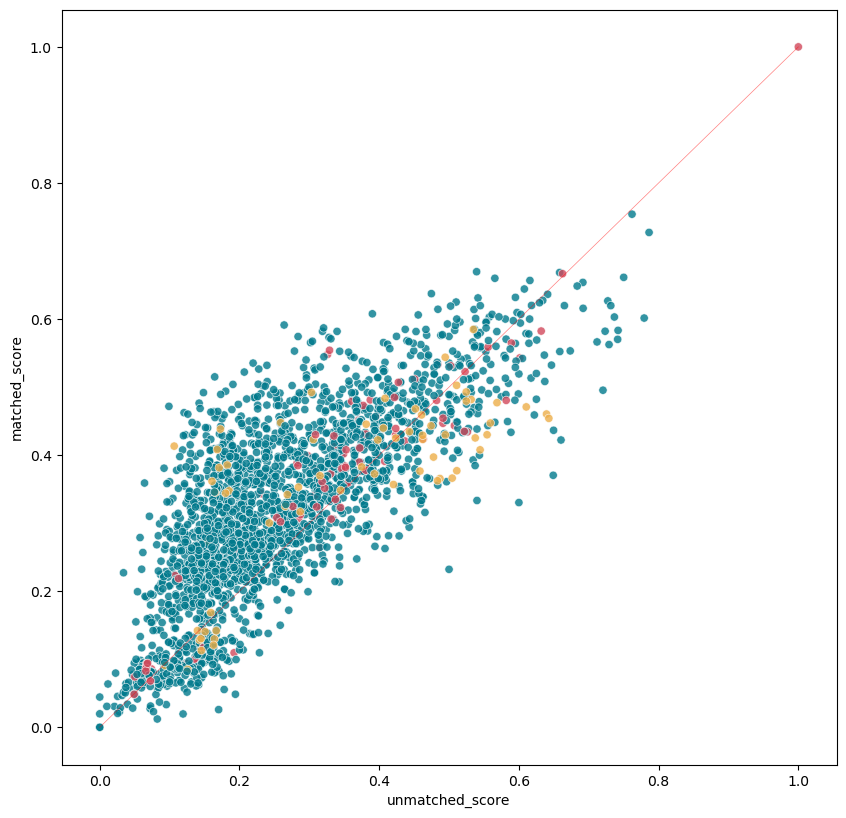

In [49]:
results = pd.read_csv('../20230718_Results/Table X. tanimoto_between_project(cohend).csv', index_col=0)
fig = plt.figure(figsize=(10, 10), dpi=100)
palette = ['#edae49' if projects_message[p1][0]==projects_message[p2][0]=='VatanenT_2016' else ('#d1495b' if projects_message[p1][3]==projects_message[p2][3] else '#00798c') for p1, p2 in results[['project1', 'project2']].values]
ax = sns.scatterplot(data=results, x='unmatched_score', y='matched_score', c=palette, alpha=0.8)
_ = ax.plot([0, 1], [0, 1], color='red', lw=0.5, alpha=0.5)
#_ = plt.xlim(-0.6, 1.05)
#_ = plt.ylim(-0.6, 1.05)

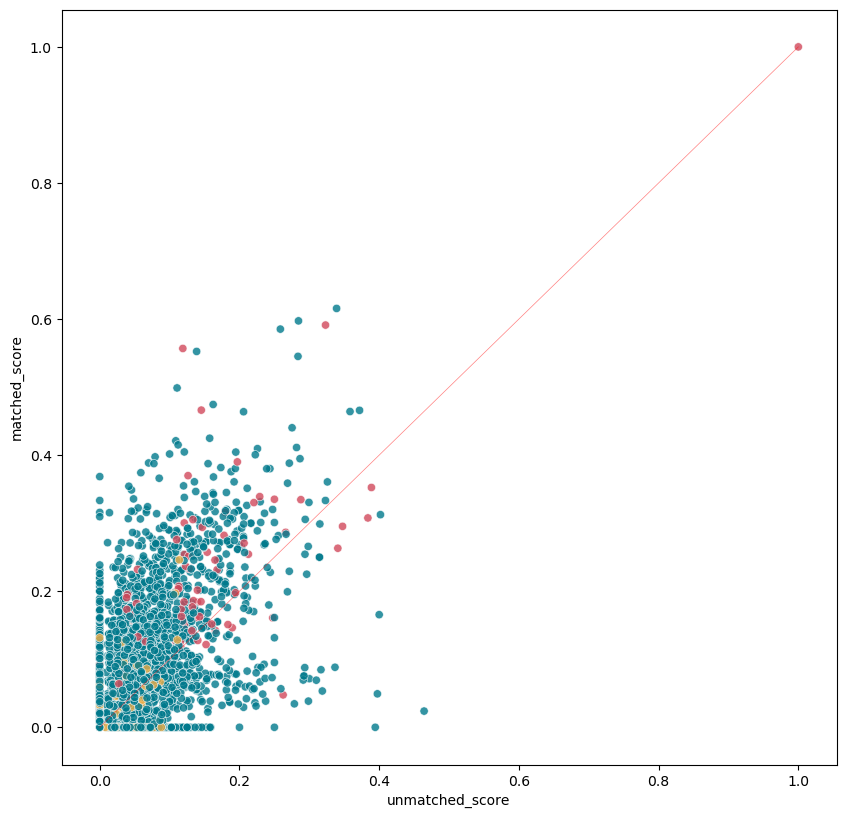

In [50]:
results = pd.read_csv('../20230718_Results/Table X. tanimoto_between_project(pvalue).csv', index_col=0)
fig = plt.figure(figsize=(10, 10), dpi=100)
palette = ['#edae49' if projects_message[p1][0]==projects_message[p2][0]=='VatanenT_2016' else ('#d1495b' if projects_message[p1][3]==projects_message[p2][3] else '#00798c') for p1, p2 in results[['project1', 'project2']].values]
ax = sns.scatterplot(data=results, x='unmatched_score', y='matched_score', c=palette, alpha=0.8)
_ = ax.plot([0, 1], [0, 1], color='red', lw=0.5, alpha=0.5)
#_ = plt.xlim(-0.6, 1.05)
#_ = plt.ylim(-0.6, 1.05)

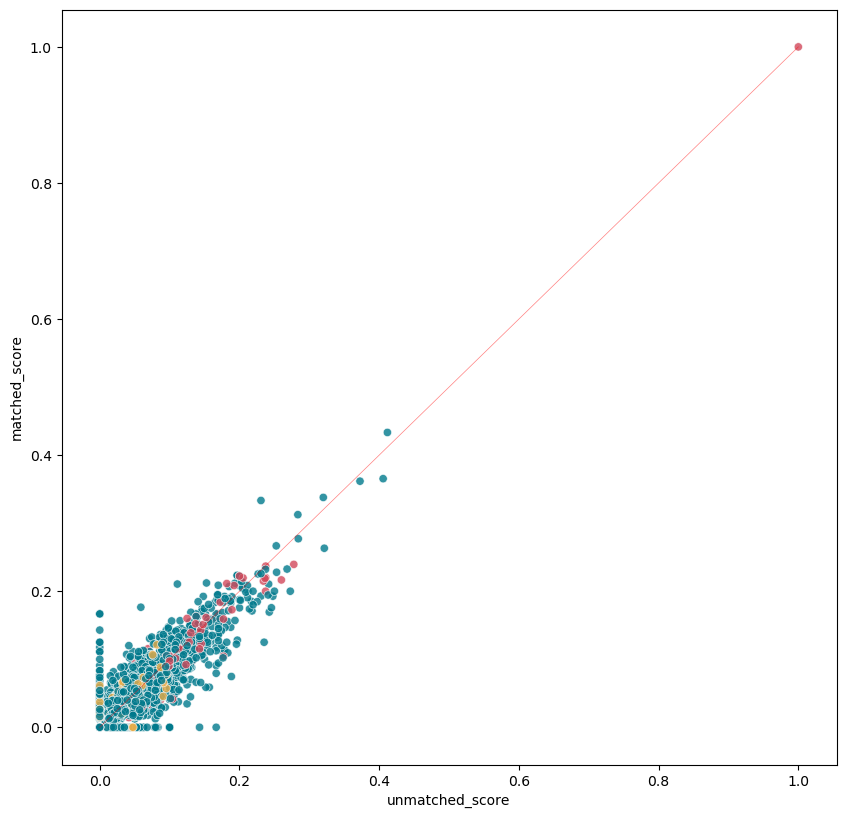

In [51]:
results = pd.read_csv('../20230718_Results/Table X. tanimoto_between_project(both).csv', index_col=0)
fig = plt.figure(figsize=(10, 10), dpi=100)
palette = ['#edae49' if projects_message[p1][0]==projects_message[p2][0]=='VatanenT_2016' else ('#d1495b' if projects_message[p1][3]==projects_message[p2][3] else '#00798c') for p1, p2 in results[['project1', 'project2']].values]
ax = sns.scatterplot(data=results, x='unmatched_score', y='matched_score', c=palette, alpha=0.8)
_ = ax.plot([0, 1], [0, 1], color='red', lw=0.5, alpha=0.5)
#_ = plt.xlim(-0.6, 1.05)
#_ = plt.ylim(-0.6, 1.05)

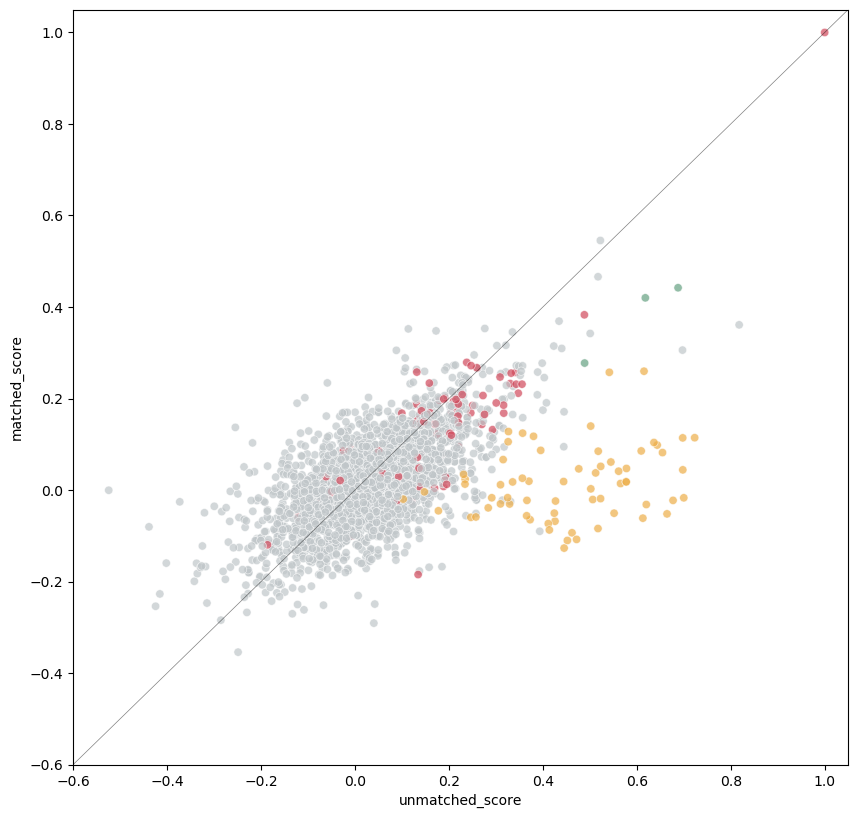

In [64]:
results = pd.read_csv('../20230718_Results/Table X. spearman_between_project(singd).csv', index_col=0)
fig = plt.figure(figsize=(10, 10), dpi=100)

palette = []
for p1, p2 in results[['project1', 'project2']].values:
    if projects_message[p1][0]==projects_message[p2][0]=='VatanenT_2016':
        palette.append('#edae49')
    elif projects_message[p1][0]==projects_message[p2][0]=='LiJ_2014':
        palette.append('#66a182')
    elif projects_message[p1][3]==projects_message[p2][3]=='CRC':
        palette.append('#d1495b')
    elif projects_message[p1][3]==projects_message[p2][3]=='IBD':
        palette.append('#d1495b')
    else:
        palette.append('#c0c6c9')
        
ax = sns.scatterplot(data=results, x='unmatched_score', y='matched_score', c=palette, alpha=0.7)
_ = ax.plot([-0.6, 1.05], [-0.6, 1.05], color='k', ls='--', lw=0.5, alpha=0.5)
_ = plt.xlim(-0.6, 1.05)
_ = plt.ylim(-0.6, 1.05)

In [69]:
results = pd.read_csv('../20230718_Results/Table X. spearman_between_project(singd).csv', index_col=0)
results['p1_name'] = [projects_message[i][0] for i in results['project1']]
results['p2_name'] = [projects_message[i][0] for i in results['project2']]
results['p1_trail1'] = [projects_message[i][3] for i in results['project1']]
results['p2_trail1'] = [projects_message[i][3] for i in results['project2']]
results.head(2)

,project1,project2,overlap_species,unmatched_score,unmatched_pvalue0,unmatched_pvalue,matched_score,matched_pvalue0,matched_pvalue,p1_name,p2_name,p1_trail1,p2_trail1
0,08,09,72,0.294507,0.012032,0.008,0.109566,0.359566,0.182,BrooksB_2017,Castro-NallarE_2015,premature_born,schizofrenia
1,08,100,122,0.102883,0.259454,0.103,-0.038400,0.674537,0.644,BrooksB_2017,ZhuF_2020,premature_born,schizofrenia


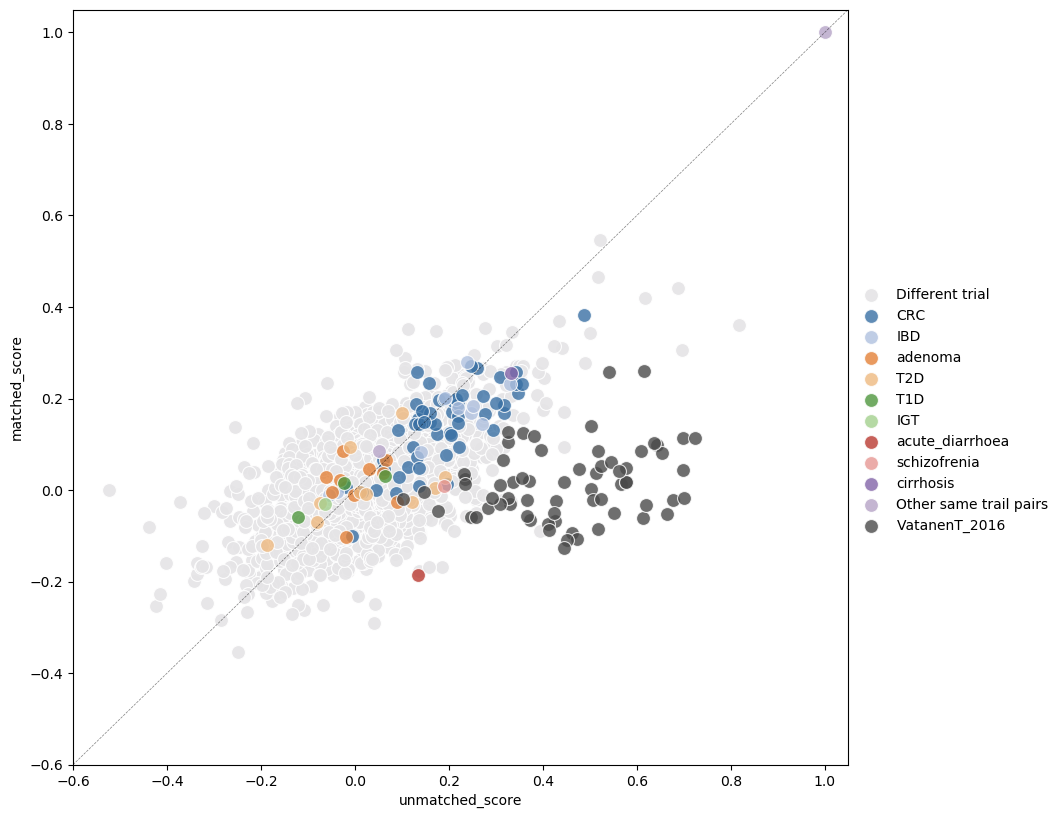

In [108]:
fig = plt.figure(figsize=(10, 10), dpi=100)
size = 100
palette = ['#3970A4', '#B0C1DF', '#E48138', '#EEB980', '#4F973E', '#A3D08E', '#BA3A31', '#E79894', '#8365A8', '#BEAECD']#list(sns.color_palette('tab20'))
diseases = ['CRC', 'IBD', 'adenoma', 'T2D', 'T1D', 'IGT', 'acute_diarrhoea', 'schizofrenia', 'cirrhosis']
### BG
ids = []
for i in results.index:
    if results.loc[i, 'p1_trail1']!=results.loc[i, 'p2_trail1'] and (results.loc[i, 'p1_name']!='VatanenT_2016' or results.loc[i, 'p2_name']!='VatanenT_2016'):
        ids.append(i)
sub = results.loc[ids, :]
ax = sns.scatterplot(data=sub, x='unmatched_score', y='matched_score', color='#e5e4e6', alpha=0.9, s=size, label='Different trial')

### Disease
for d in diseases:
    ids = []
    for i in results.index:
        if results.loc[i, 'p1_trail1']==results.loc[i, 'p2_trail1']==d:
            ids.append(i)
    sub = results.loc[ids, :]
    ax = sns.scatterplot(data=sub, x='unmatched_score', y='matched_score', color=palette[diseases.index(d)], s=size, alpha=0.8, label=d)

### Other same trails
ids = []
for i in results.index:
    if results.loc[i, 'p1_trail1']==results.loc[i, 'p2_trail1'] and results.loc[i, 'p1_trail1'] not in diseases:
        ids.append(i)
sub = results.loc[ids, :]
ax = sns.scatterplot(data=sub, x='unmatched_score', y='matched_score', color=palette[len(diseases)], s=size, alpha=0.9, label='Other same trail pairs')

### VatanenT_2016
ids = []
for i in results.index:
    if results.loc[i, 'p1_name']==results.loc[i, 'p2_name']=='VatanenT_2016':
        ids.append(i)
sub = results.loc[ids, :]
ax = sns.scatterplot(data=sub, x='unmatched_score', y='matched_score', color='#4a4a4a', s=size, alpha=0.8, marker='o', label='VatanenT_2016')

    
_ = ax.plot([-0.6, 1.05], [-0.6, 1.05], color='k', ls='--', lw=0.5, alpha=0.5)
_ = plt.xlim(-0.6, 1.05)
_ = plt.ylim(-0.6, 1.05)
_ = plt.legend(loc=(1.005, 0.3), frameon=False)
_ = plt.savefig("../20230718_Results/Figure 4X. Spearman correlation pairs (signd).pdf", dpi=300)
_ = plt.show()

In [14]:
results = pd.read_csv('../20230718_Results/Table X. spearman_between_project(singd).csv', index_col=0)
results['p1_name'] = [projects_message[i][0] for i in results['project1']]
results['p2_name'] = [projects_message[i][0] for i in results['project2']]
results['p1_trail1'] = [projects_message[i][3] for i in results['project1']]
results['p2_trail1'] = [projects_message[i][3] for i in results['project2']]
results.head(2)

results.sort_values(['unmatched_score'], ascending=False).head(2)

####
ids = []
for i in results.index:
    if results.loc[i, 'p1_trail1']!=results.loc[i, 'p2_trail1'] and (results.loc[i, 'p1_name']!='VatanenT_2016' or results.loc[i, 'p2_name']!='VatanenT_2016'):
        ids.append(i)
sub = results.loc[ids, :]
sub['unmatched_score'].mean(), sub['matched_score'].mean()

#####
ids = []
for i in results.index:
    if results.loc[i, 'p1_trail1']==results.loc[i, 'p2_trail1'] and (i!=233):
        ids.append(i)
sub = results.loc[ids, :]
sub['unmatched_score'].mean(), sub['matched_score'].mean()

###
ids = []
for i in results.index:
    if results.loc[i, 'p1_name']==results.loc[i, 'p2_name']=='VatanenT_2016':
        ids.append(i)
sub = results.loc[ids, :]
sub['unmatched_score'].mean(), sub['matched_score'].mean()

,project1,project2,overlap_species,unmatched_score,unmatched_pvalue0,unmatched_pvalue,matched_score,matched_pvalue0,matched_pvalue,p1_name,p2_name,p1_trail1,p2_trail1
0,08,09,72,0.294507,0.012032,0.008,0.109566,0.359566,0.182,BrooksB_2017,Castro-NallarE_2015,premature_born,schizofrenia
1,08,100,122,0.102883,0.259454,0.103,-0.038400,0.674537,0.644,BrooksB_2017,ZhuF_2020,premature_born,schizofrenia


,project1,project2,overlap_species,unmatched_score,unmatched_pvalue0,unmatched_pvalue,matched_score,matched_pvalue0,matched_pvalue,p1_name,p2_name,p1_trail1,p2_trail1
233,101,58,436,1.000000,0.000000e+00,0.001,1.000000,0.000000e+00,0.001,NagySzakalD_2017,NagySzakalD_2017,ME/CFS,ME/CFS
1595,50_1,50_3,334,0.817912,1.055170e-81,0.001,0.361025,1.016935e-11,0.001,LiSS_2016,LiSS_2016,FMT,metabolic_syndrome


(0.030419957402970804, 0.017021003132892107)

(0.14002460511425122, 0.10361113277668749)

(0.45085597600988225, 0.014374383867734403)

,project1,project2,overlap_species,unmatched_score,unmatched_pvalue,matched_score,matched_pvalue,p1_name,p2_name,p1_trail1,p2_trail1
0,08,09,72,0.043513,0.716657,0.067566,0.572804,BrooksB_2017,Castro-NallarE_2015,premature_born,schizofrenia
1,08,100,122,0.144411,0.112518,0.140509,0.122670,BrooksB_2017,ZhuF_2020,premature_born,schizofrenia


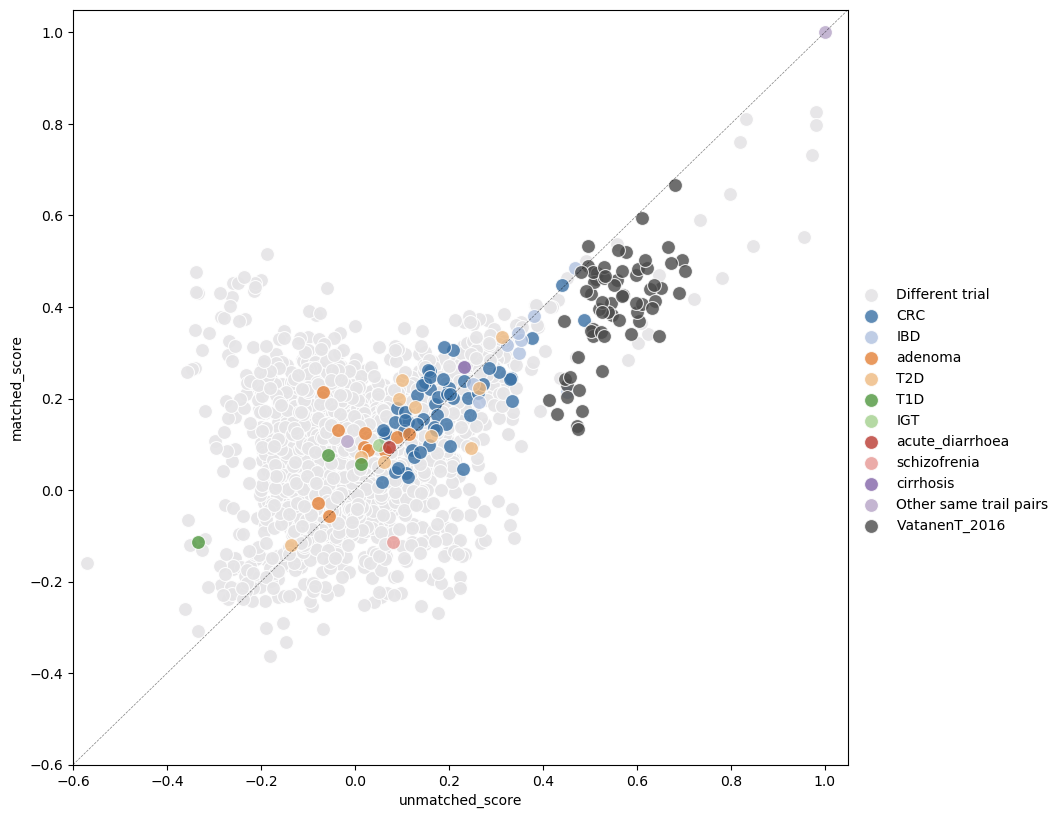

In [109]:
results = pd.read_csv('../20230718_Results/Table X. spearman_between_project(FC).csv', index_col=0)
results['p1_name'] = [projects_message[i][0] for i in results['project1']]
results['p2_name'] = [projects_message[i][0] for i in results['project2']]
results['p1_trail1'] = [projects_message[i][3] for i in results['project1']]
results['p2_trail1'] = [projects_message[i][3] for i in results['project2']]
results.head(2)

fig = plt.figure(figsize=(10, 10), dpi=100)
size = 100
palette = ['#3970A4', '#B0C1DF', '#E48138', '#EEB980', '#4F973E', '#A3D08E', '#BA3A31', '#E79894', '#8365A8', '#BEAECD']#list(sns.color_palette('tab20'))
diseases = ['CRC', 'IBD', 'adenoma', 'T2D', 'T1D', 'IGT', 'acute_diarrhoea', 'schizofrenia', 'cirrhosis']
### BG
ids = []
for i in results.index:
    if results.loc[i, 'p1_trail1']!=results.loc[i, 'p2_trail1'] and (results.loc[i, 'p1_name']!='VatanenT_2016' or results.loc[i, 'p2_name']!='VatanenT_2016'):
        ids.append(i)
sub = results.loc[ids, :]
ax = sns.scatterplot(data=sub, x='unmatched_score', y='matched_score', color='#e5e4e6', alpha=0.9, s=size, label='Different trial')

### Disease
for d in diseases:
    ids = []
    for i in results.index:
        if results.loc[i, 'p1_trail1']==results.loc[i, 'p2_trail1']==d:
            ids.append(i)
    sub = results.loc[ids, :]
    ax = sns.scatterplot(data=sub, x='unmatched_score', y='matched_score', color=palette[diseases.index(d)], s=size, alpha=0.8, label=d)

### Other same trails
ids = []
for i in results.index:
    if results.loc[i, 'p1_trail1']==results.loc[i, 'p2_trail1'] and results.loc[i, 'p1_trail1'] not in diseases:
        ids.append(i)
sub = results.loc[ids, :]
ax = sns.scatterplot(data=sub, x='unmatched_score', y='matched_score', color=palette[len(diseases)], s=size, alpha=0.9, label='Other same trail pairs')

### VatanenT_2016
ids = []
for i in results.index:
    if results.loc[i, 'p1_name']==results.loc[i, 'p2_name']=='VatanenT_2016':
        ids.append(i)
sub = results.loc[ids, :]
ax = sns.scatterplot(data=sub, x='unmatched_score', y='matched_score', color='#4a4a4a', s=size, alpha=0.8, marker='o', label='VatanenT_2016')

    
_ = ax.plot([-0.6, 1.05], [-0.6, 1.05], color='k', ls='--', lw=0.5, alpha=0.5)
_ = plt.xlim(-0.6, 1.05)
_ = plt.ylim(-0.6, 1.05)
_ = plt.legend(loc=(1.005, 0.3), frameon=False)
_ = plt.savefig("../20230718_Results/Figure 4X. Spearman correlation pairs (FC).pdf", dpi=300)
_ = plt.show()

In [110]:
results.sort_values(['unmatched_score'])

,project1,project2,overlap_species,unmatched_score,unmatched_pvalue,matched_score,matched_pvalue,p1_name,p2_name,p1_trail1,p2_trail1
338,15,24_3,97,-0.570081,1.094734e-09,-0.158959,1.199046e-01,DavidLA_2015,GhensiP_2019,acute_diarrhoea,peri-implantitis
337,15,24_1,97,-0.362192,2.668444e-04,-0.259845,1.016068e-02,DavidLA_2015,GhensiP_2019,acute_diarrhoea,mucositis
1498,48_6,84_8,463,-0.358035,1.892747e-15,0.258574,1.650886e-08,LiJ_2014,VatanenT_2016,T2D,pneumonia
122,09,84_7,123,-0.354917,5.625914e-05,-0.065457,4.719493e-01,Castro-NallarE_2015,VatanenT_2016,schizofrenia,otitis
641,24_3,96,72,-0.350271,2.558746e-03,-0.120527,3.132201e-01,GhensiP_2019,YeZ_2018,peri-implantitis,BD
...,...,...,...,...,...,...,...,...,...,...,...
1595,50_1,50_3,334,0.955421,5.783482e-178,0.553759,3.112114e-28,LiSS_2016,LiSS_2016,FMT,metabolic_syndrome
1380,48_1,48_5,621,0.971965,0.000000e+00,0.733145,9.808042e-106,LiJ_2014,LiJ_2014,IBD,T1D
1381,48_1,48_6,621,0.980954,0.000000e+00,0.825605,5.615119e-156,LiJ_2014,LiJ_2014,IBD,T2D
1425,48_5,48_6,621,0.982001,0.000000e+00,0.798833,9.407999e-139,LiJ_2014,LiJ_2014,T1D,T2D


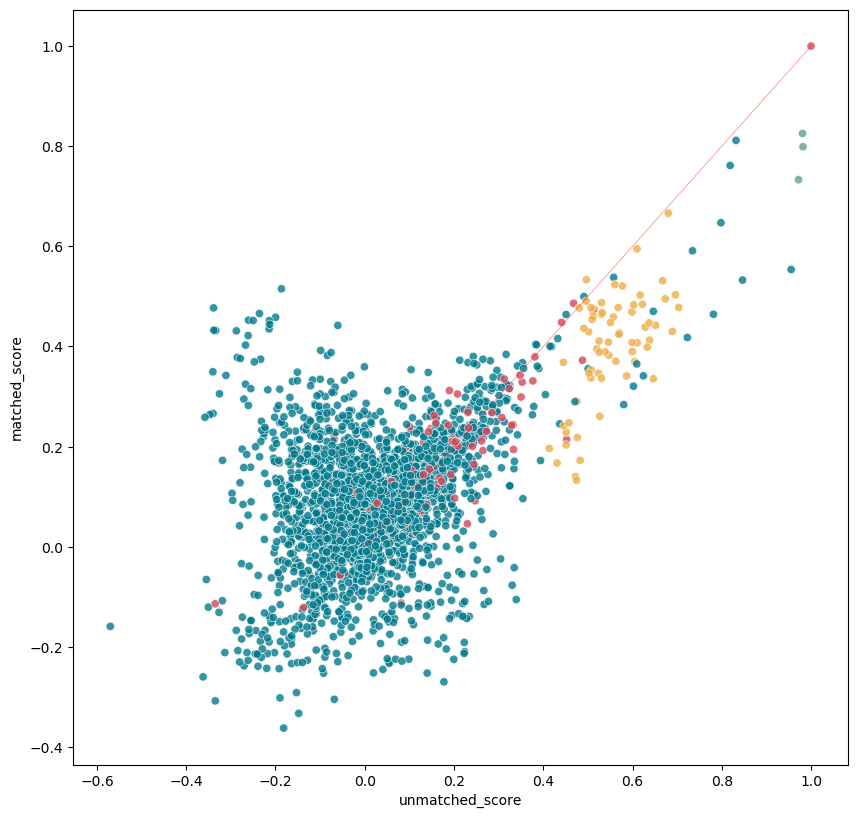

In [53]:
results = pd.read_csv('../20230718_Results/Table X. spearman_between_project(FC).csv', index_col=0)
fig = plt.figure(figsize=(10, 10), dpi=100)
palette = []
for p1, p2 in results[['project1', 'project2']].values:
    if projects_message[p1][0]==projects_message[p2][0]=='VatanenT_2016':
        palette.append('#edae49')
    elif projects_message[p1][0]==projects_message[p2][0]=='LiJ_2014':
        palette.append('#66a182')
    elif projects_message[p1][3]==projects_message[p2][3]:
        palette.append('#d1495b')
    else:
        palette.append('#00798c')
#palette = ['#edae49' if projects_message[p1][0]==projects_message[p2][0]=='VatanenT_2016' else ('#d1495b' if projects_message[p1][3]==projects_message[p2][3] else '#00798c') for p1, p2 in results[['project1', 'project2']].values]
ax = sns.scatterplot(data=results, x='unmatched_score', y='matched_score', c=palette, alpha=0.8)
_ = ax.plot([0, 1], [0, 1], color='red', lw=0.5, alpha=0.5)
#_ = plt.xlim(-0.6, 1.05)
#_ = plt.ylim(-0.6, 1.05)

In [56]:
projects_message['50_1']
projects_message['50_3']

['LiSS_2016', 'stool', 'control', 'FMT']

['LiSS_2016', 'stool', 'control', 'metabolic_syndrome']